$(0,1)$ differences may occur for instances with $10.2 < LSTAT < 19.2, ZN < 6, CRIM<7, AGE≥1$
- Differences: $11.1 ≤ LSTAT < 18.8, ZN=0$ (13 instances)
- CF: $CRIM≥7 \rightarrow (0,0)$
- L: $10.3 < LSTAT$
    - CF: $LSTAT≤10.2 \rightarrow (1,1)$
    - CF: $LSTAT≥19.2 \rightarrow (0,0)$
    - CF: $AGE=0 \rightarrow (0,0), (1,0)$
    - CF: $ZN≥6 \rightarrow (1,1)$

$(1,2)$ differences may occur for instances with $4.5 < LSTAT < 6.3, ZN < 90, INDUS < 9$
- Differences: 1 instance
- R: $LSTAT ≤ 9.6$
    - CF: $LSTAT ≤ 4.5 \rightarrow (2,2)$
    - CF: $LSTAT ≥ 6.3 \rightarrow (1,1)$
    - CF: $ZN≥90 \rightarrow (2,2)$
    - CF: $INDUS ≥ 9 \rightarrow (1,1)$

$(2,1)$ differences may occur for instances with $5.9 < LSTAT < 9.0, RM<7.3, DIS<4.2$
- Differences: $6.4 < LSTAT < 9.0$ 3 instances
- R: $LSTAT ≤ 10.9$
    - CF: $5.9 < LSTAT < 9.1$
    - CF: $RM≥7.3 \rightarrow (2,2)$
    - CF: $DIS≥4.2 \rightarrow (1,1)$

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering, plot_dendrogram
from tasks.boston_housing import make_task3 as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
shap.initjs()

In [2]:
try:
    with open('shap.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = pickle.load(f)
    global_feature_order, _ = calc_feature_order(explanations.mclass_diff.log_odds)
except FileNotFoundError:
    pass

# Setup Task

In [3]:
categorical_features = ['AGE']
feature_precisions = [0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2]

In [4]:
clf_a, clf_b, X, y, feature_names = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [6]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open('shap.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

Using Exact algorithm
Using Exact algorithm
Using Exact algorithm


Exact explainer: 247it [01:55,  2.07it/s]                         
Exact explainer: 247it [01:47,  2.08it/s]                         
Exact explainer: 247it [07:35,  1.90s/it]                         

CPU times: user 12min 31s, sys: 2min 17s, total: 14min 49s
Wall time: 11min 18s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [7]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

# Traditional SHAP Explanations

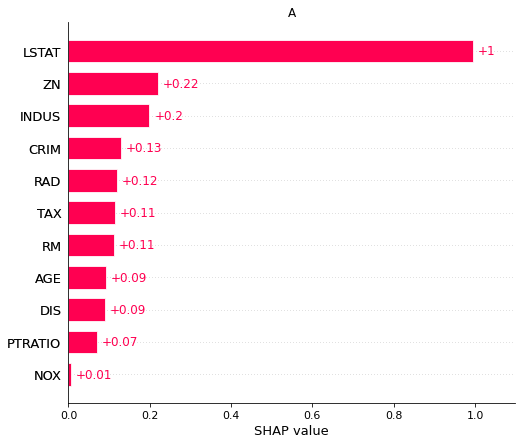

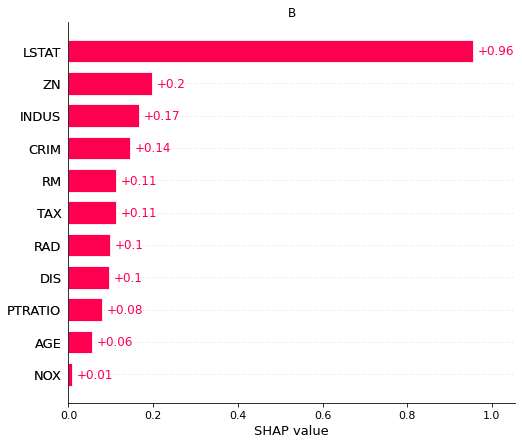

In [8]:
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.A)
plot_feature_importance_bar(feature_importances, 'A')
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.B)
plot_feature_importance_bar(feature_importances, 'B')

In [9]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)
feature_order = feature_order[:-1]

In [10]:
node, Z = make_clustering(comparer, explanations.indiv.log_odds, categorical_features=categorical_features)

In [11]:
feature_it = iter(feature_order)

In [12]:
def plot_next_feature():
    feature = next(feature_it)
    for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
        node.plot_feature(feature, classes=list(classes), alpha=0.5)

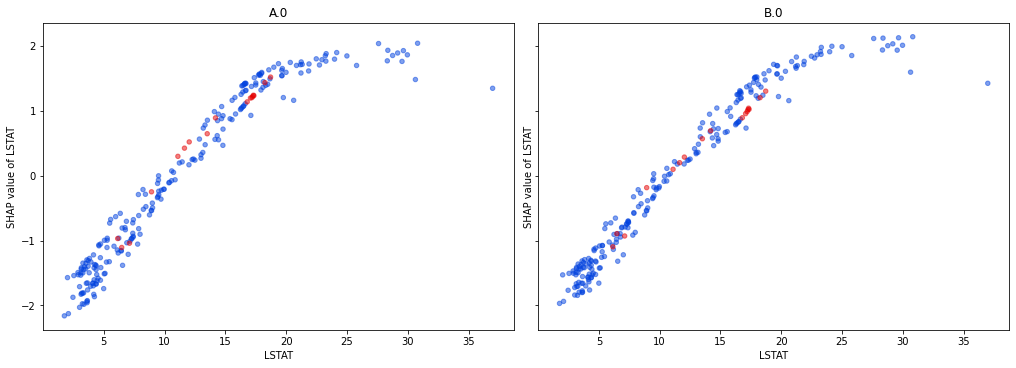

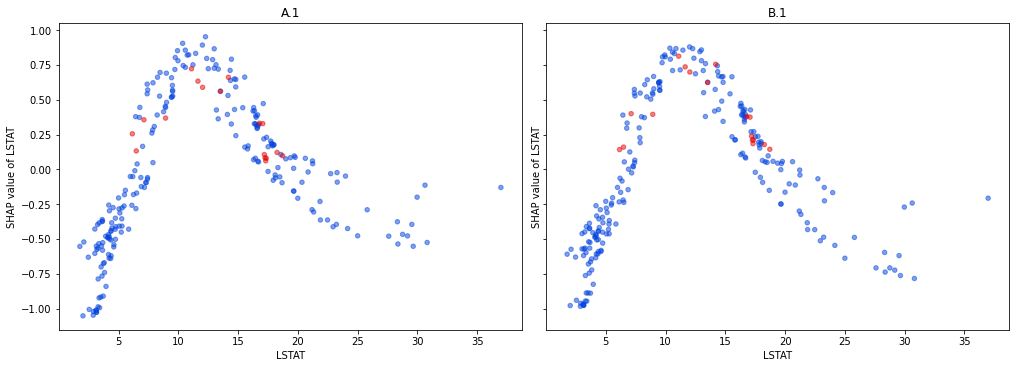

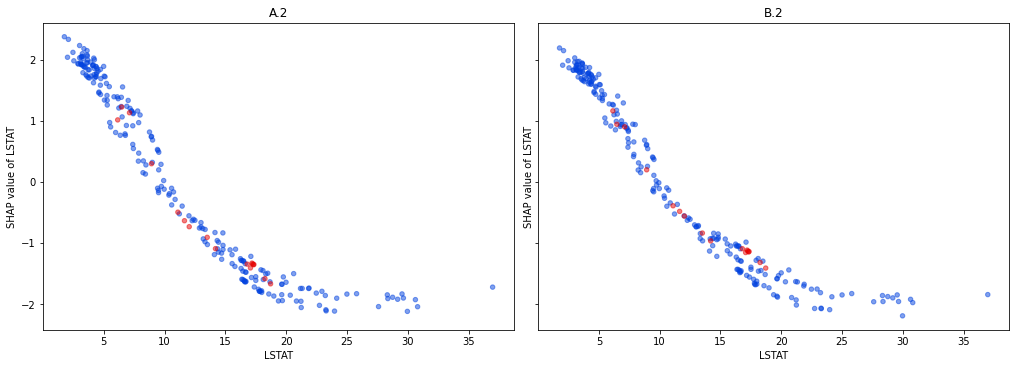

In [13]:
plot_next_feature()

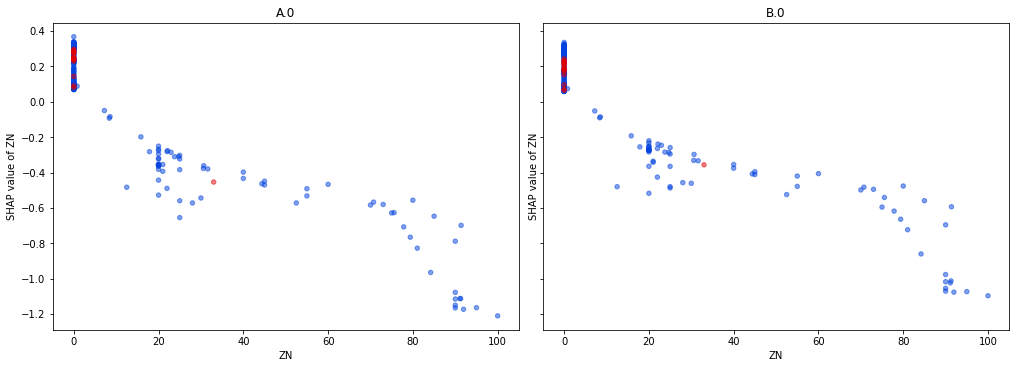

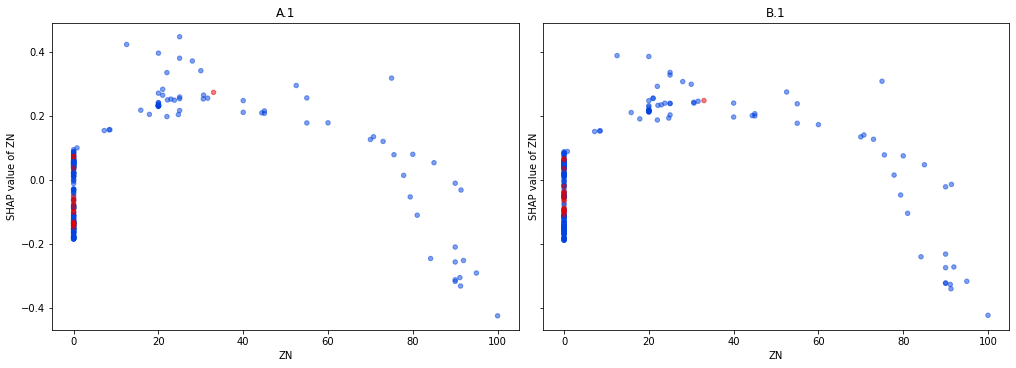

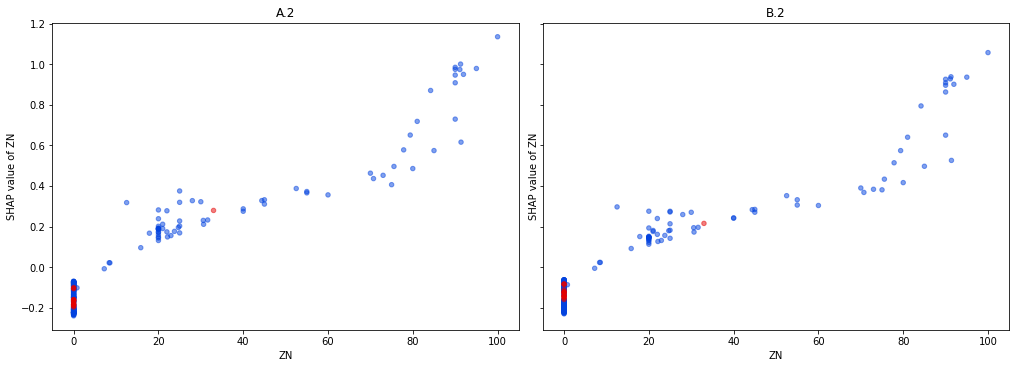

In [14]:
plot_next_feature()

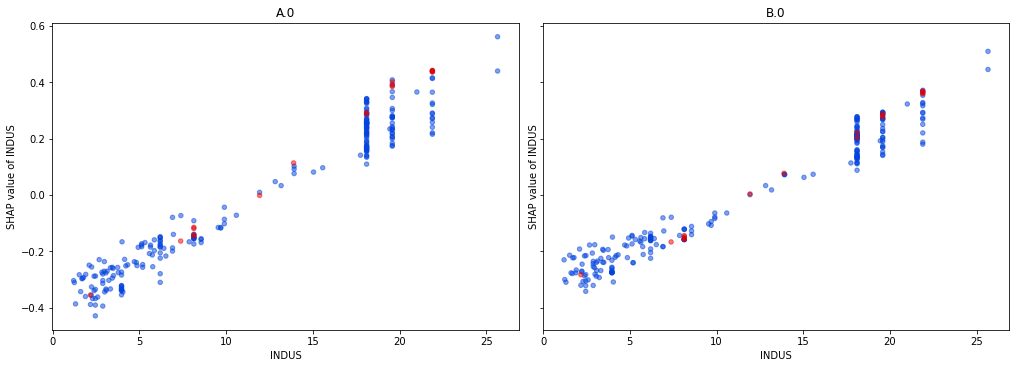

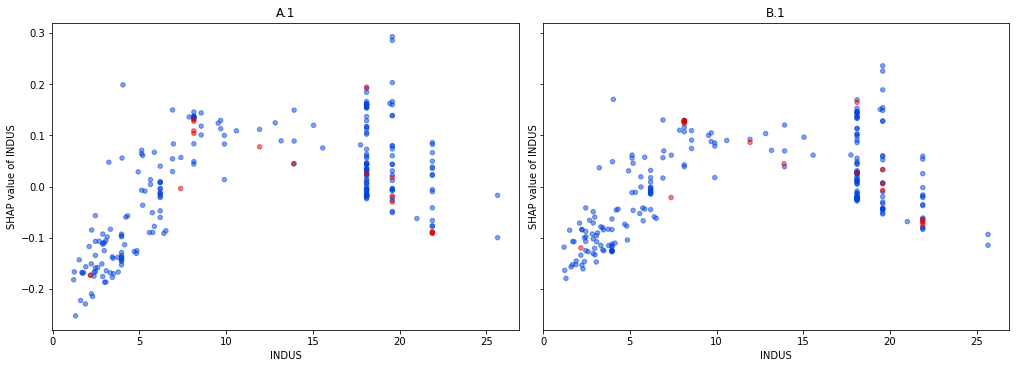

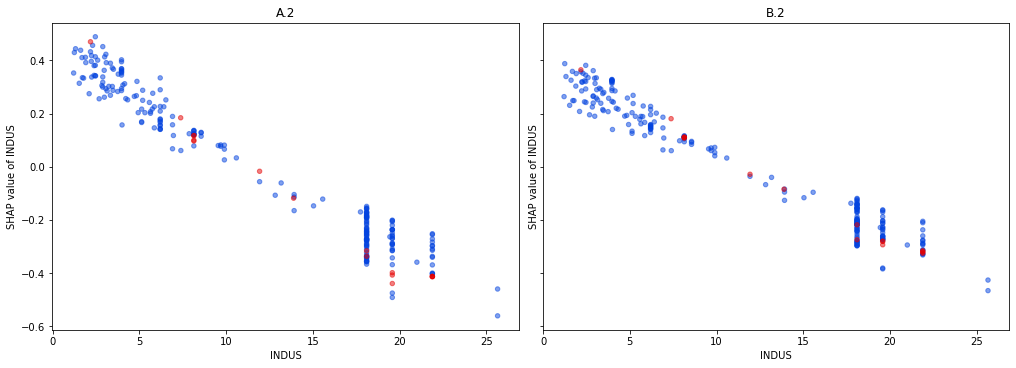

In [15]:
plot_next_feature()

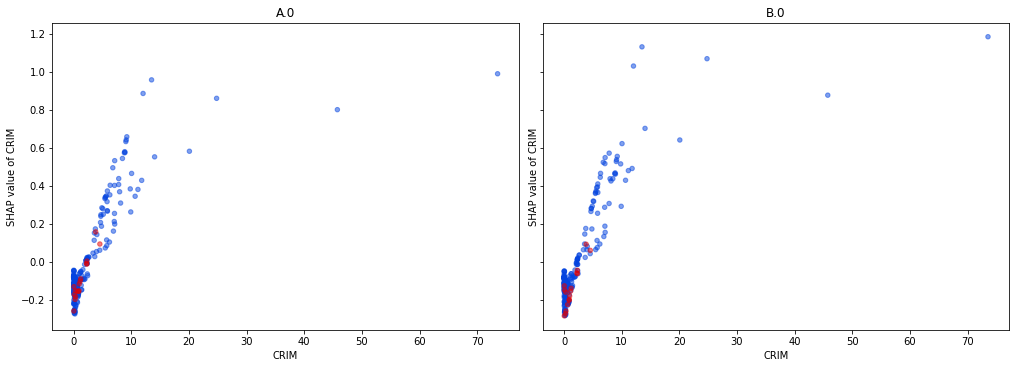

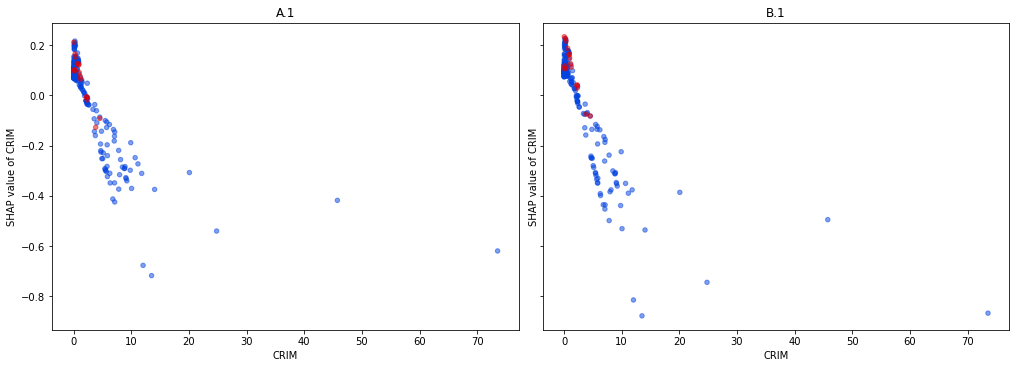

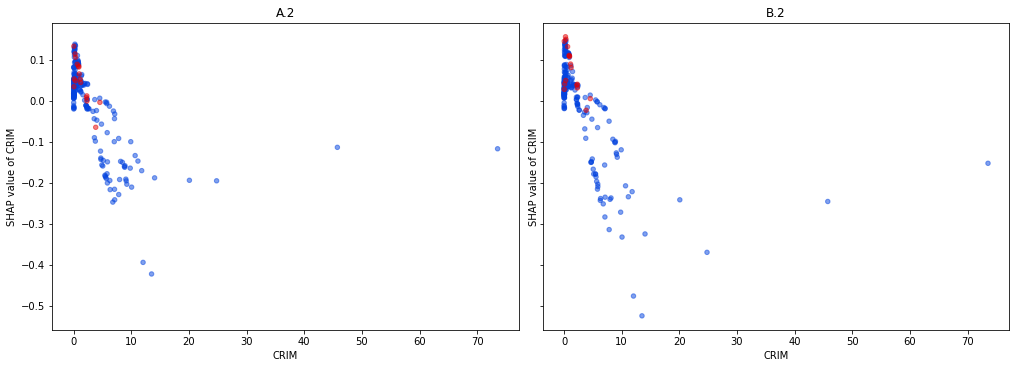

In [16]:
plot_next_feature()

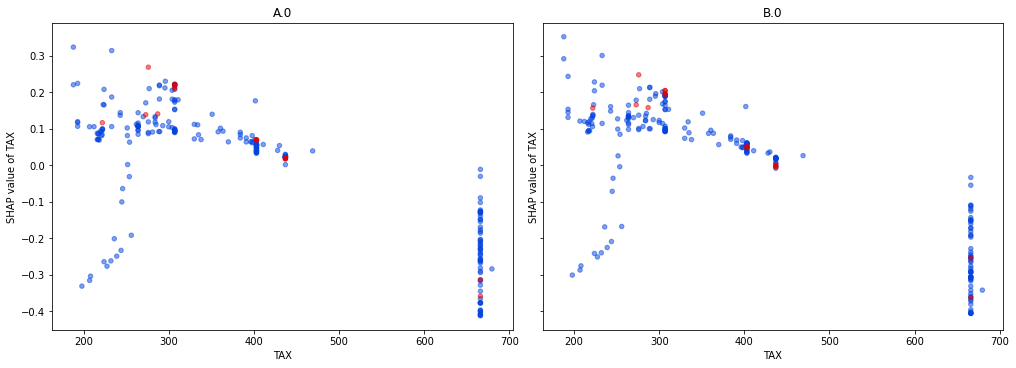

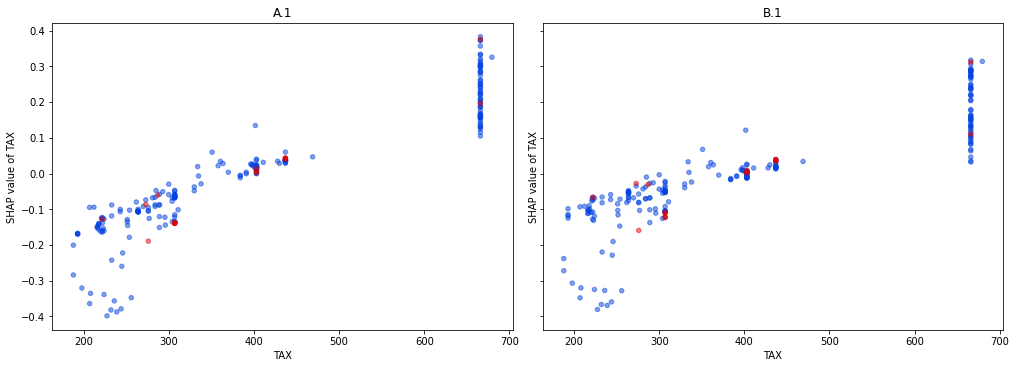

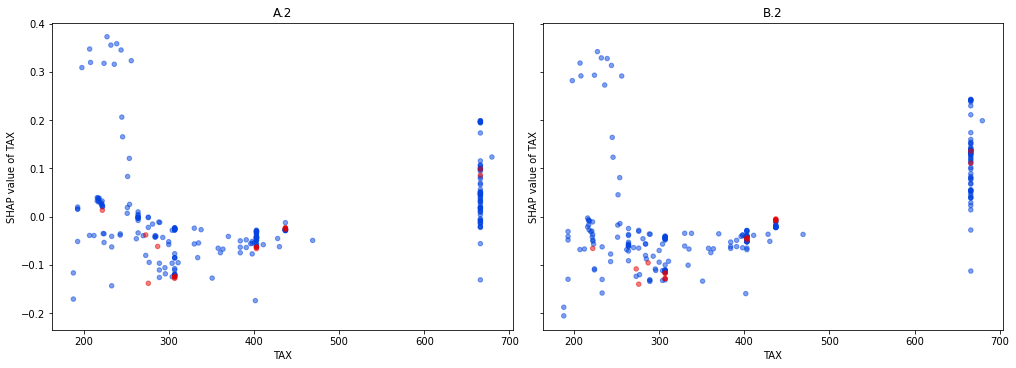

In [17]:
plot_next_feature()

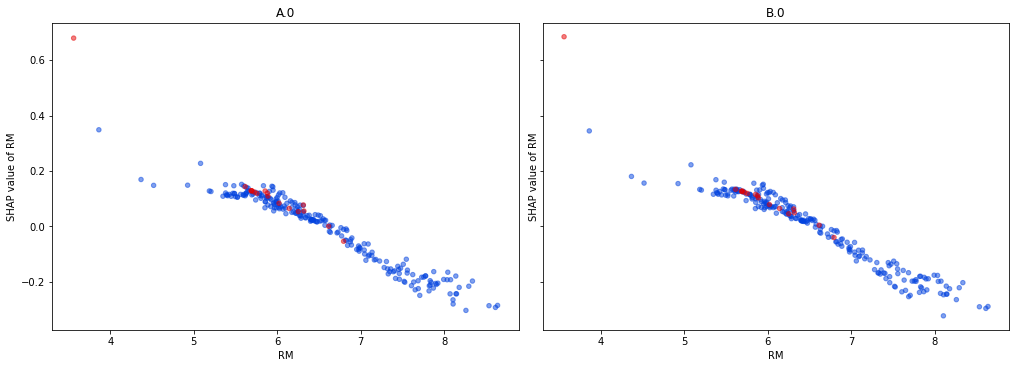

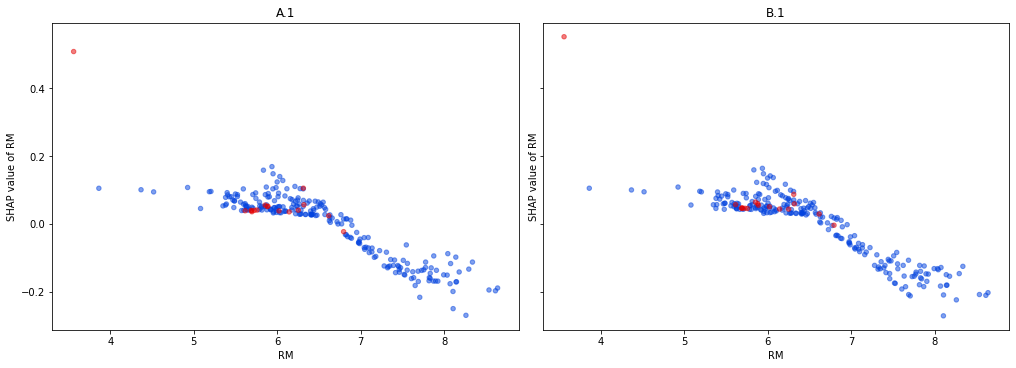

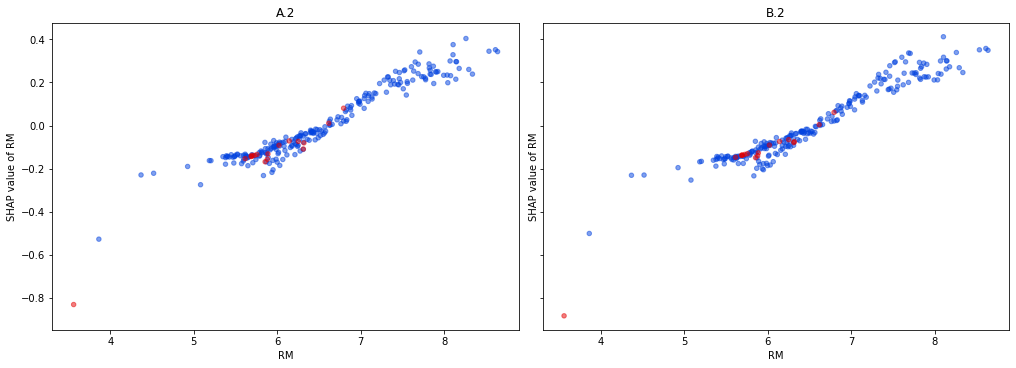

In [18]:
plot_next_feature()

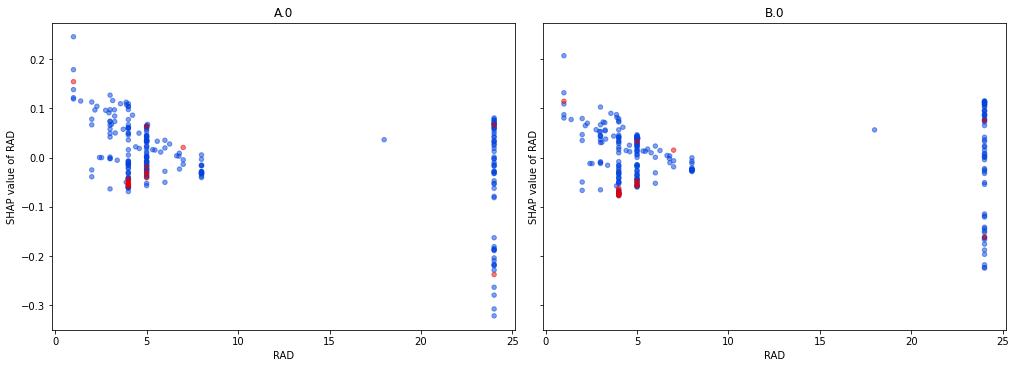

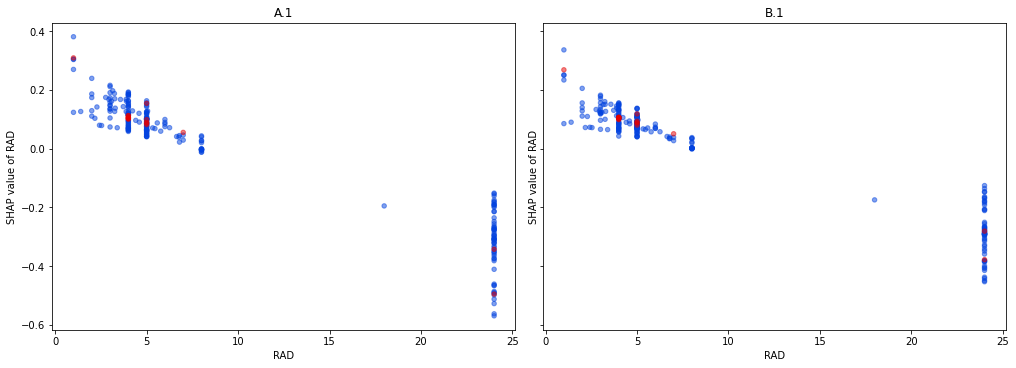

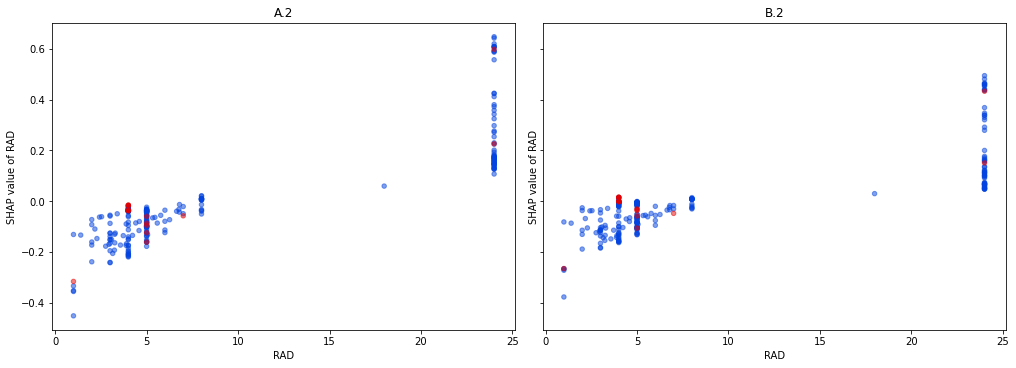

In [19]:
plot_next_feature()

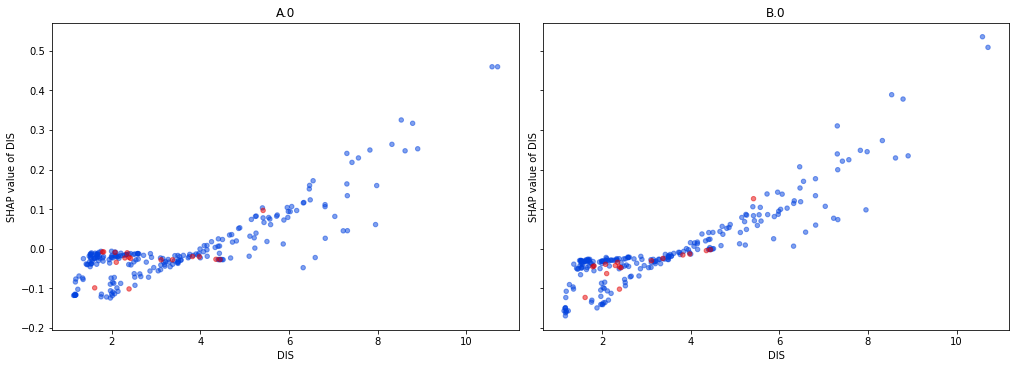

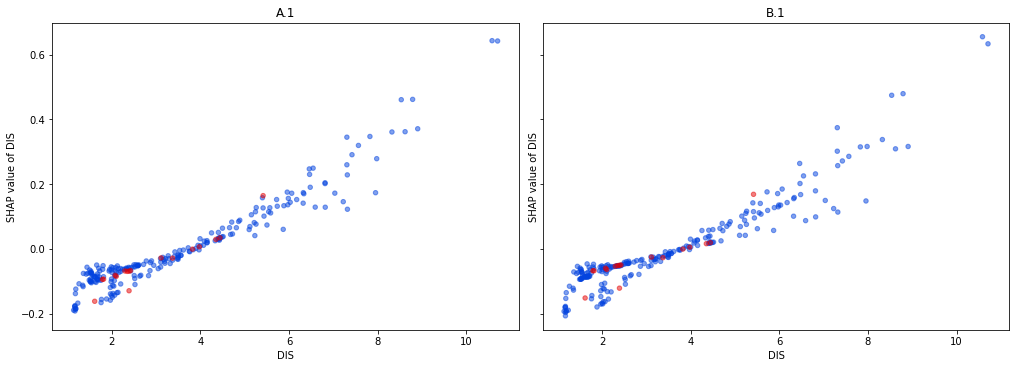

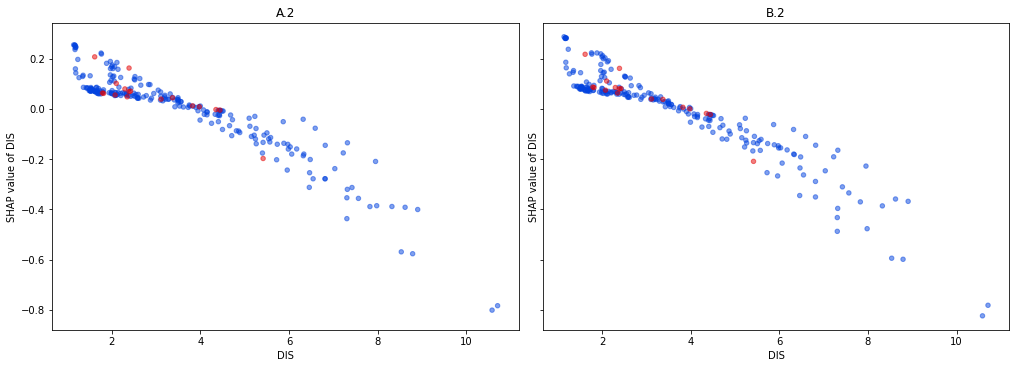

In [20]:
plot_next_feature()

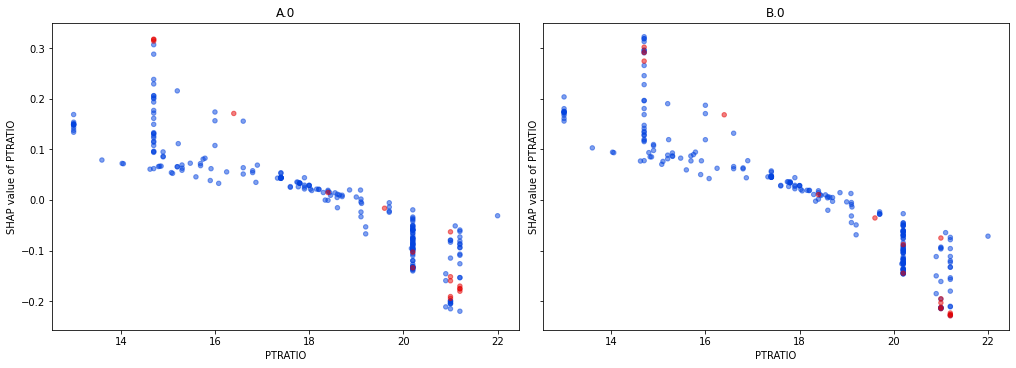

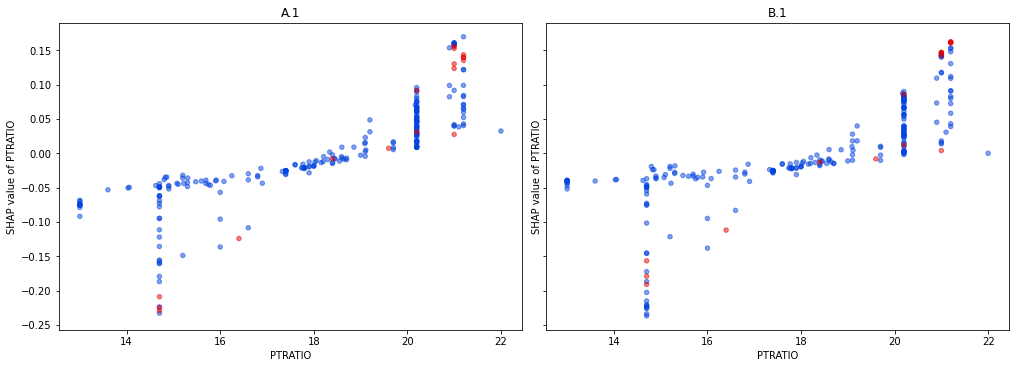

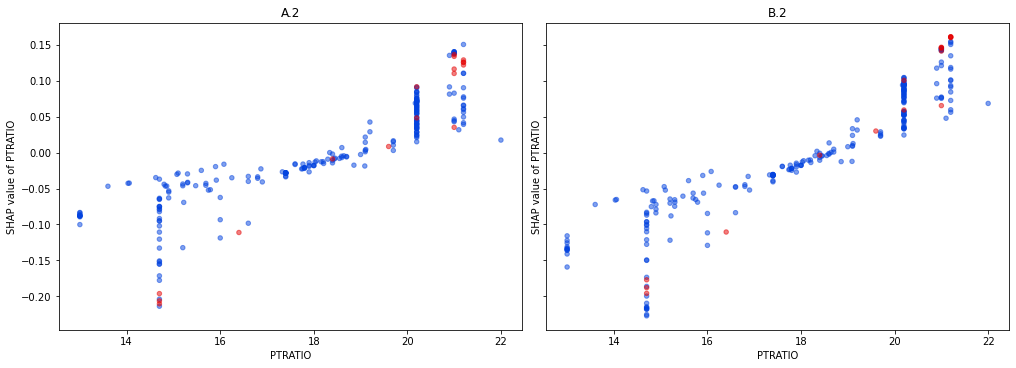

In [21]:
plot_next_feature()

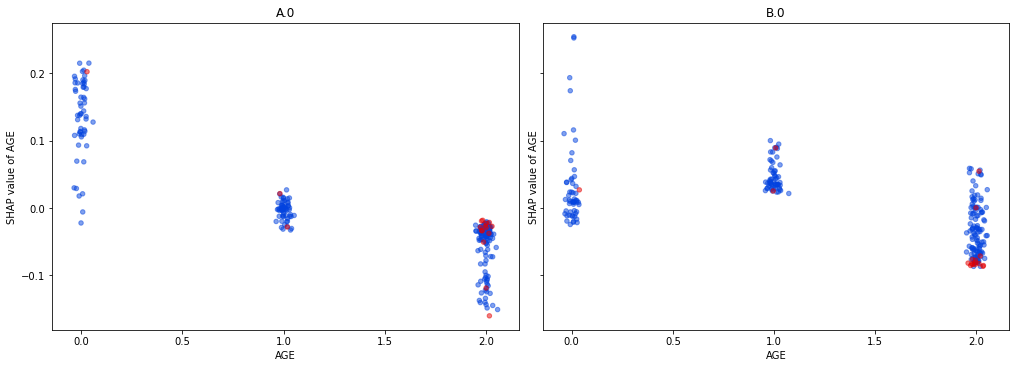

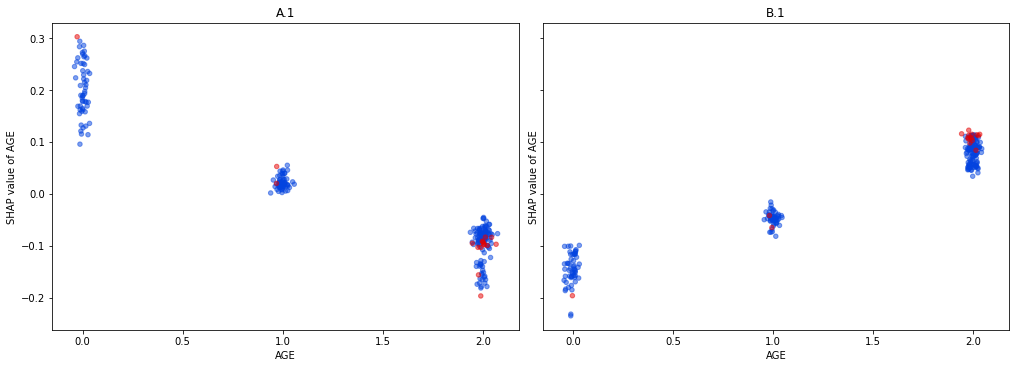

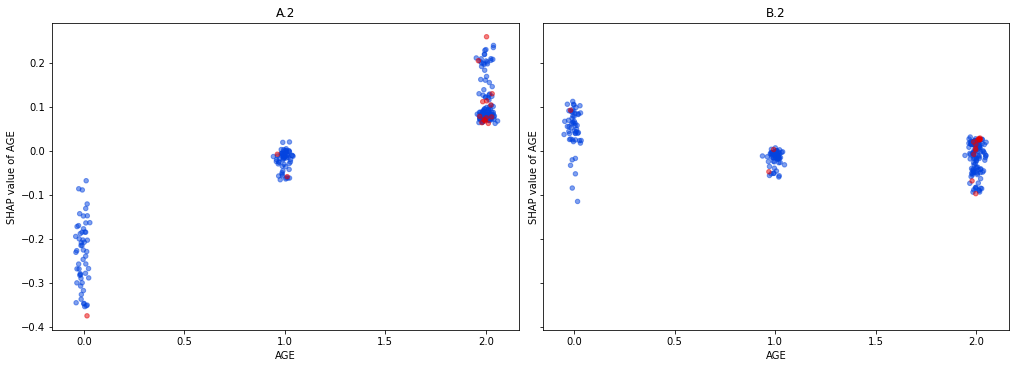

In [22]:
plot_next_feature()

# Difference Classifier SHAP Explanations

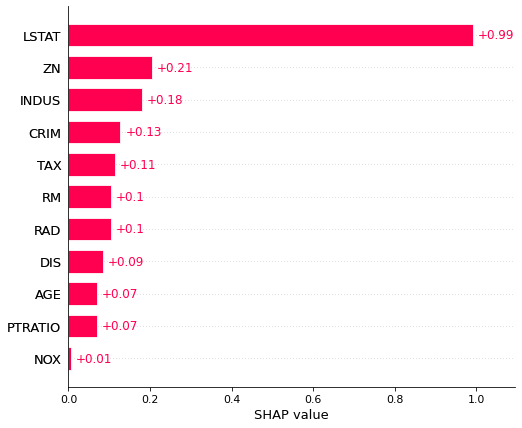

In [5]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importances)

In [6]:
feature_order = feature_order[:-1]
global_feature_order = feature_order

The equality classes (0,0) and (2,2) have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

(0,2) and (2,0) have the least importances.

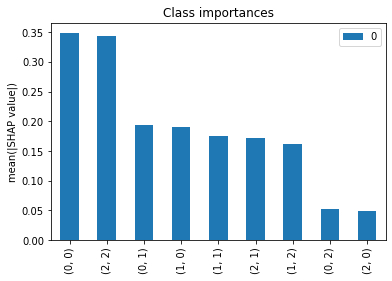

In [7]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [8]:
class_order = np.sort(class_order[:-2])

## Clustering of Class $(0,1)$ SHAP Values

In [33]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds,
                          '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                          categorical_features=categorical_features,
                          feature_precisions=feature_precisions)

### Node L

In [34]:
node.class_counts, node.distance

((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 53.48179984991664)

In [35]:
node = node.get_left()
node.class_counts, node.distance

((0, 0)    76
 (1, 1)    33
 (0, 1)    13
 dtype: int64,
 15.373174011970239)

In [36]:
node.get_left().class_counts

(0, 0)    52
(0, 1)     6
dtype: int64

11.1 <= LSTAT <= 18.72
LSTAT <= 10.24 --> {'(1, 1)': 13}
LSTAT >= 19.17 --> {'(0, 0)': 13}


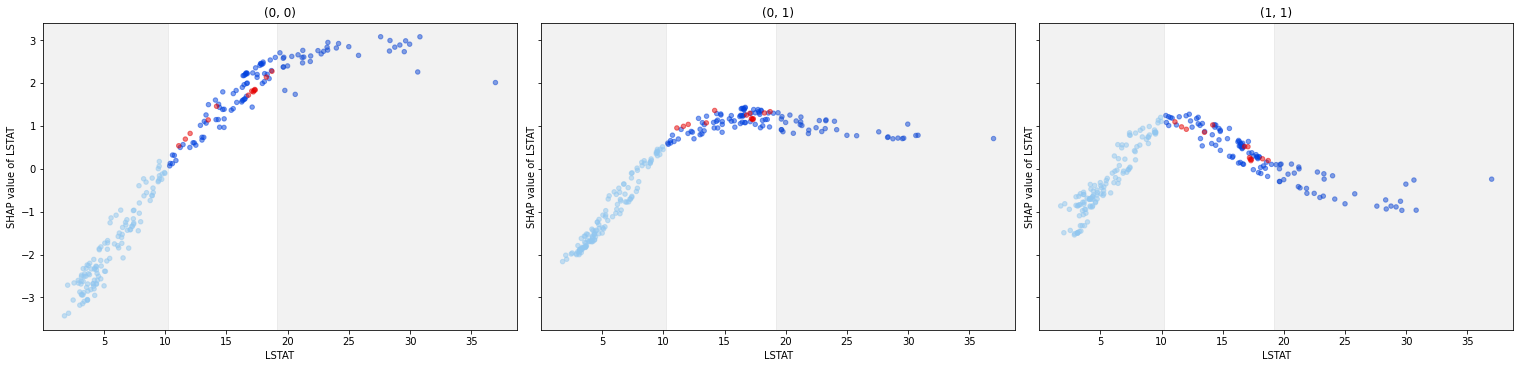

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 13}


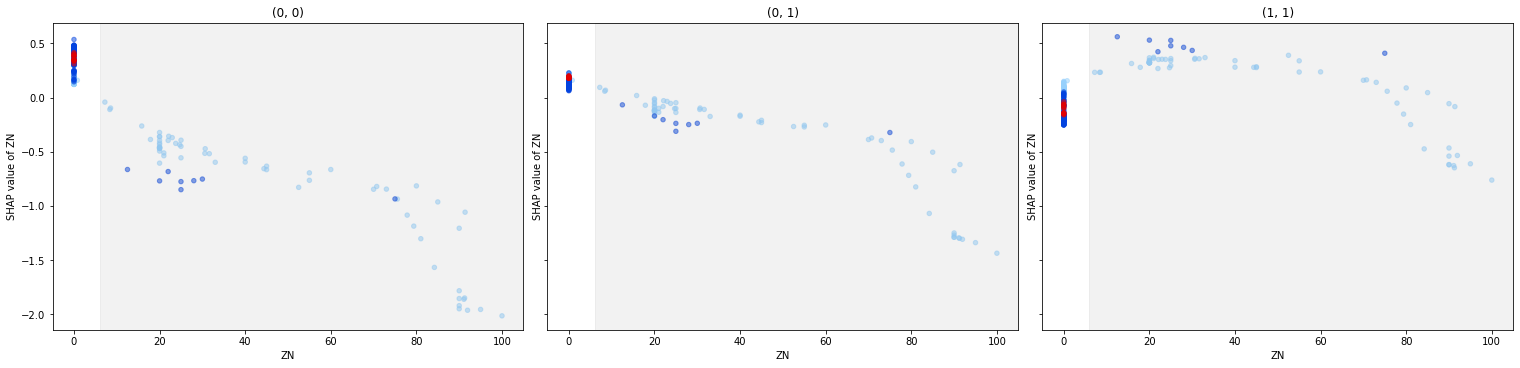

0.0456 <= CRIM <= 3.83684
CRIM >= 7.0 --> {'(0, 0)': 13}


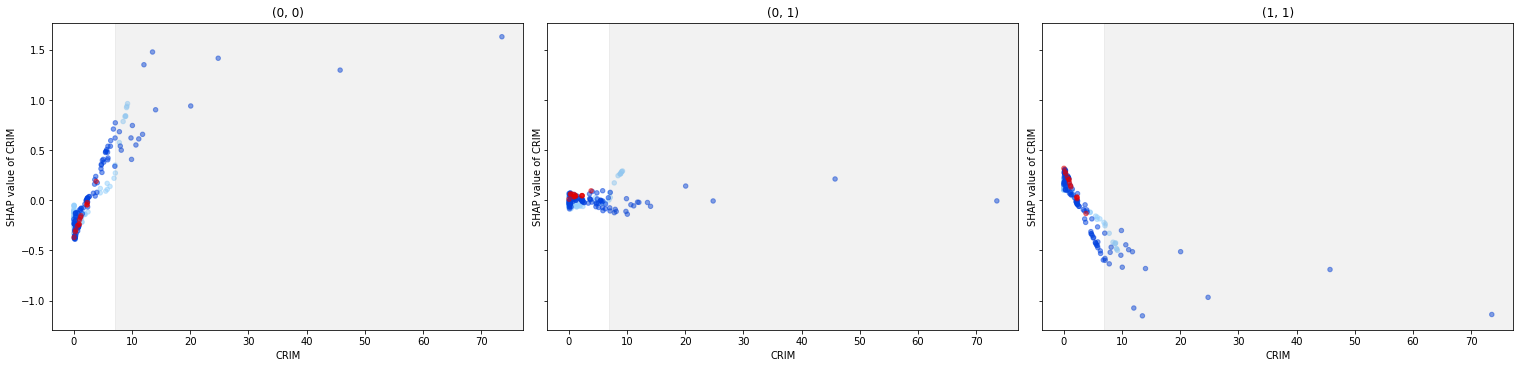

1.0 <= AGE
AGE <= 0.0 --> {'(0, 0)': 8, '(1, 0)': 5}


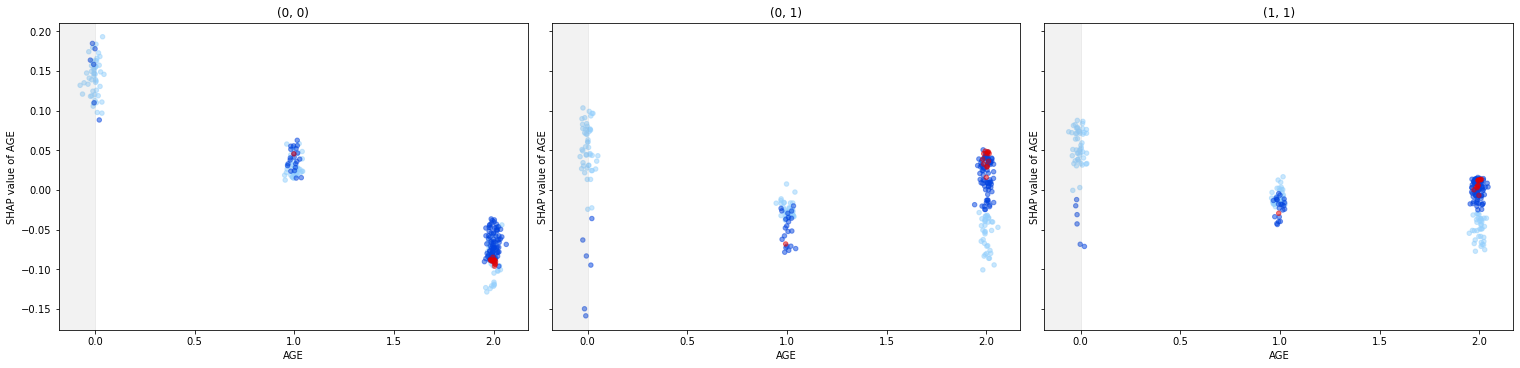

In [37]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

In [39]:
node.describe_feature('AGE')

0.0   1.0    2.0
global      55.0  61.0  130.0
local-all    6.0  22.0   94.0
local-diff   NaN   1.0   12.0

The differences are local to medium LSTAT values. For ZN, CRIM and AGE, they are within the majority of the values in the distribution. As such, these explanations may be insufficient.

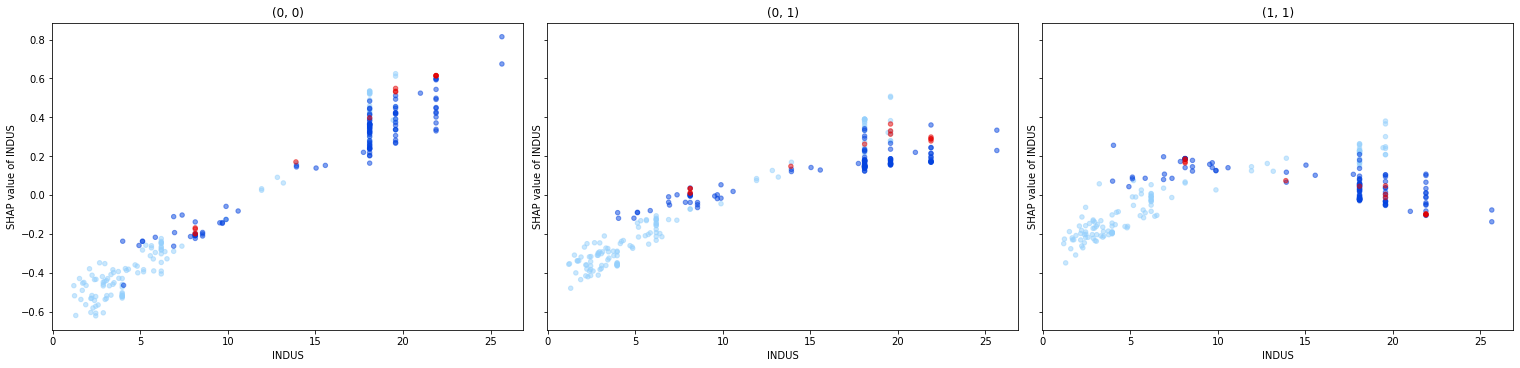

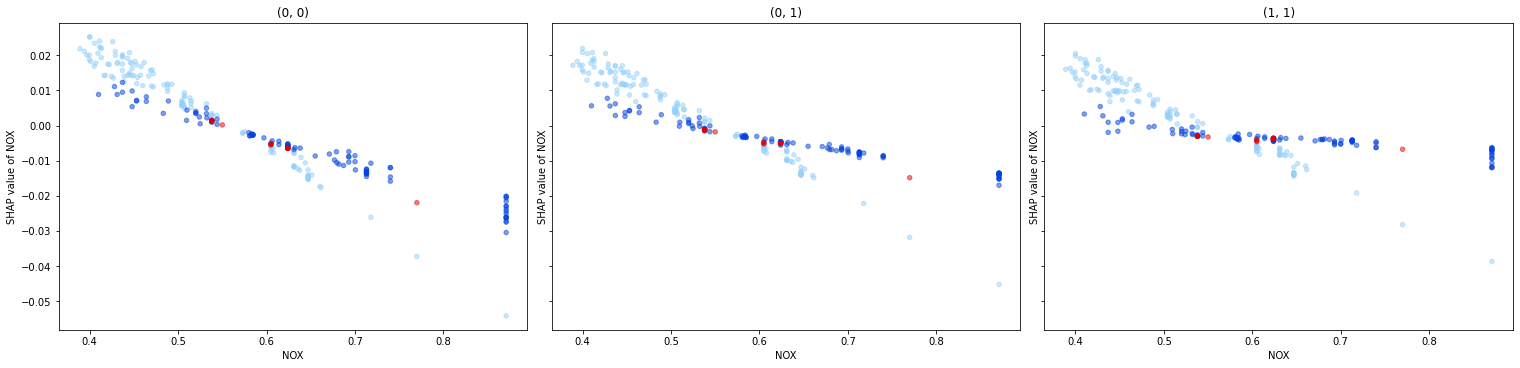

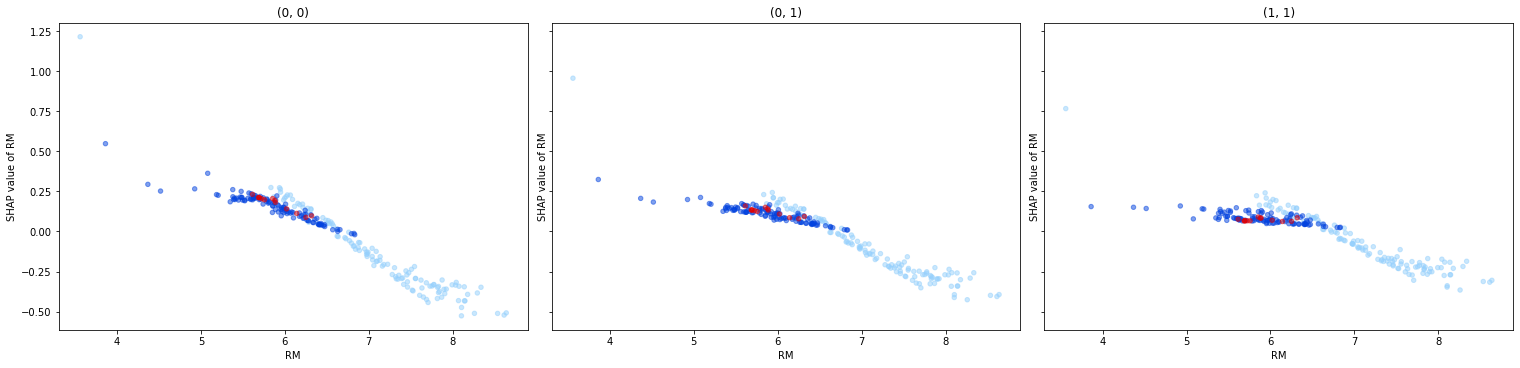

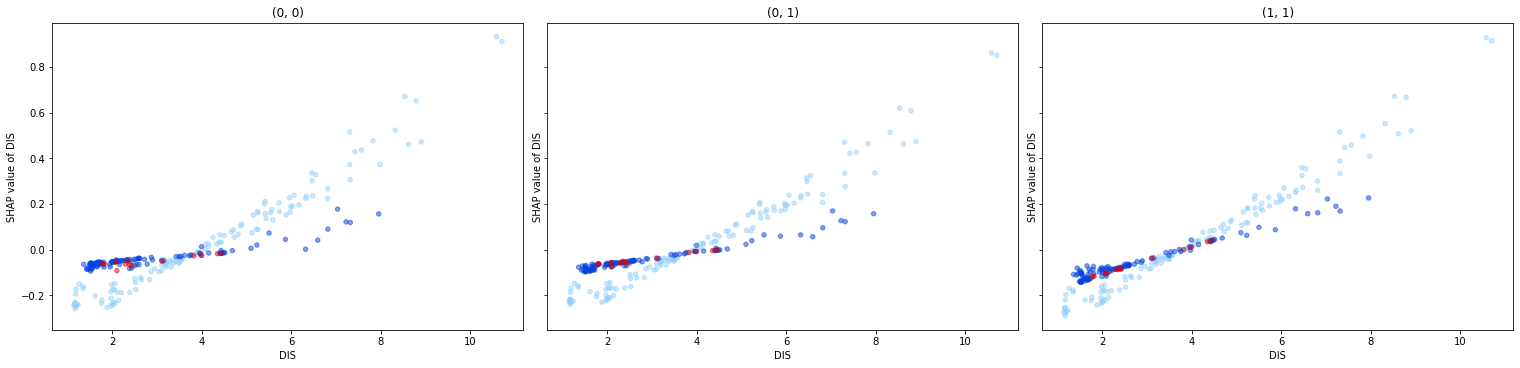

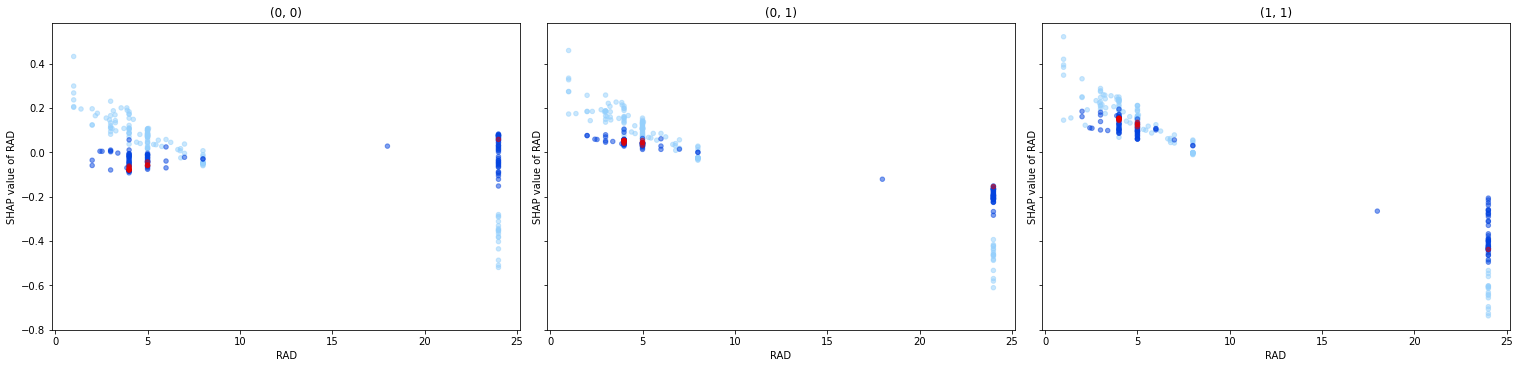

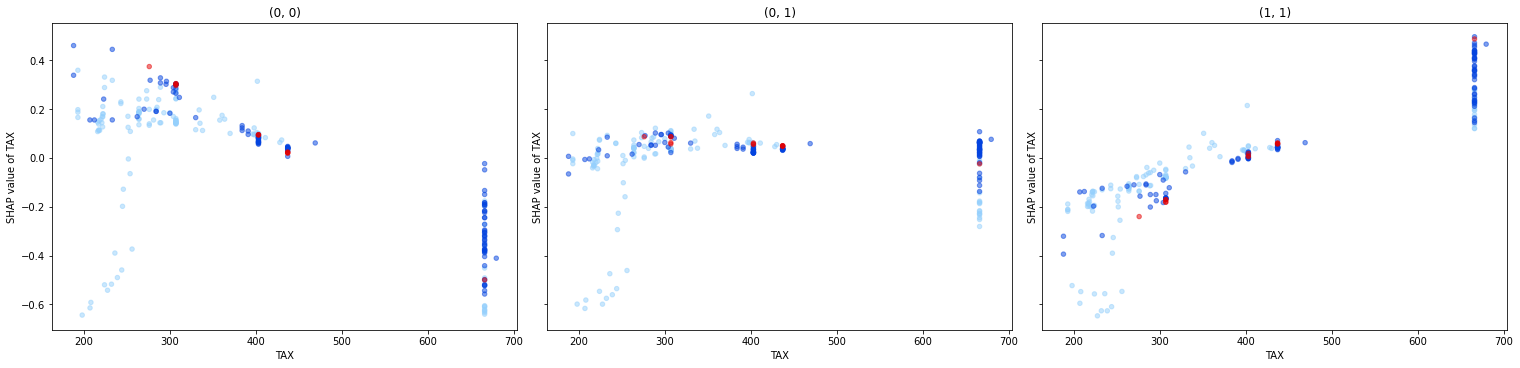

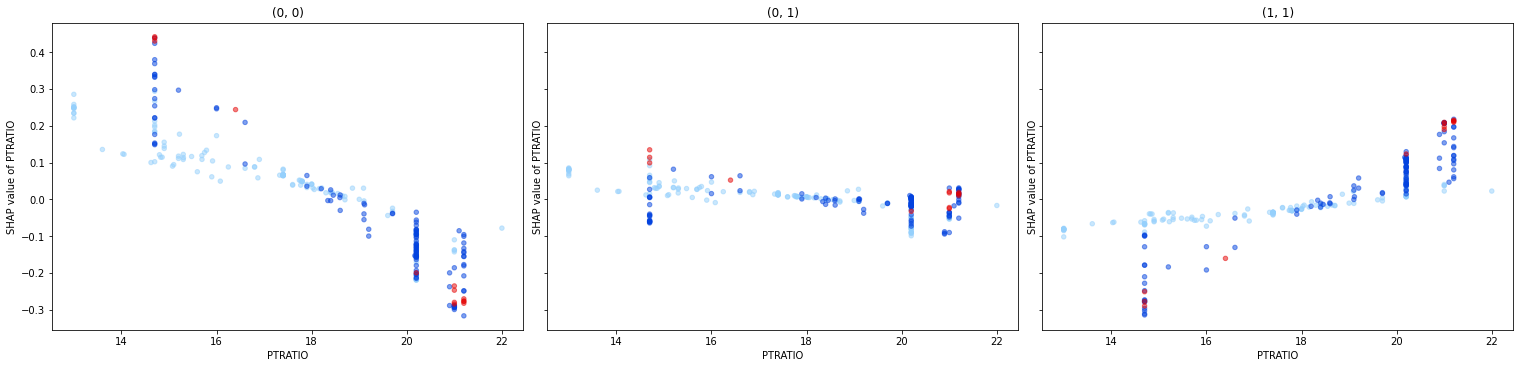

In [40]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature(feature, focus=node, alpha=0.5)

Checking the instances that have ZN=0, we can see that there are many which are in the LSTAT range of differences:

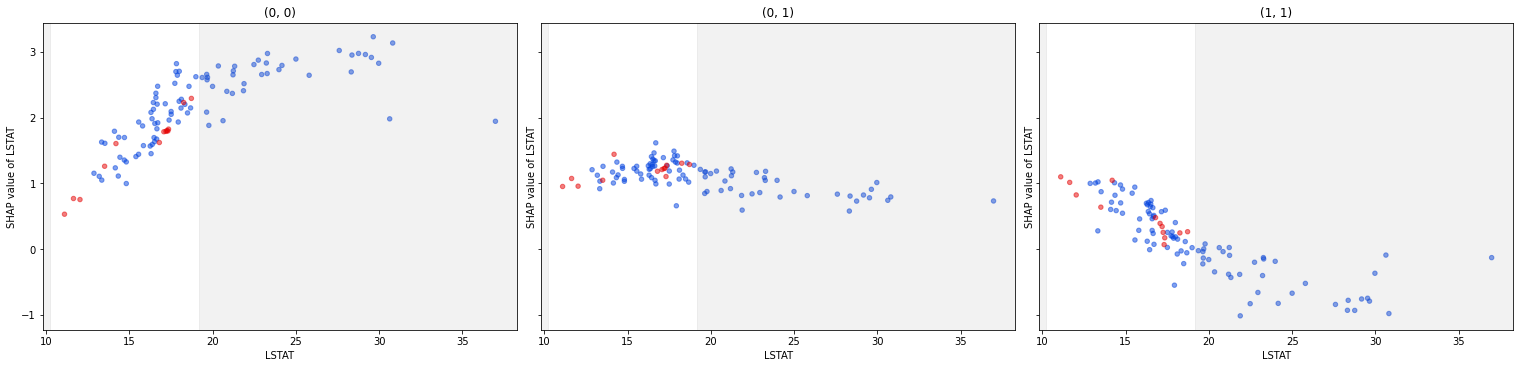

In [15]:
part = node.filter(node.shap_values[:, 'ZN'].data < 1)
part.plot_feature('LSTAT', alpha=0.5)

CRIM is also not a good explanation, because most instances are below the upper counterfactual.

### Node LLRRR

In [43]:
node = node.get_left()
node.class_counts, node.distance

((0, 0)    52
 (0, 1)     6
 dtype: int64,
 4.866857493786766)

In [45]:
node = node.get_right()
node.class_counts, node.distance

((0, 0)    35
 (0, 1)     6
 dtype: int64,
 4.334316644784891)

In [47]:
node = node.get_right()
node.class_counts, node.distance

((0, 0)    19
 (0, 1)     6
 dtype: int64,
 1.998952405991012)

In [49]:
node = node.get_right()
node.class_counts, node.distance

((0, 0)    8
 (0, 1)    6
 dtype: int64,
 1.8116858657052968)

In [50]:
node.get_left().class_counts

(0, 0)    2
(0, 1)    2
dtype: int64

These six instances are in the upper part of the LSTAT range of differences. The lower counterfactual is higher than the global one, even higher than other instances classified differently. ZN has particularly high influence on instances in this cluster, compared to other instances with ZN=0. Instances in this cluster have a low CRIM value and its counterfactual is lower as well. Especially the PTRATIO values are high, with a high counterfactual value as well. The rest still has rather extreme counterfactuals, possibly due to less extreme dependencies.

17.19 <= LSTAT <= 18.72
LSTAT <= 14.9 --> {'(1, 1)': 6}
LSTAT >= 18.95 --> {'(0, 0)': 6}


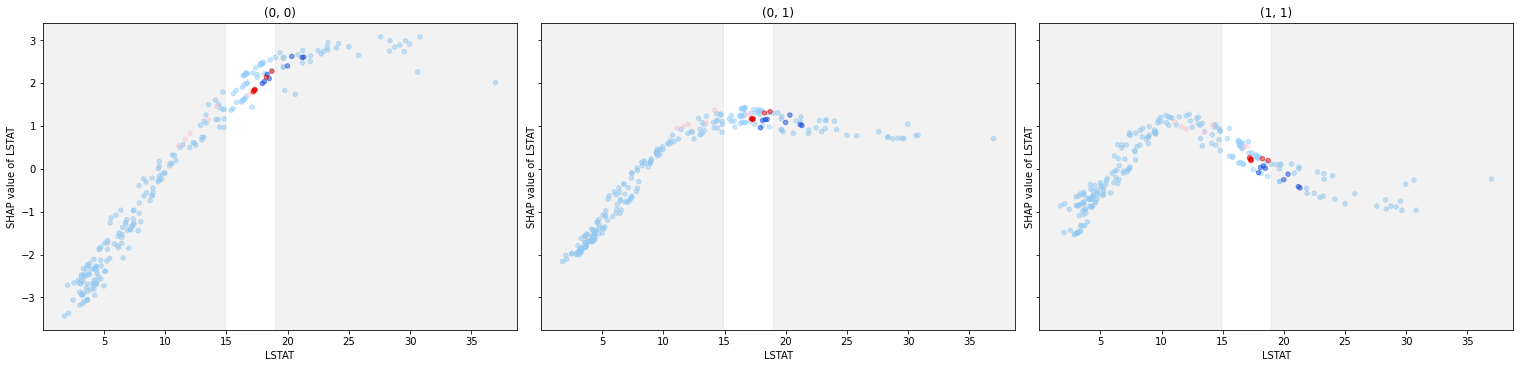

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 6}


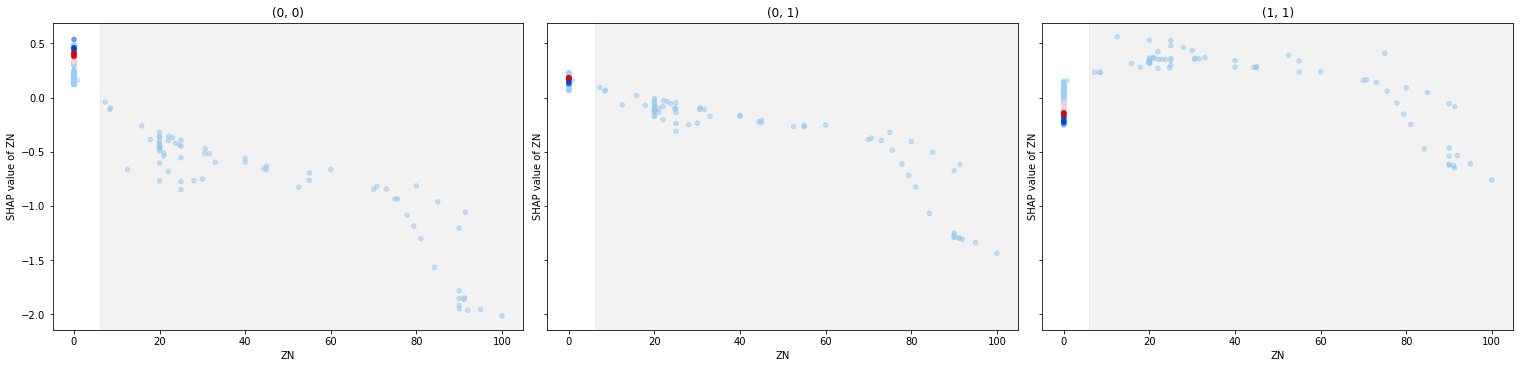

0.25915 <= CRIM <= 1.23247
CRIM >= 2.0 --> {'(0, 0)': 6}


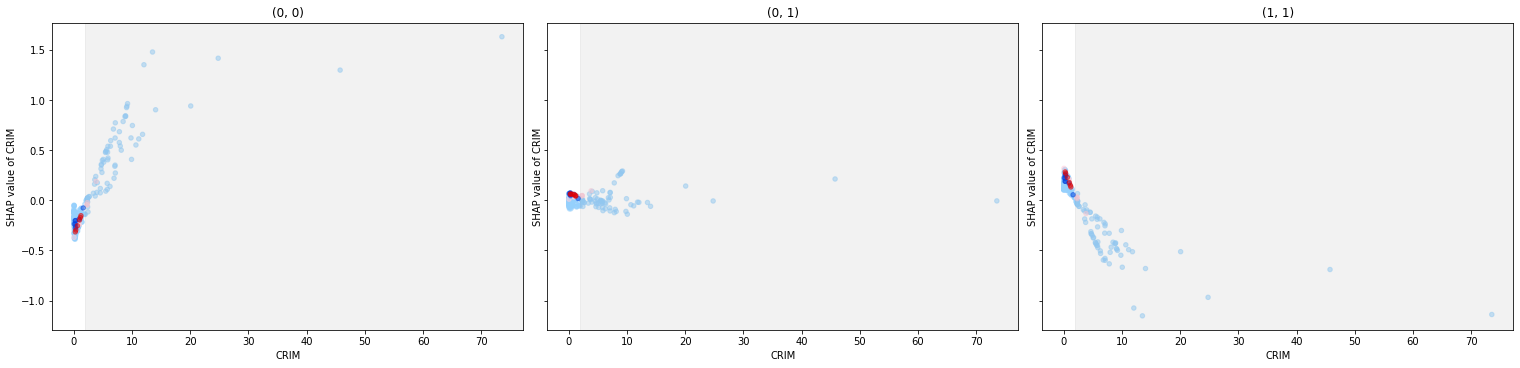

21.0 <= PTRATIO <= 21.2
PTRATIO <= 19.53 --> {'(0, 0)': 6}


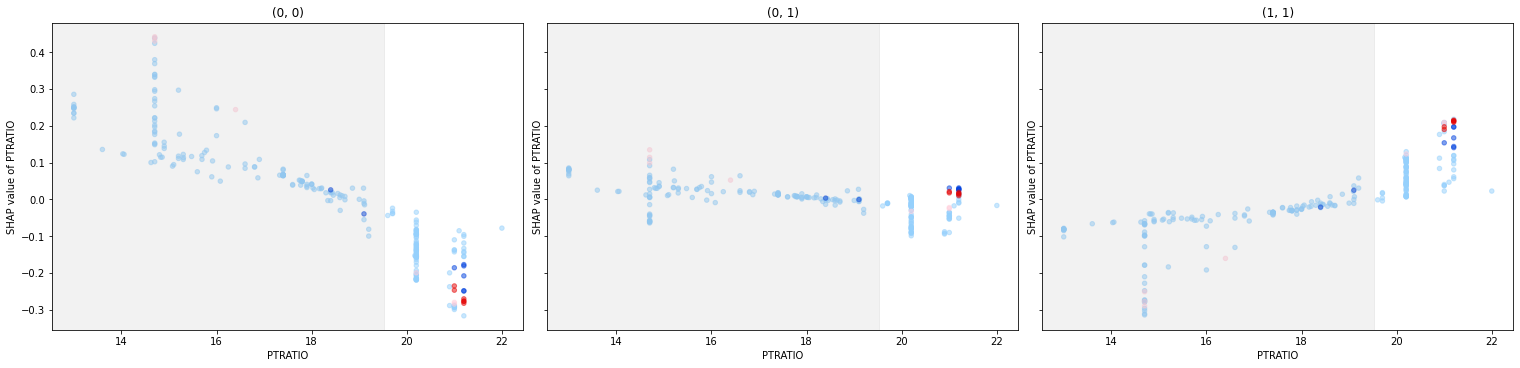

5.685294968854628 <= RM <= 6.142
RM <= 3.93 --> {'(0, 0)': 6}


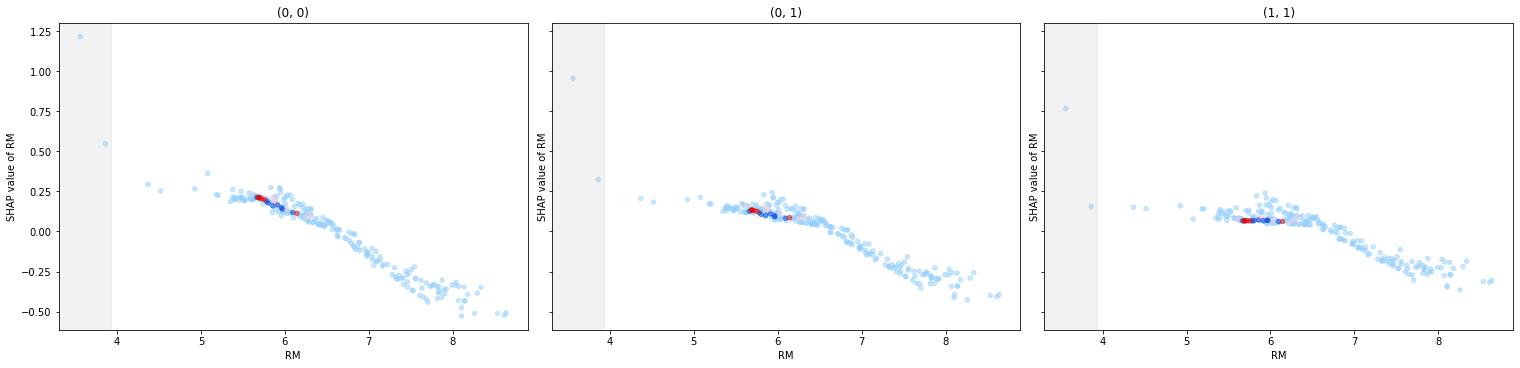

307.0 <= TAX <= 437.0
TAX <= 260.0 --> {'(0, 0)': 6}
TAX >= 619.0 --> {'(1, 1)': 6}


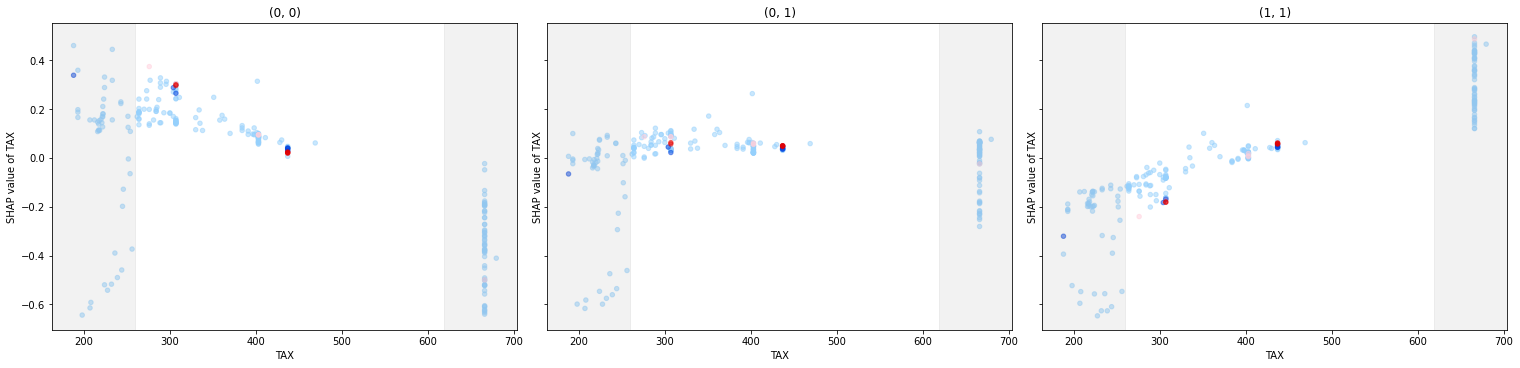

4.0 <= RAD <= 4.0
RAD >= 12.41 --> {'(0, 0)': 6}


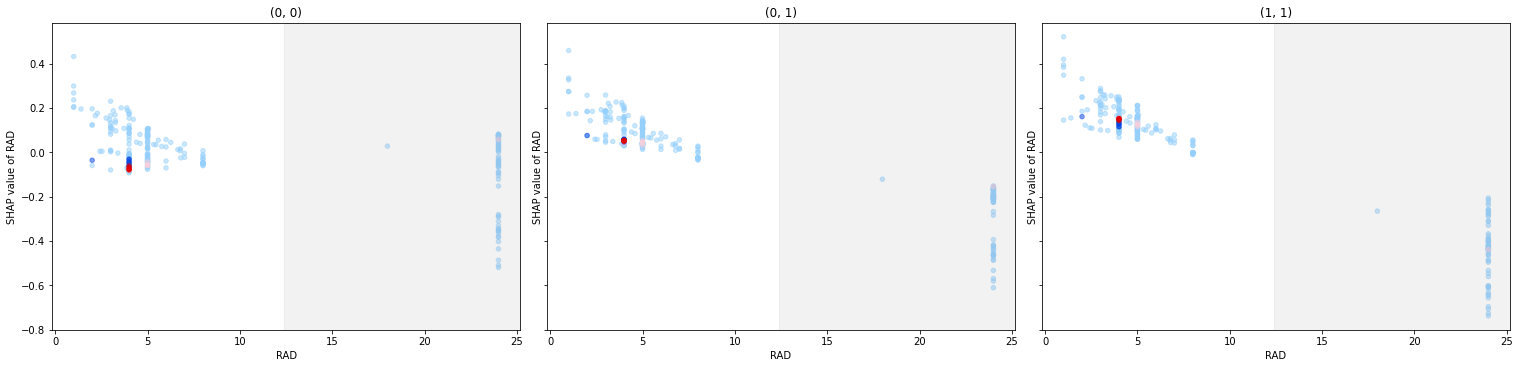

2.0 <= AGE
AGE <= 1.0 --> {'(0, 0)': 6}


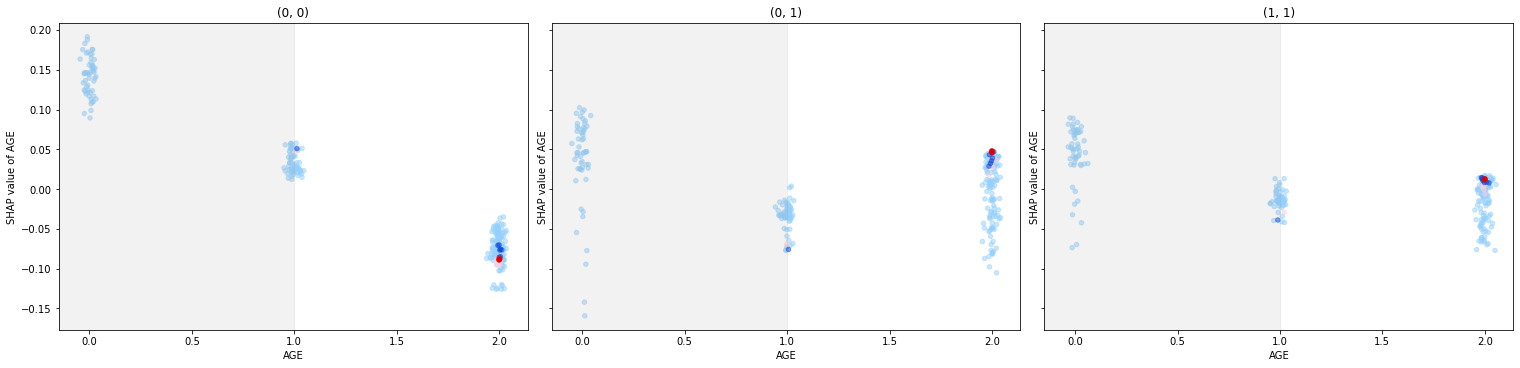

In [53]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

### Node LRR

In [55]:
node = node.root.get('LR')
node.class_counts, node.distance

((1, 1)    33
 (0, 0)    24
 (0, 1)     7
 dtype: int64,
 10.447696669851686)

In [57]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    33
 (0, 1)     7
 (0, 0)     4
 dtype: int64,
 6.309925804736736)

In [58]:
node.get_left().class_counts

(1, 1)    6
(0, 1)    1
dtype: int64

The distance of this cluster is much higher than the one of the previously explained cluster. It indicates, that the cluster is more diverse in terms of its influences.

The counterfactuals of LSTAT, ZN, CRIM and AGE are very similar to the global ones. Additionally we see a rather extreme counterfactual for INDUS, because the feature values of instances classified differently are in the upper 2/3. The PTRATIO counterfactual is even extremer.

To get more specific explanations, I will go down another level.

11.1 <= LSTAT <= 17.066695066513088
LSTAT <= 10.24 --> {'(1, 1)': 7}
LSTAT >= 19.17 --> {'(0, 0)': 7}


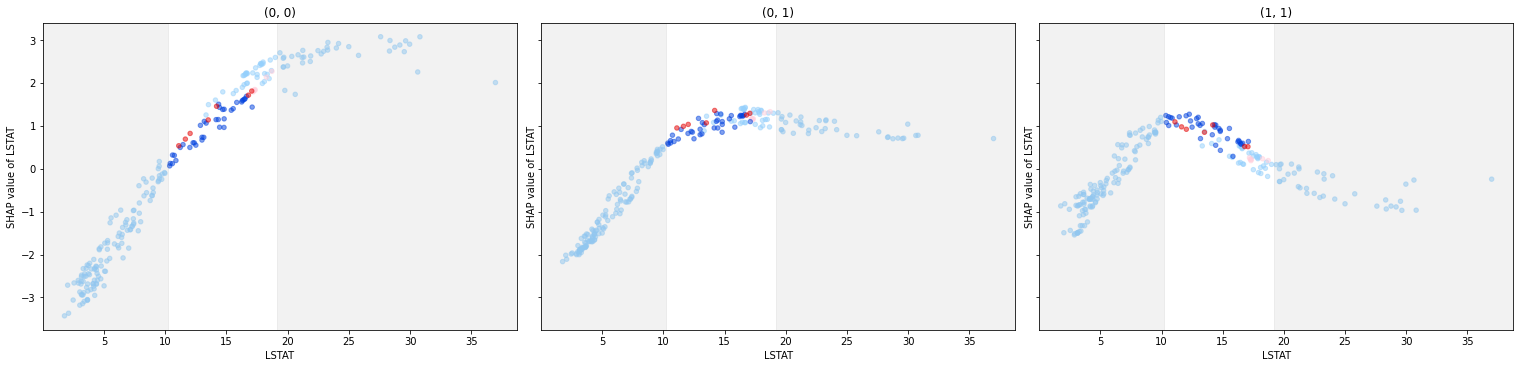

ZN <= 0.0
ZN >= 5.0 --> {'(1, 1)': 7}


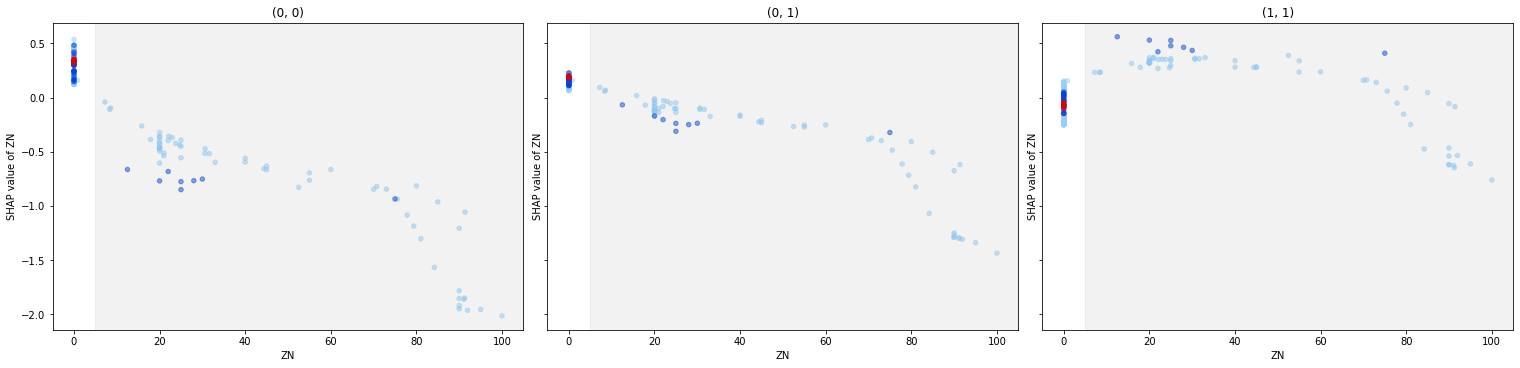

8.14 <= INDUS <= 19.58
INDUS <= 7.25 --> {'(1, 1)': 7}


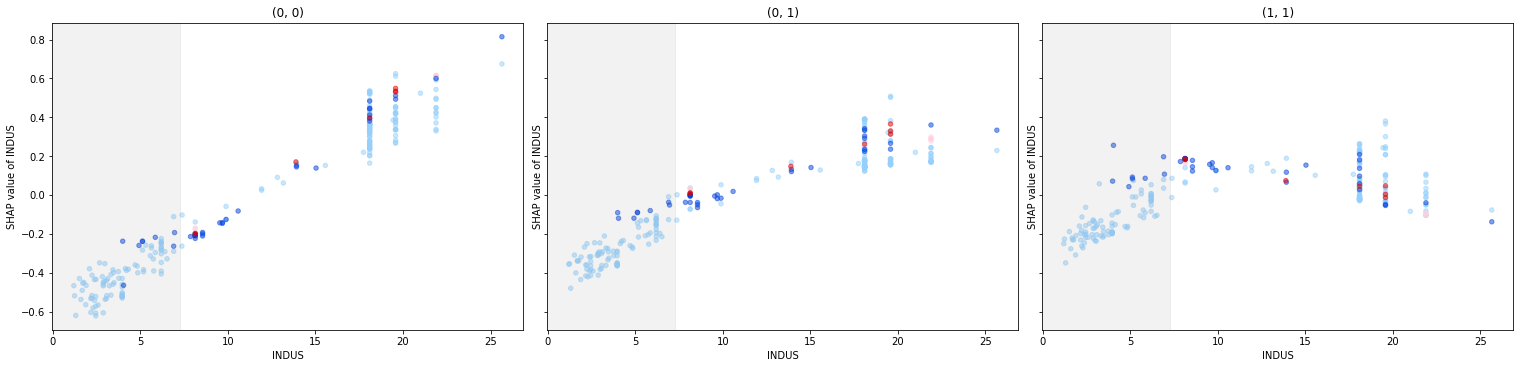

0.0456 <= CRIM <= 3.83684
CRIM >= 7.0 --> {'(0, 0)': 7}


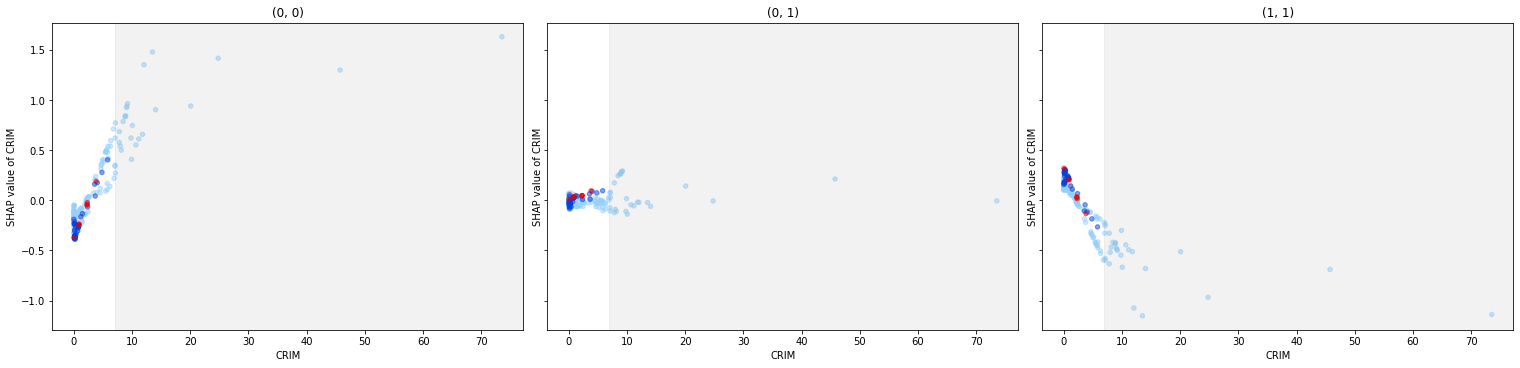

14.7 <= PTRATIO <= 21.0
PTRATIO >= 21.37 --> {'(1, 1)': 7}


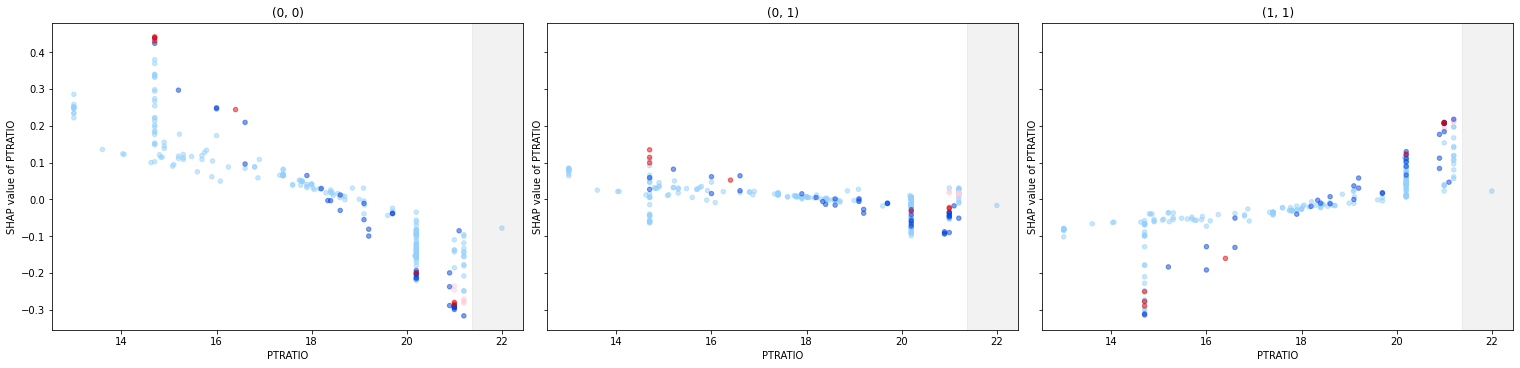

1.0 <= AGE
AGE <= 0.0 --> {'(1, 0)': 5, '(0, 0)': 2}


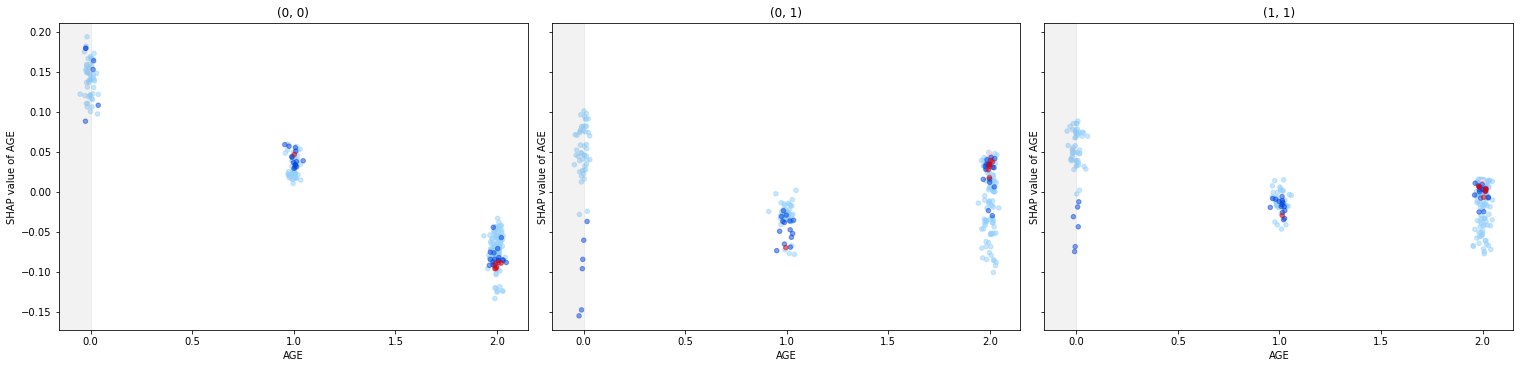

In [61]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

### Node LRRL

In [63]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    6
 (0, 1)    1
 dtype: int64,
 2.6069301038297836)

Now there's only one instance classified differently left to explain.

LSTAT is in the middle of the parent cluster's range. Its counterfactuals are closer to the instance. Yet the lower counterfactual is very close, while the upper counterfactual is not so close. TAX is the second most important feature locally, showing that instances in this cluster have very high feature values. The lower counterfactual is very high. The INDUS values are high too, but there are higher values present in the parent cluster. RAD is also very high for this cluster. ZN is ranked lower, but has a very low upper counterfactual. Interestingly, CRIM is now rather high and even has a lower counterfactual.

14.19 <= LSTAT <= 14.19
LSTAT <= 13.9 --> {'(1, 1)': 1}
LSTAT >= 16.13 --> {'(0, 0)': 1}


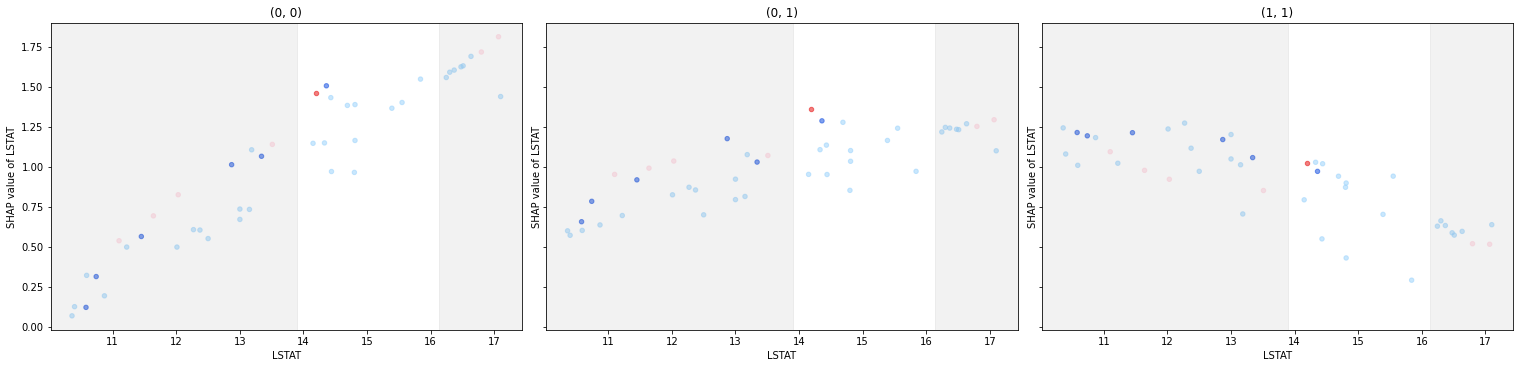

666.0 <= TAX <= 666.0
TAX <= 499.0 --> {'(0, 0)': 1}


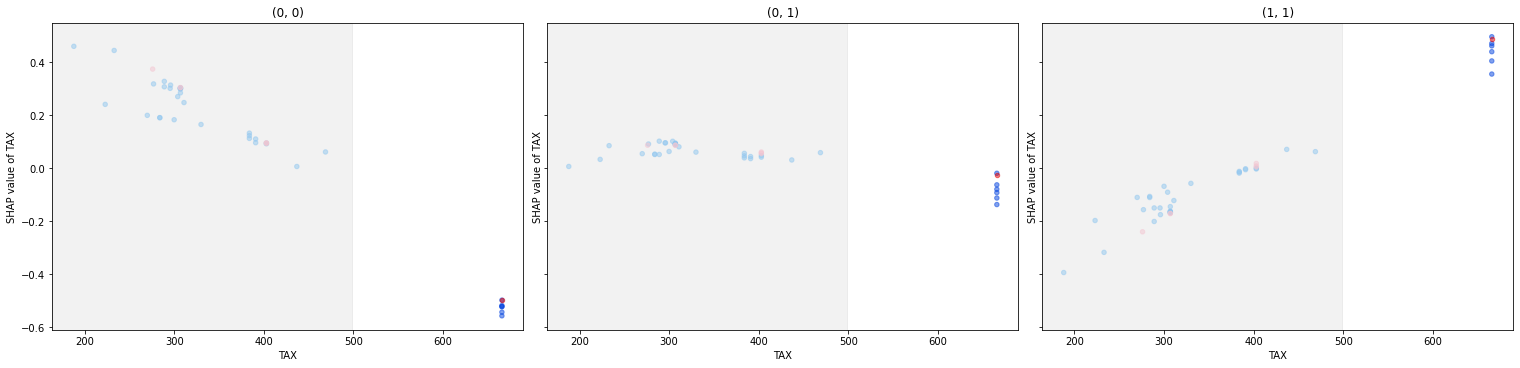

18.1 <= INDUS <= 18.1
INDUS <= 16.87 --> {'(1, 1)': 1}


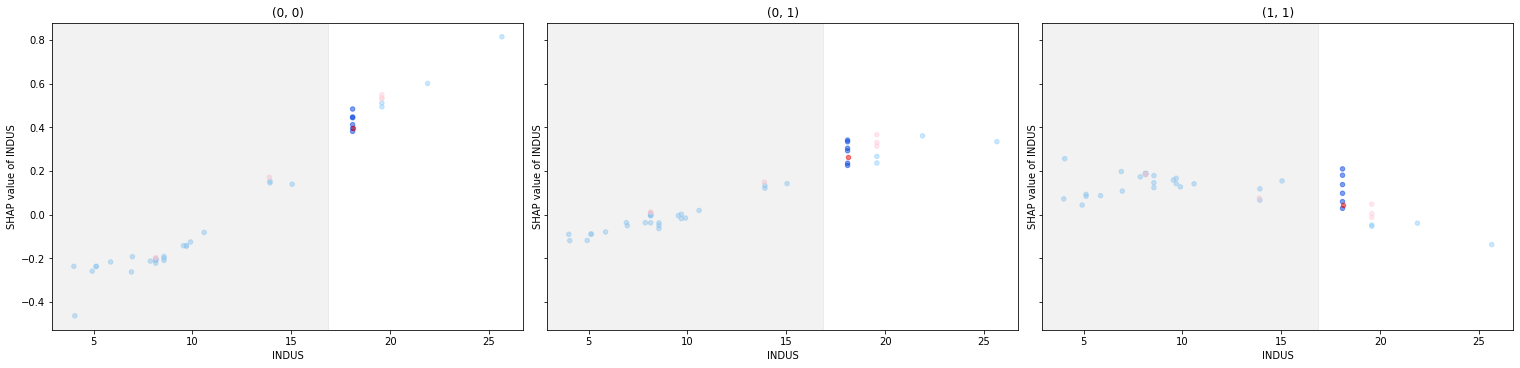

24.0 <= RAD
RAD <= 21.4 --> {'(1, 1)': 1}


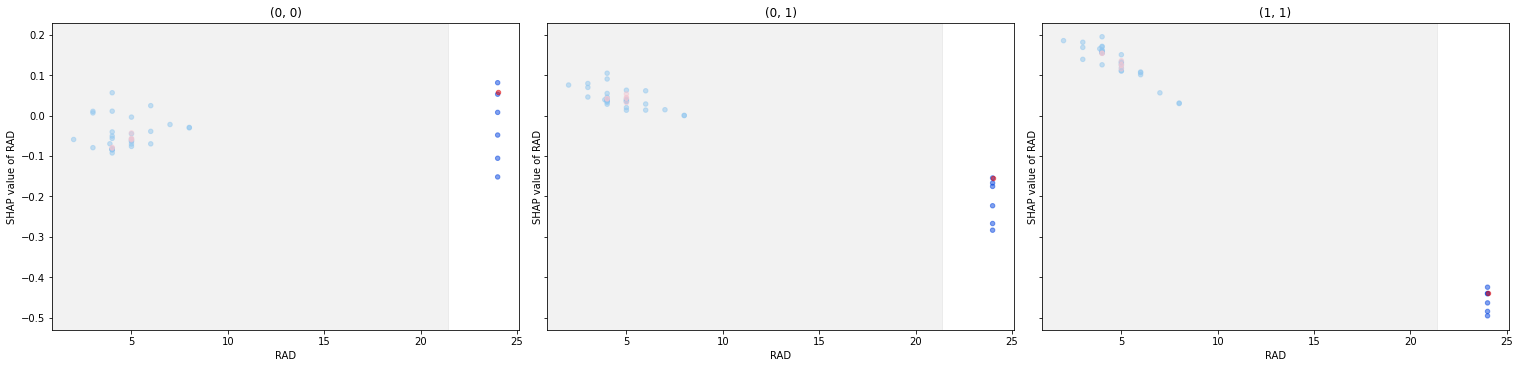

ZN <= 0.0
ZN >= 1.0 --> {'(1, 1)': 1}


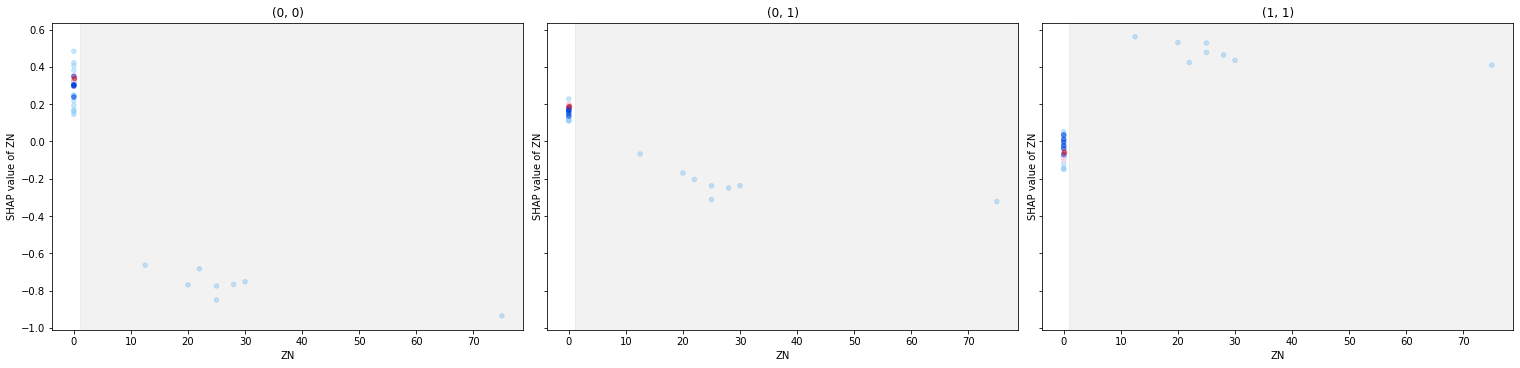

20.2 <= PTRATIO <= 20.2
PTRATIO <= 16.71 --> {'(0, 0)': 1}
PTRATIO >= 20.74 --> {'(1, 1)': 1}


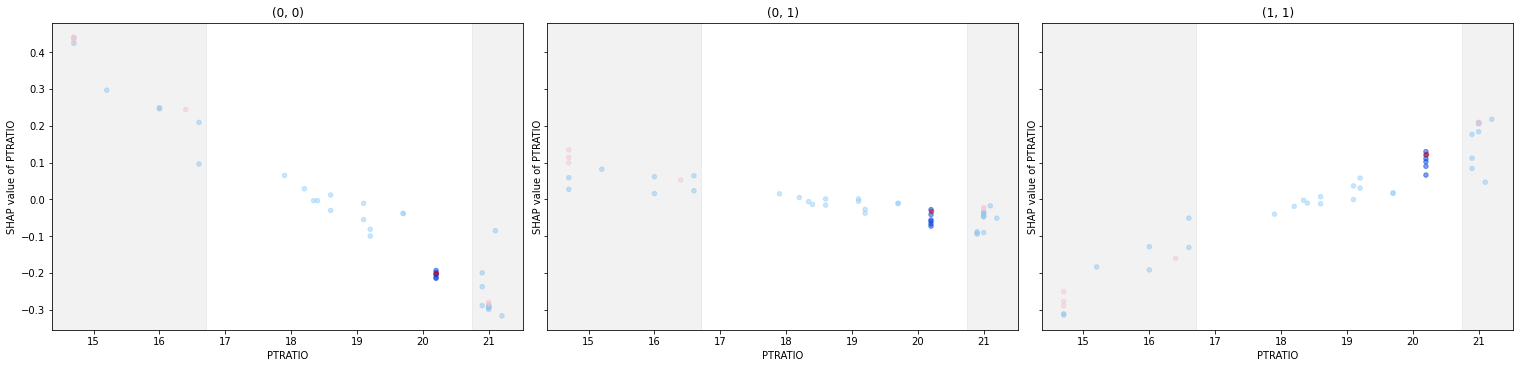

3.83684 <= CRIM <= 3.83684
CRIM <= 3.0 --> {'(1, 1)': 1}
CRIM >= 7.0 --> {'(0, 0)': 1}


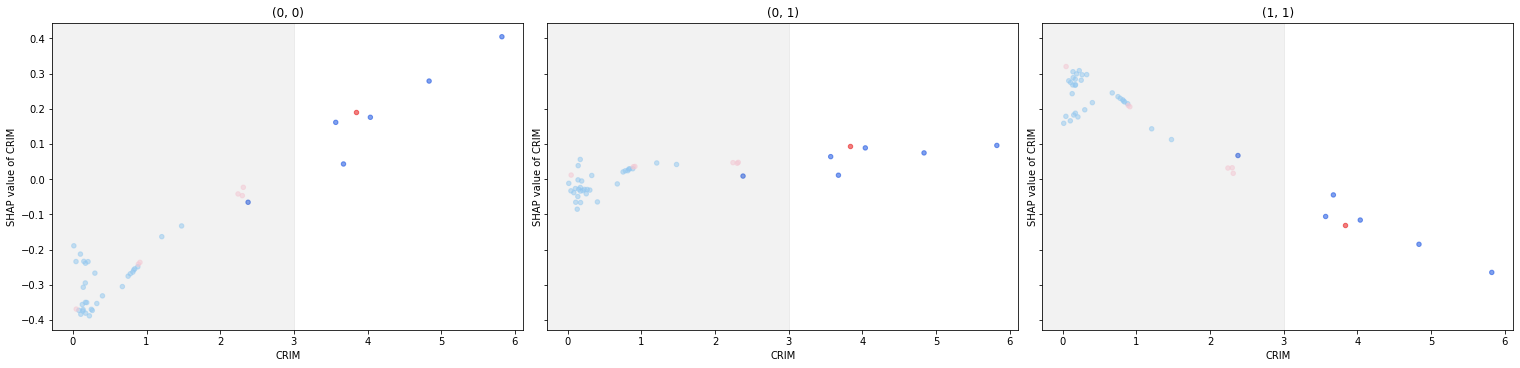

6.251 <= RM <= 6.251
RM >= 6.74 --> {'(1, 1)': 1}


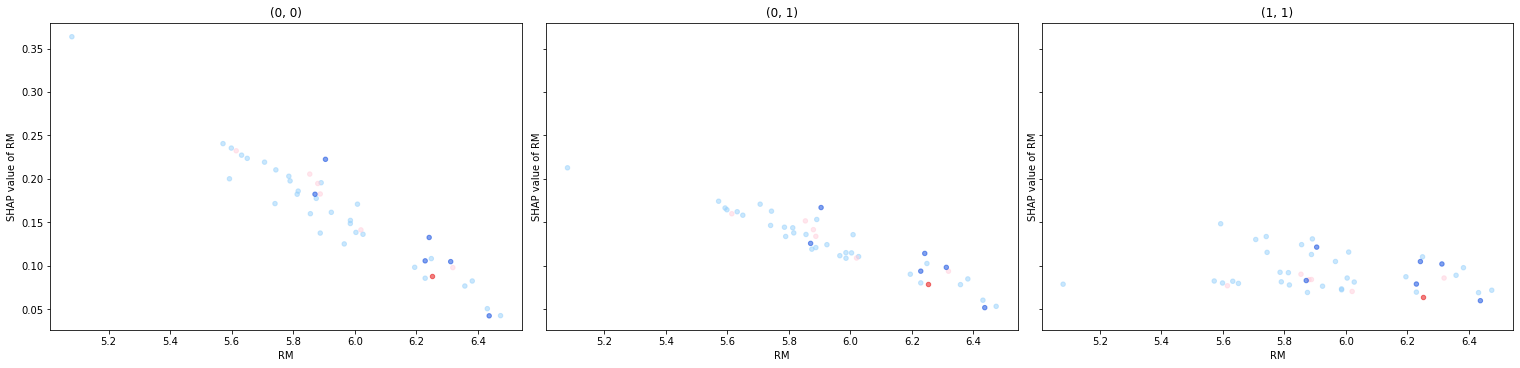

2.0 <= AGE
AGE <= 1.0 --> {'(1, 1)': 1}


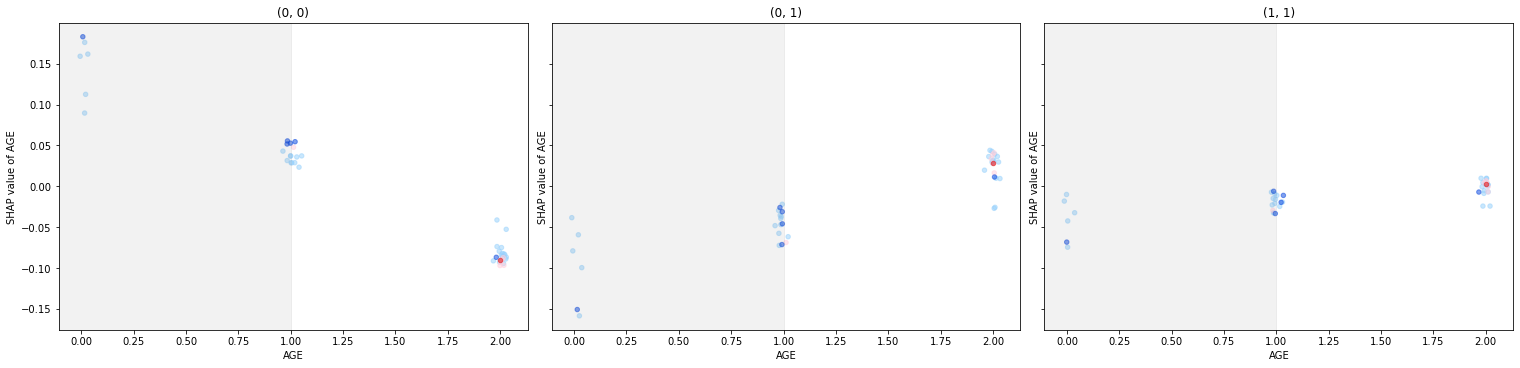

2.2955 <= DIS <= 2.2955
DIS >= 4.73 --> {'(1, 1)': 1}


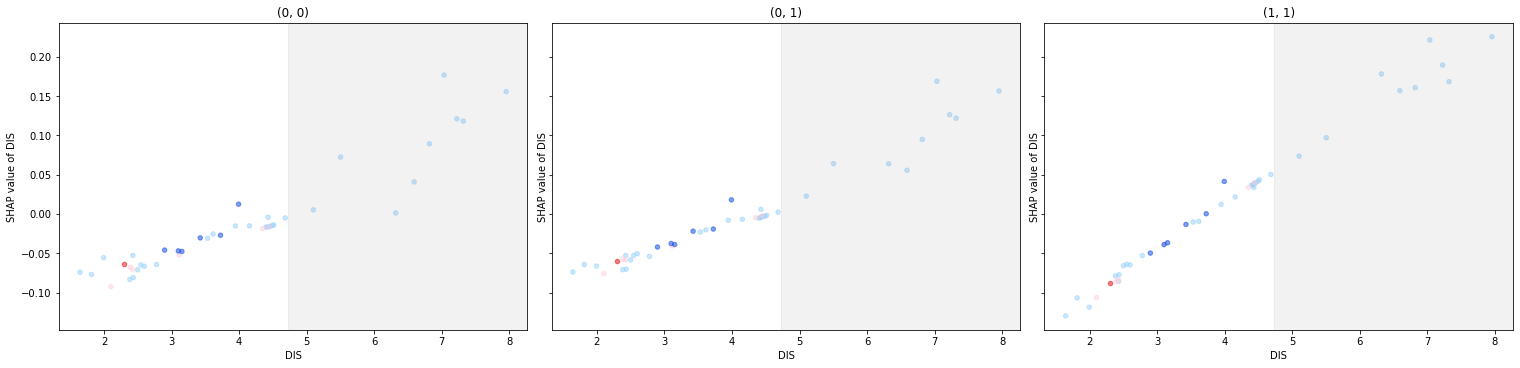

In [67]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

### Node LRRRR

In [69]:
node = node.parent.get_right()
node.class_counts, node.distance

((1, 1)    27
 (0, 1)     6
 (0, 0)     4
 dtype: int64,
 5.239166439717542)

In [70]:
node.get_left().class_counts

(1, 1)    12
(0, 0)     4
(0, 1)     3
dtype: int64

Since the distance is still rather high for this cluster, and the child nodes would split the instances classified differently in two halfs, I will go down one level again before creating explanations.

### Node LRRRLR

In [75]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    12
 (0, 0)     4
 (0, 1)     3
 dtype: int64,
 2.570808631770773)

In [77]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    11
 (0, 1)     3
 (0, 0)     1
 dtype: int64,
 1.3659596012574418)

In [78]:
node.get_left().class_counts

(0, 0)    1
(1, 1)    1
(0, 1)    1
dtype: int64

LSTAT still covers a broad range of SHAP values for instances classified differently. Counterfactuals for the higher values and the lower values might be closer to the instances. Besides, CRIM and ZN have similar explanations as on the global level. But TAX has only medium feature values, and an upper counterfactual.

13.51 <= LSTAT <= 17.066695066513088
LSTAT <= 13.14 --> {'(1, 1)': 3}
LSTAT >= 19.17 --> {'(0, 0)': 3}


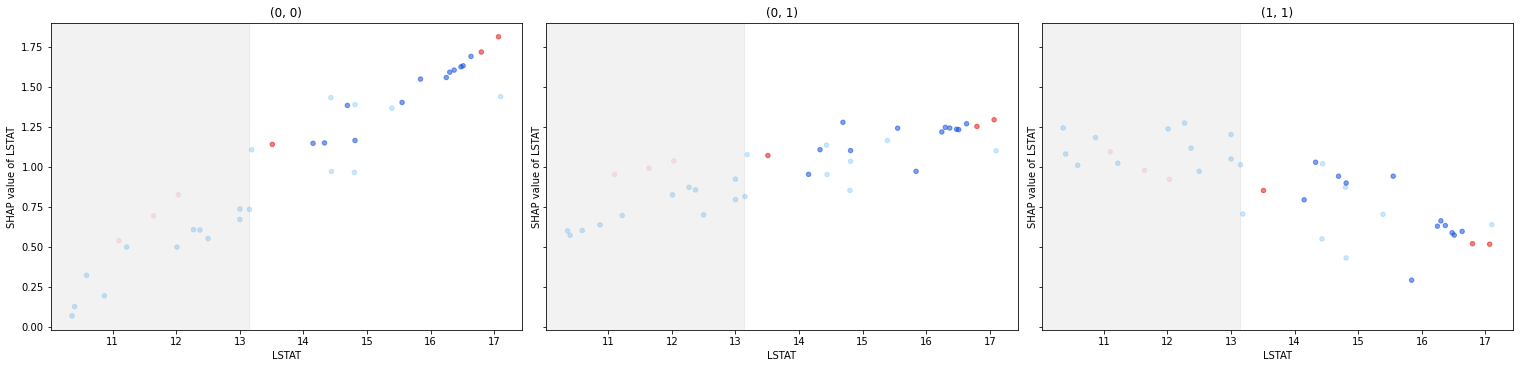

0.0456 <= CRIM <= 0.9110390848154124
CRIM >= 4.0 --> {'(0, 0)': 3}


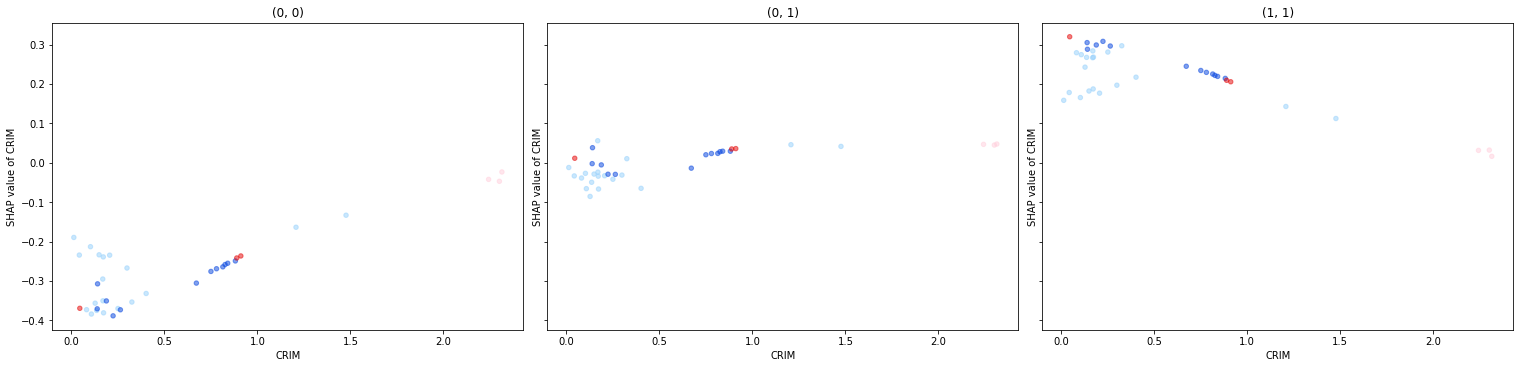

ZN <= 0.0
ZN >= 1.0 --> {'(1, 1)': 3}


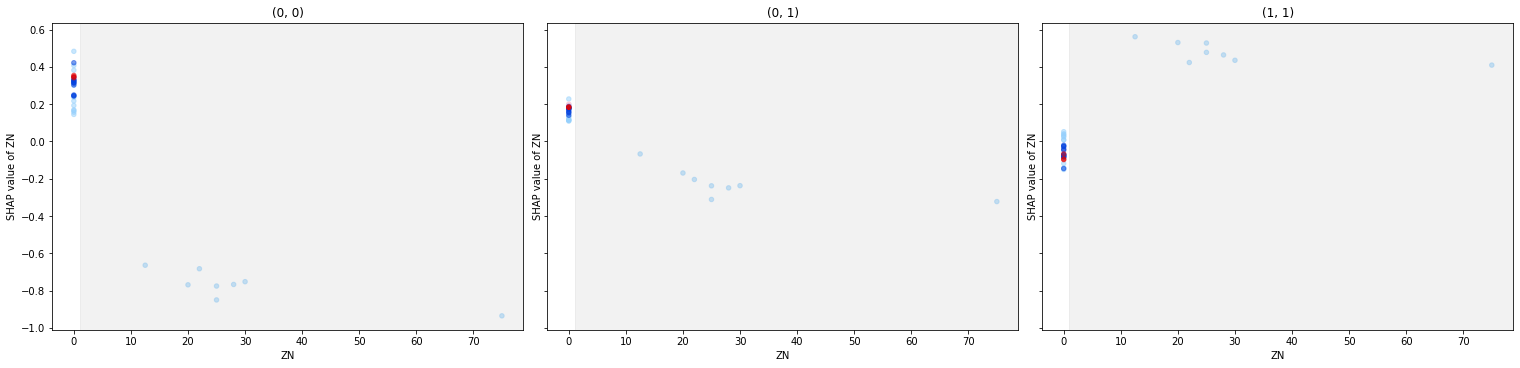

276.0 <= TAX <= 307.0
TAX >= 324.0 --> {'(1, 1)': 3}


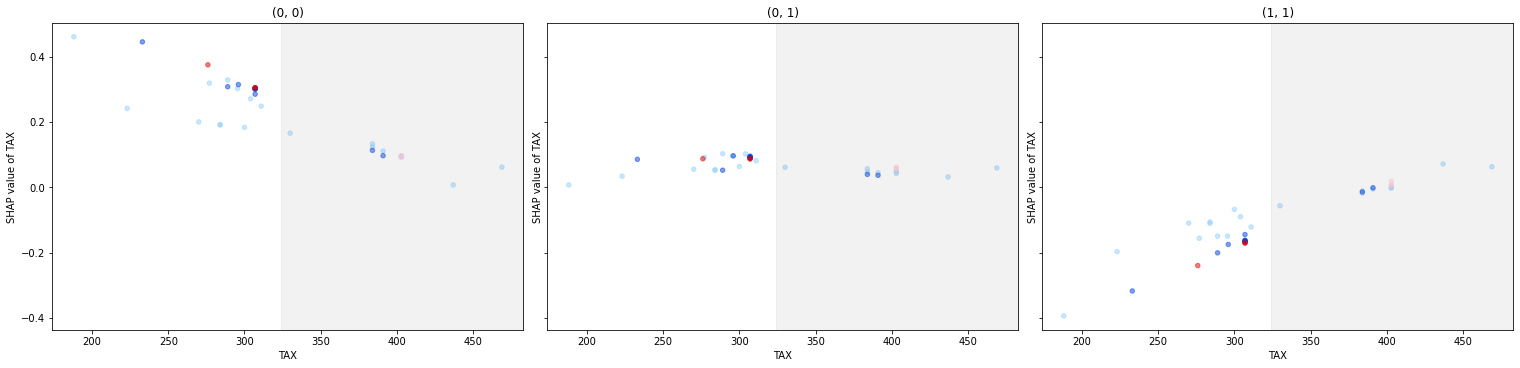

In [86]:
for feature in node.feature_names_relevant[:4]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

13.51 <= LSTAT <= 13.51
LSTAT <= 13.14 --> {'(1, 1)': 1}
LSTAT >= 14.1 --> {'(0, 0)': 1}


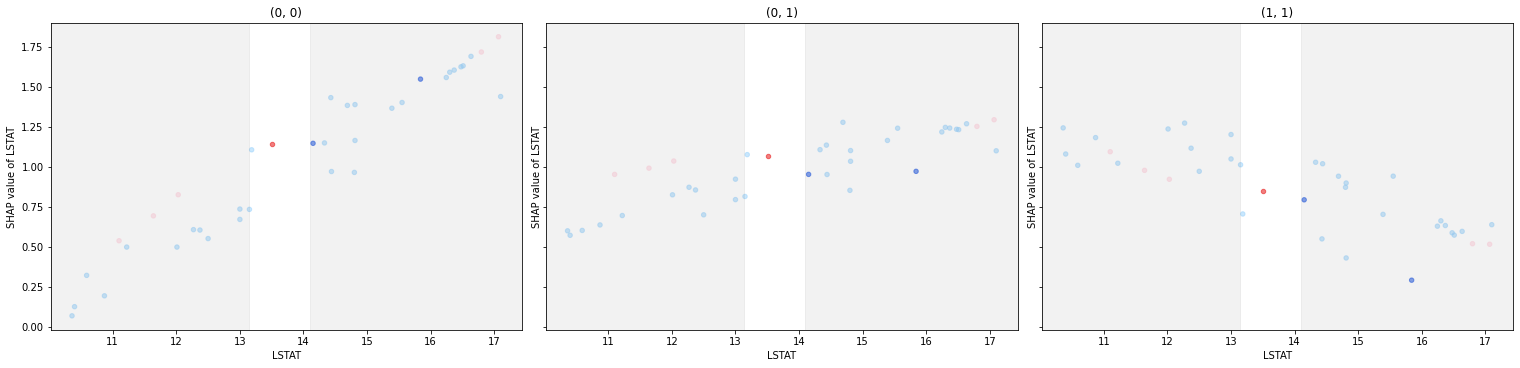

In [84]:
child = node.get_left()
child.describe_feature_differences('LSTAT')
child.describe_counterfactuals('LSTAT')
node.parent.parent.plot_feature('LSTAT', focus=child, alpha=0.5)

16.79698376047181 <= LSTAT <= 17.066695066513088
LSTAT <= 16.63 --> {'(1, 1)': 2}
LSTAT >= 19.17 --> {'(0, 0)': 2}


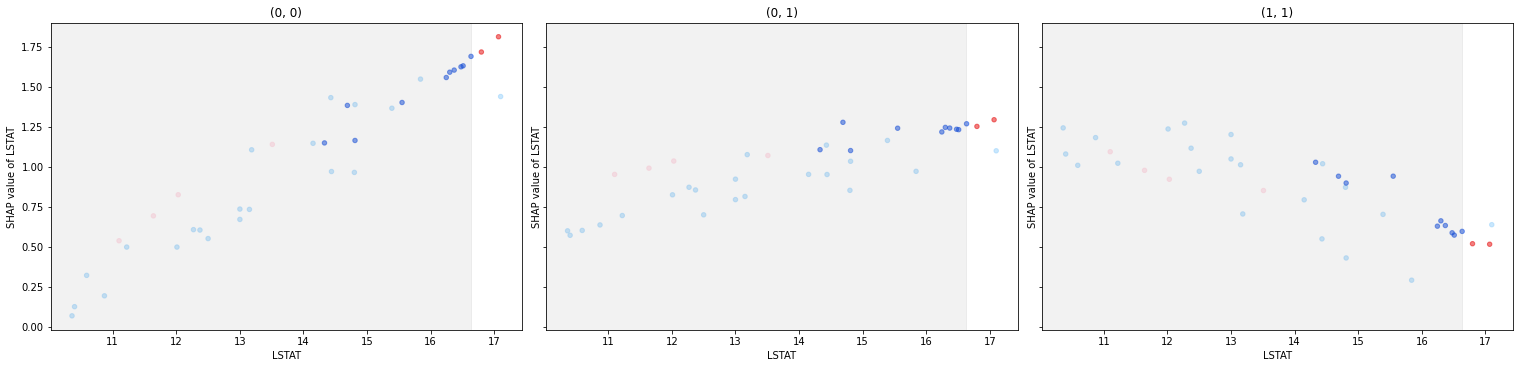

In [85]:
child = node.get_right()
child.describe_feature_differences('LSTAT')
child.describe_counterfactuals('LSTAT')
node.parent.parent.plot_feature('LSTAT', focus=child, alpha=0.5)

This confirms the theory, that LSTAT differences are local and flip easily when LSTAT is increased or decreased a bit.

### Node LRRRRL

In [87]:
node = node.parent.parent.get_right()
node.class_counts, node.distance

((1, 1)    15
 (0, 1)     3
 dtype: int64,
 3.7188517151243414)

In [89]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    7
 (0, 1)    3
 dtype: int64,
 2.027945845816267)

In [90]:
node.get_left().class_counts

(0, 1)    3
dtype: int64

11.1 <= LSTAT <= 12.03
LSTAT <= 10.24 --> {'(1, 1)': 3}
LSTAT >= 13.14 --> {'(0, 0)': 3}


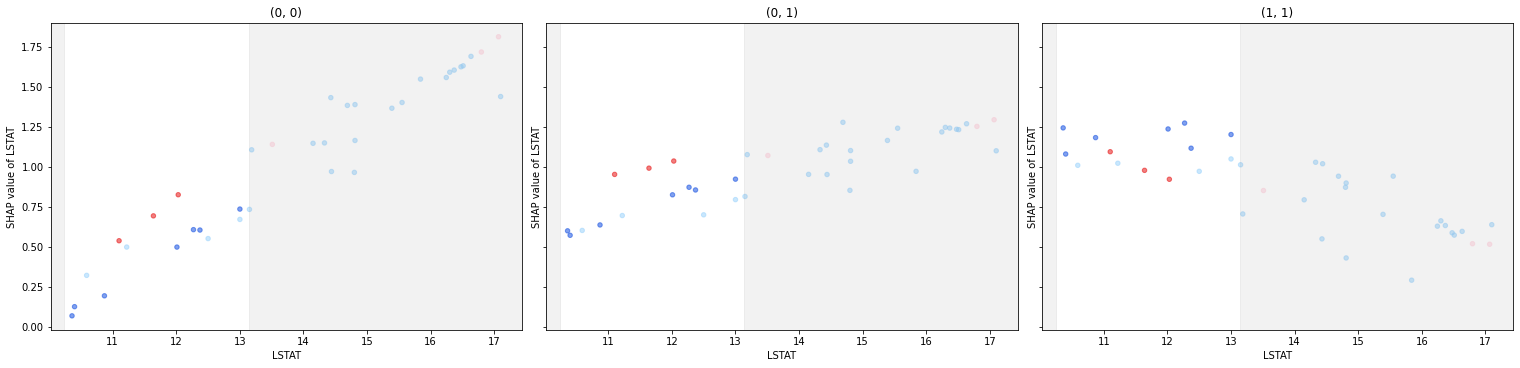

19.58 <= INDUS <= 19.58
INDUS <= 12.03 --> {'(1, 1)': 3}


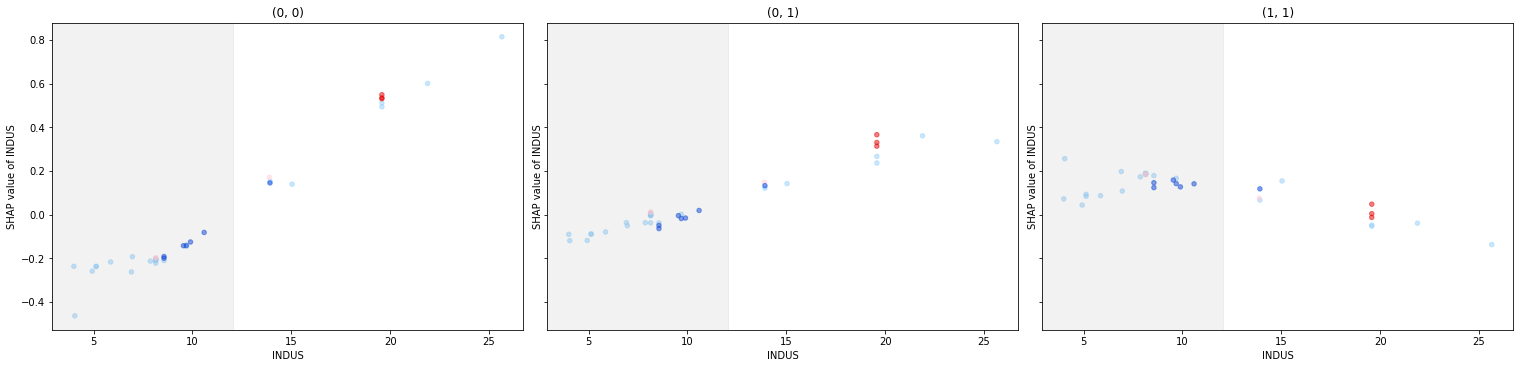

2.24236 <= CRIM <= 2.3139
CRIM <= 0.0 --> {'(1, 1)': 3}
CRIM >= 5.0 --> {'(0, 0)': 3}


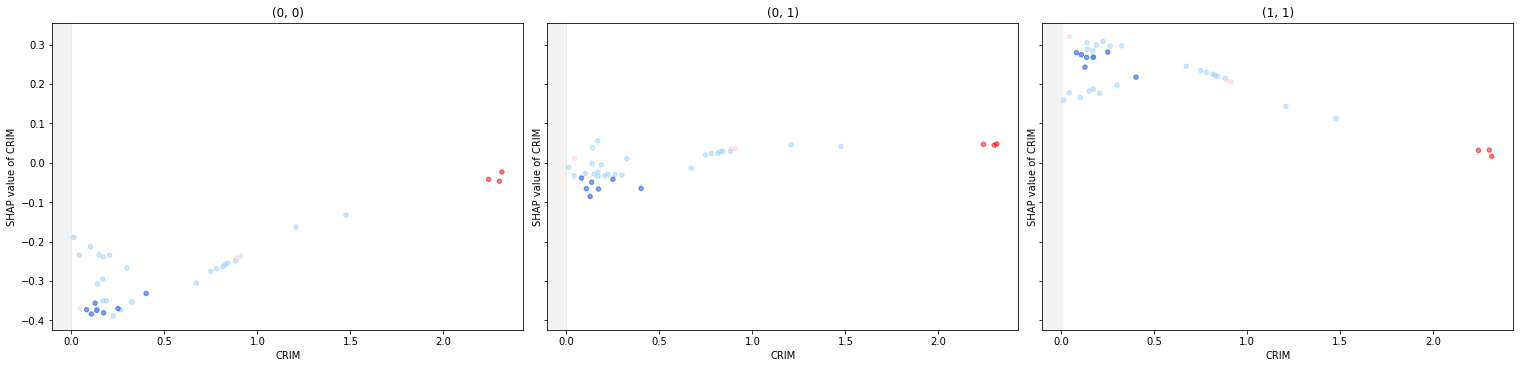

In [92]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

## Clustering of Class $(1,2)$ SHAP Values

In [93]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds,
                          '(1, 2)', ['(1, 1)', '(1, 2)', '(2, 2)'],
                          categorical_features=categorical_features,
                          feature_precisions=feature_precisions)

### Node RLR

In [94]:
node.class_counts, node.distance

((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 58.973744309154846)

In [96]:
node = node.get_left()
node.class_counts, node.distance

((2, 2)    95
 (1, 1)    11
 (2, 1)     2
 (1, 2)     1
 dtype: int64,
 16.72325606421616)

In [98]:
node = node.get_right()
node.class_counts, node.distance

((2, 2)    33
 (1, 1)    11
 (2, 1)     2
 (1, 2)     1
 dtype: int64,
 11.740769553574063)

In [100]:
node = node.get_right()
node.class_counts, node.distance

((2, 2)    22
 (1, 1)    11
 (2, 1)     1
 (1, 2)     1
 dtype: int64,
 7.630835034560041)

In [102]:
node = node.get_right()
node.class_counts, node.distance

((2, 2)    22
 (1, 1)     6
 (2, 1)     1
 (1, 2)     1
 dtype: int64,
 5.557885747329782)

In [104]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    6
 (1, 2)    1
 (2, 1)    1
 dtype: int64,
 2.946606650979263)

6.15 <= LSTAT <= 6.15
LSTAT <= 4.51 --> {'(2, 2)': 1}
LSTAT >= 6.28 --> {'(1, 1)': 1}


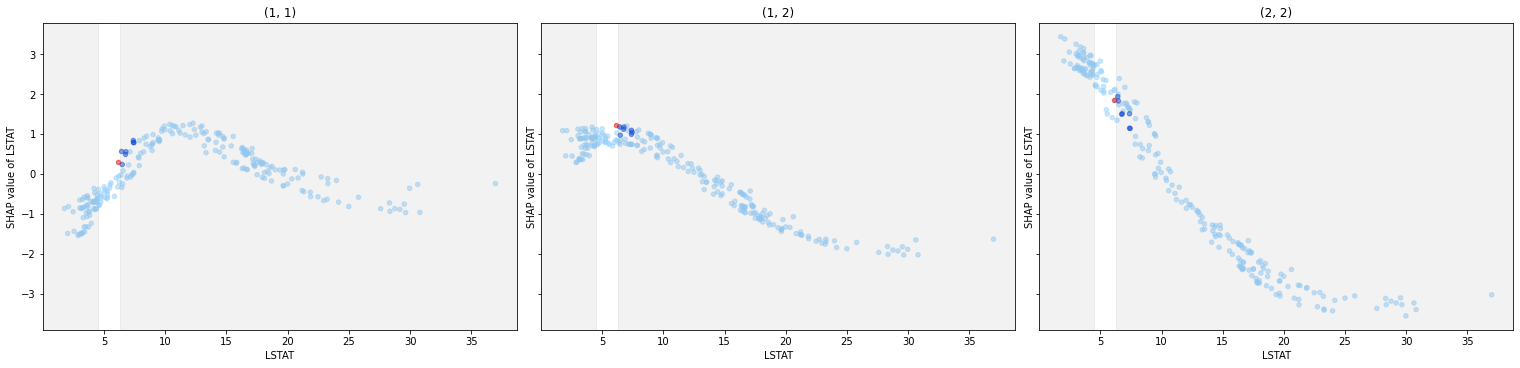

7.38 <= INDUS <= 7.38
INDUS >= 8.15 --> {'(1, 1)': 1}


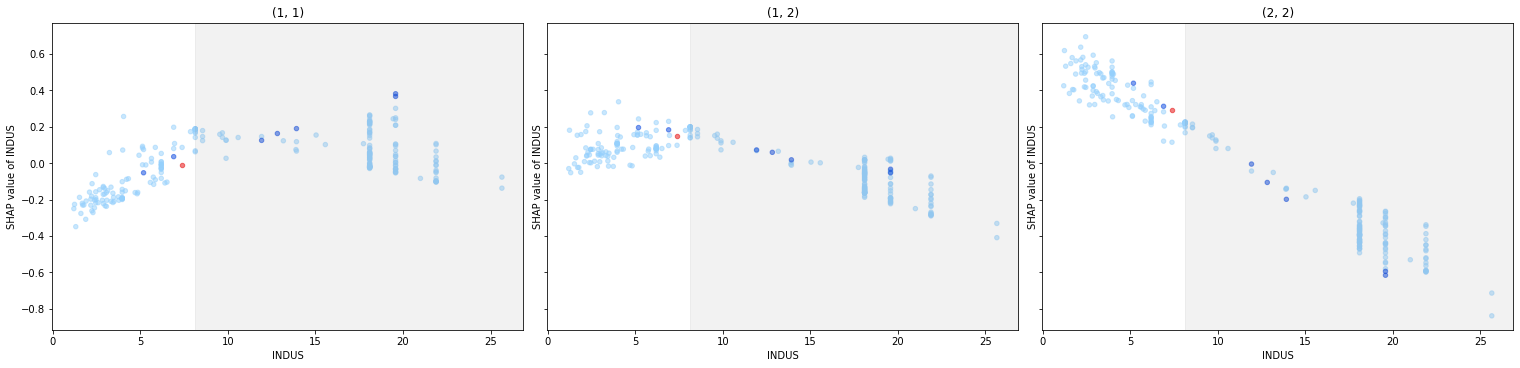

AGE <= 0.0
AGE >= 1.0 --> {'(1, 1)': 1}


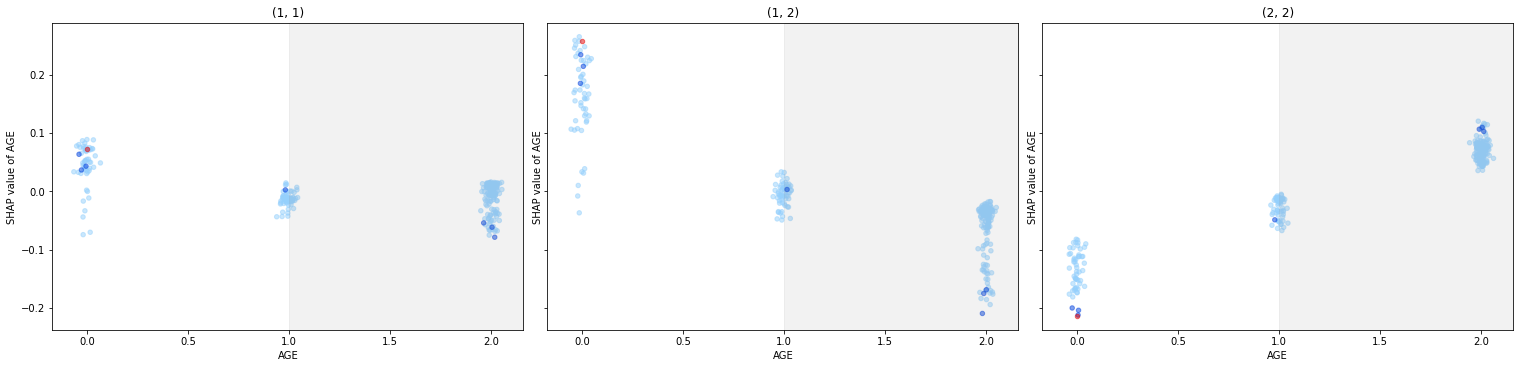

5.4159 <= DIS <= 5.4159
DIS <= 1.9 --> {'(2, 2)': 1}
DIS >= 5.66 --> {'(1, 1)': 1}


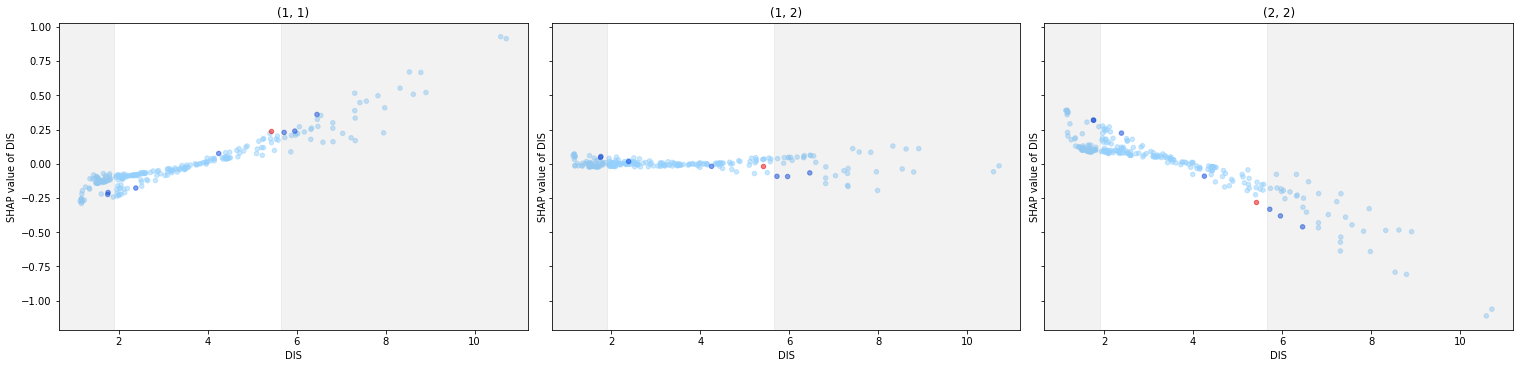

5.0 <= RAD <= 5.0
RAD <= 4.27 --> {'(1, 1)': 1}
RAD >= 12.73 --> {'(2, 2)': 1}


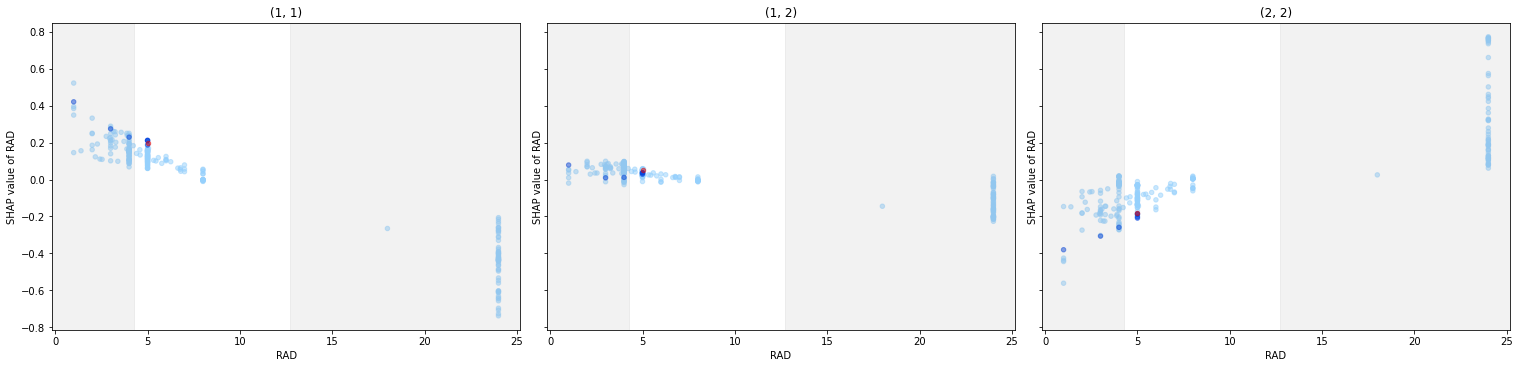

0.30347 <= CRIM <= 0.30347
CRIM >= 15.0 --> {'(0, 0)': 1}


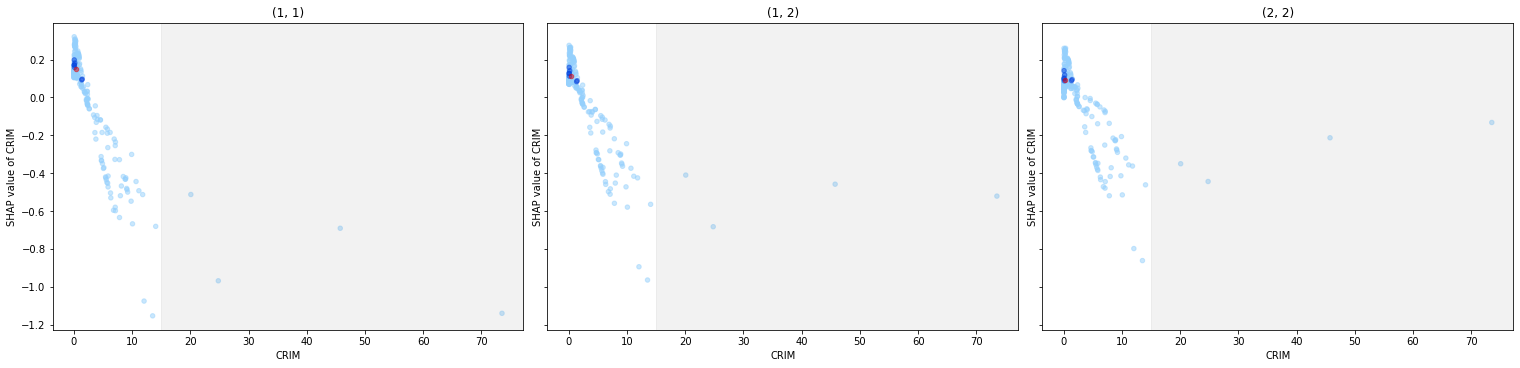

ZN <= 0.0
ZN >= 90.0 --> {'(2, 2)': 1}


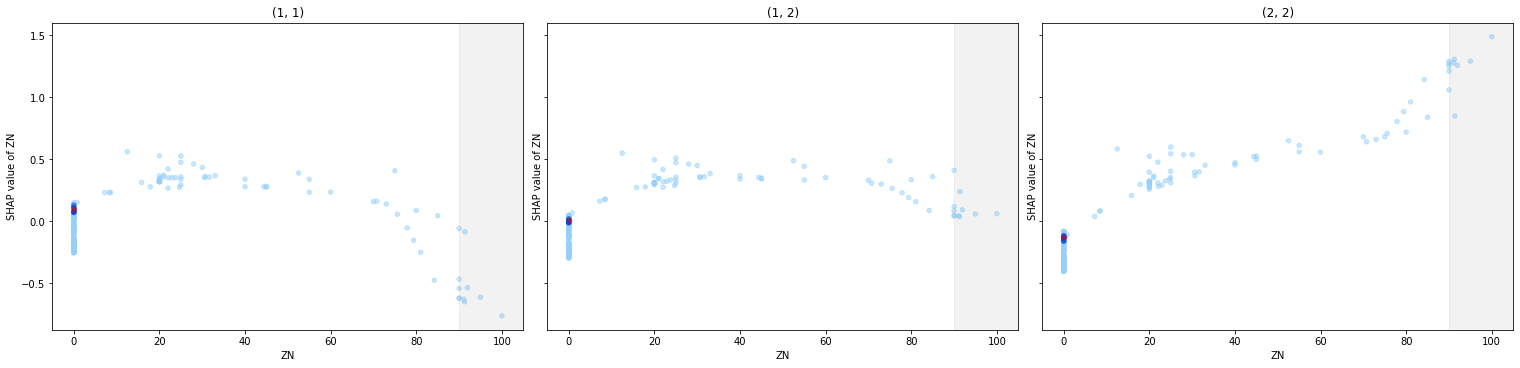

6.312 <= RM <= 6.312
RM <= 6.2 --> {'(1, 1)': 1}
RM >= 7.75 --> {'(2, 2)': 1}


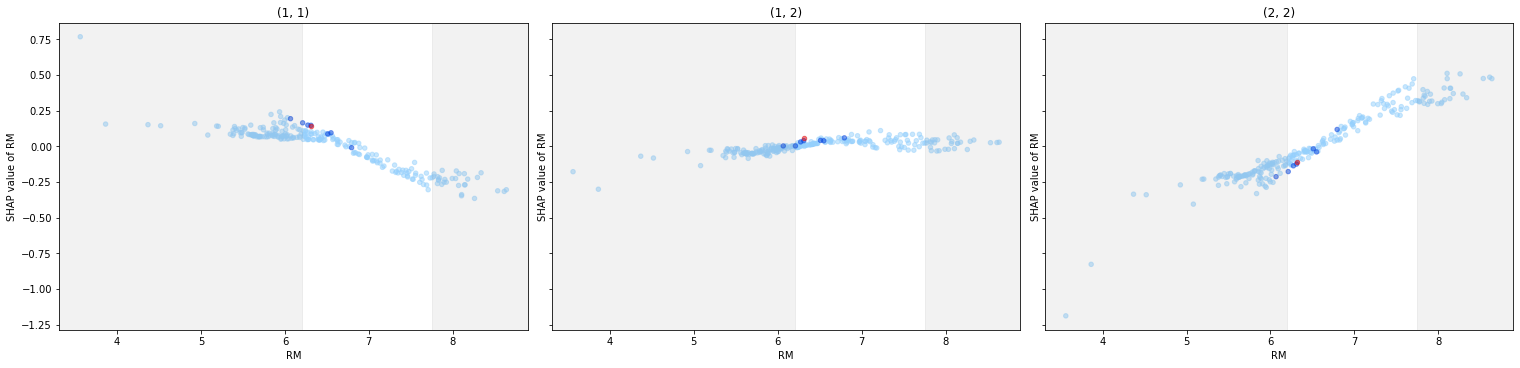

19.6 <= PTRATIO <= 19.6
PTRATIO <= 17.34 --> {'(1, 1)': 1}


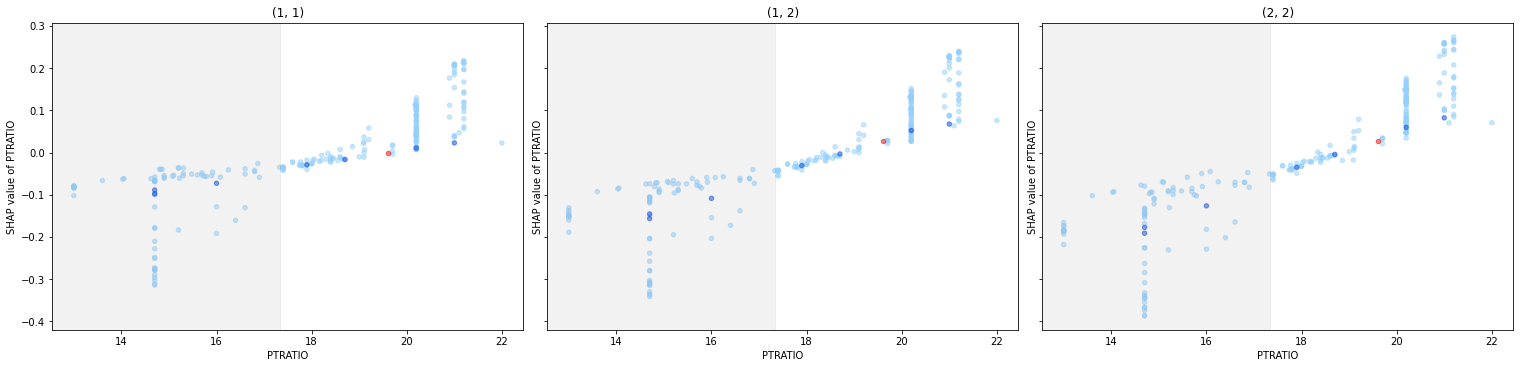

In [106]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

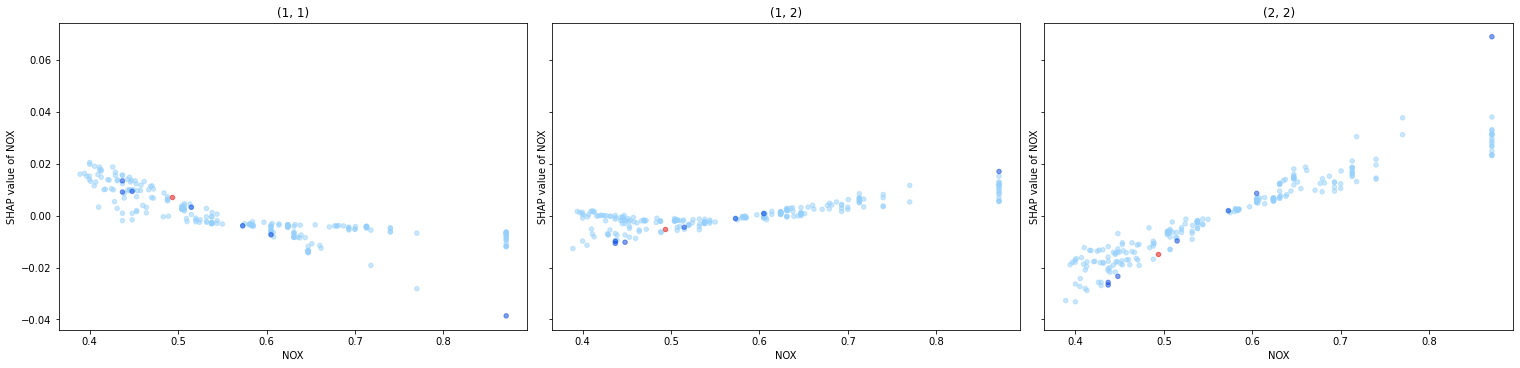

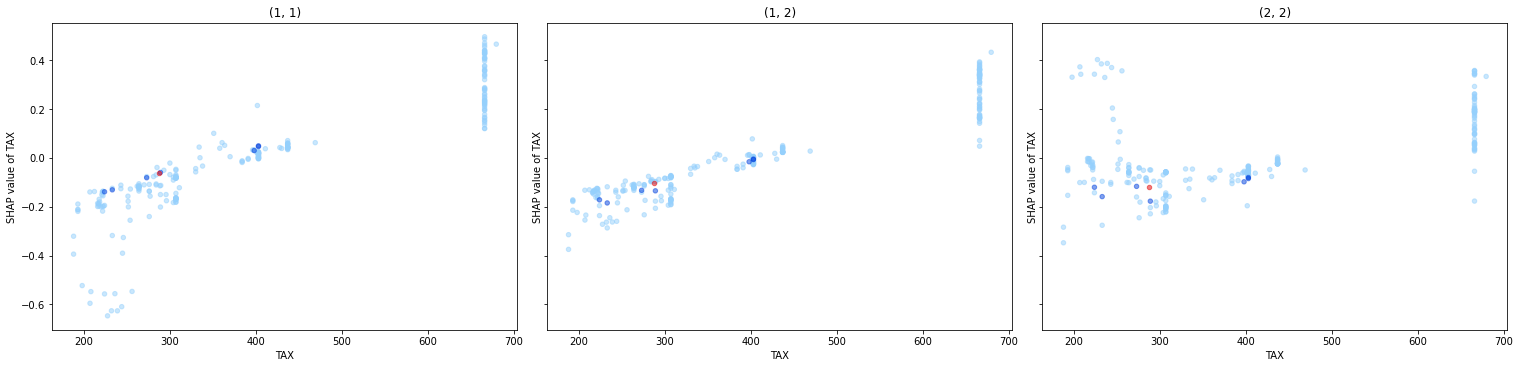

In [107]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature(feature, focus=node, alpha=0.5)

6.15 <= LSTAT <= 6.15
LSTAT <= 4.51 --> {'(2, 2)': 1}
LSTAT >= 6.28 --> {'(1, 1)': 1}


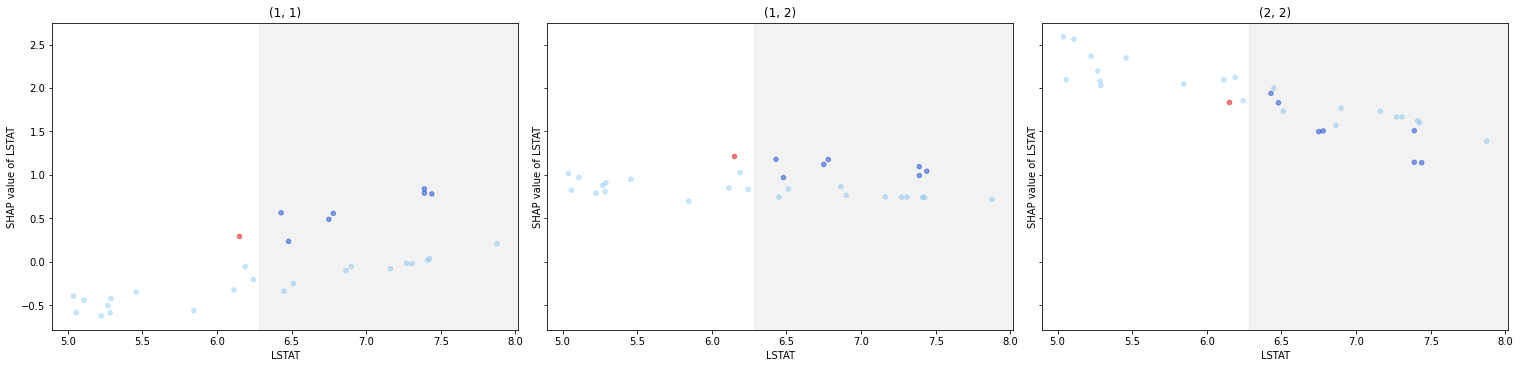

7.38 <= INDUS <= 7.38
INDUS >= 8.15 --> {'(1, 1)': 1}


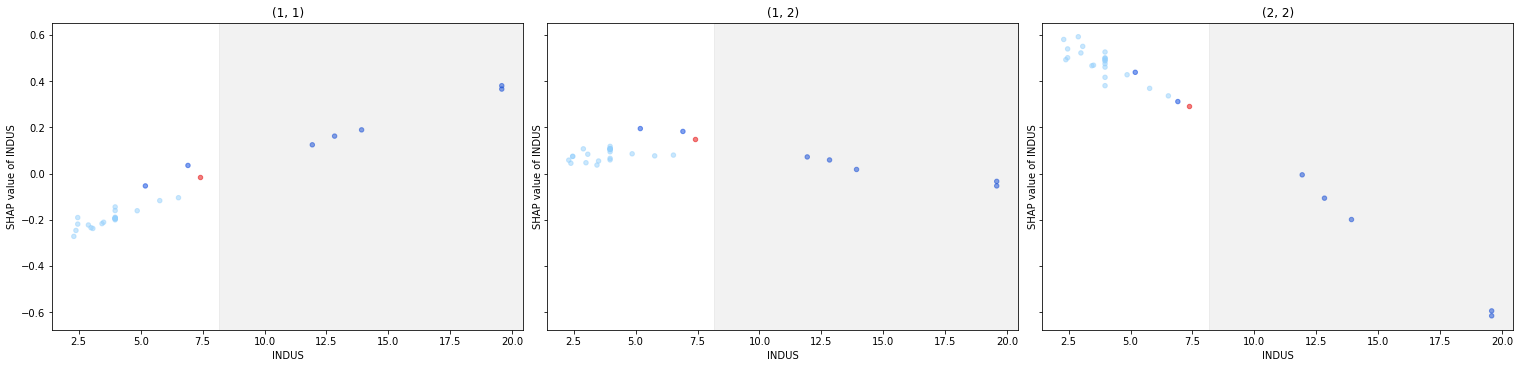

In [109]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

These are the explanations for the locally most important features.

## Clustering of Class $(2,1)$ SHAP Values

In [9]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds,
                          '(2, 1)', ['(1, 1)', '(2, 1)', '(2, 2)'],
                          categorical_features=categorical_features,
                          feature_precisions=feature_precisions)

### Node LR

In [10]:
node.class_counts, node.distance

((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 59.58275464415261)

In [11]:
node = node.get_left()
node.class_counts, node.distance

((2, 2)    95
 (1, 1)    28
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 19.839612506418888)

In [12]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    28
 (2, 2)    11
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 12.212893429781056)

In [13]:
node.get_left().class_counts

(2, 2)    11
(1, 1)     9
(2, 1)     2
(1, 2)     1
dtype: int64

6.48 <= LSTAT <= 8.93
LSTAT <= 5.97 --> {'(2, 2)': 3}
LSTAT >= 9.06 --> {'(1, 1)': 3}


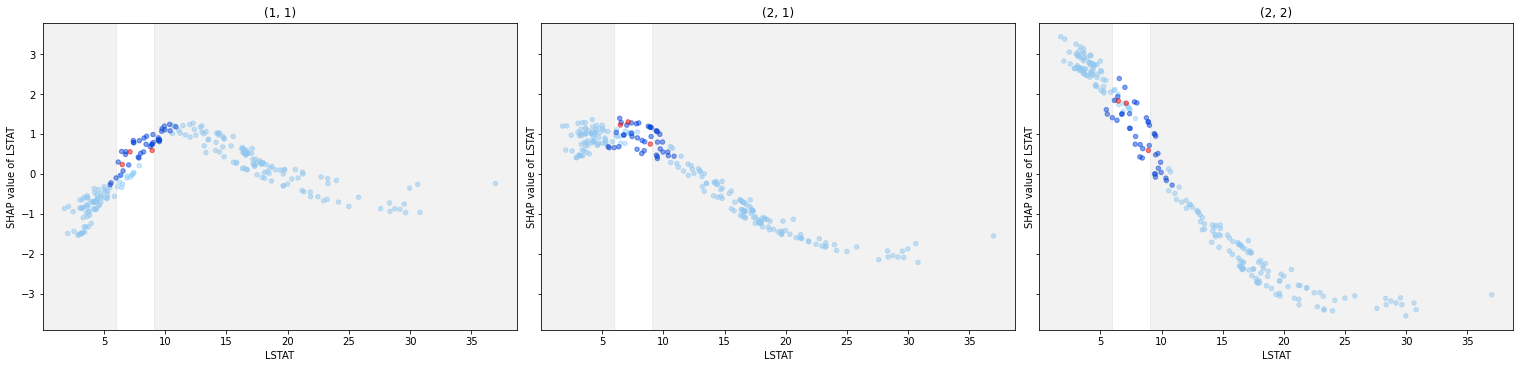

2.18 <= INDUS <= 18.1
INDUS >= 19.62 --> {'(1, 1)': 3}


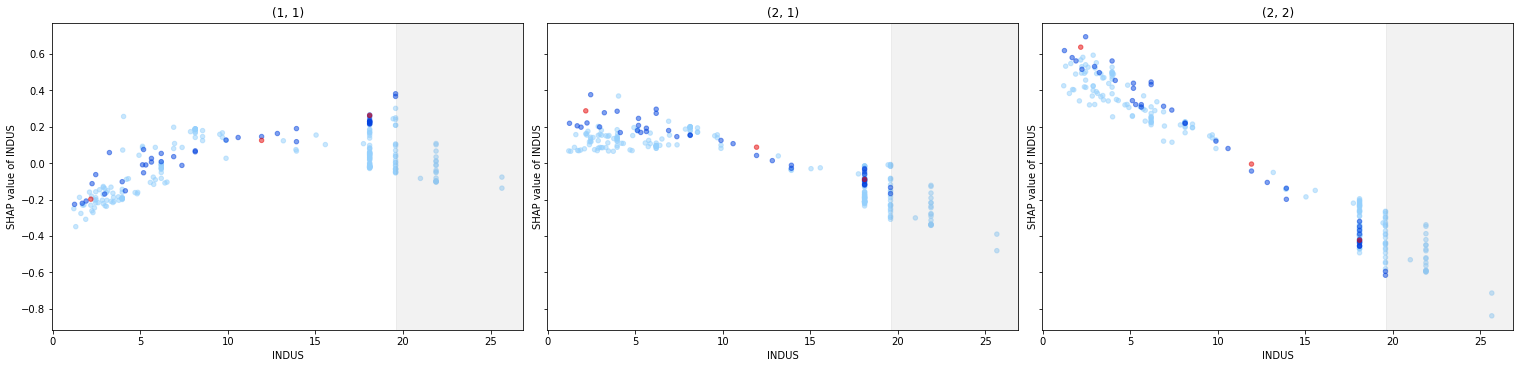

1.6132 <= DIS <= 3.37
DIS >= 4.18 --> {'(1, 1)': 3}


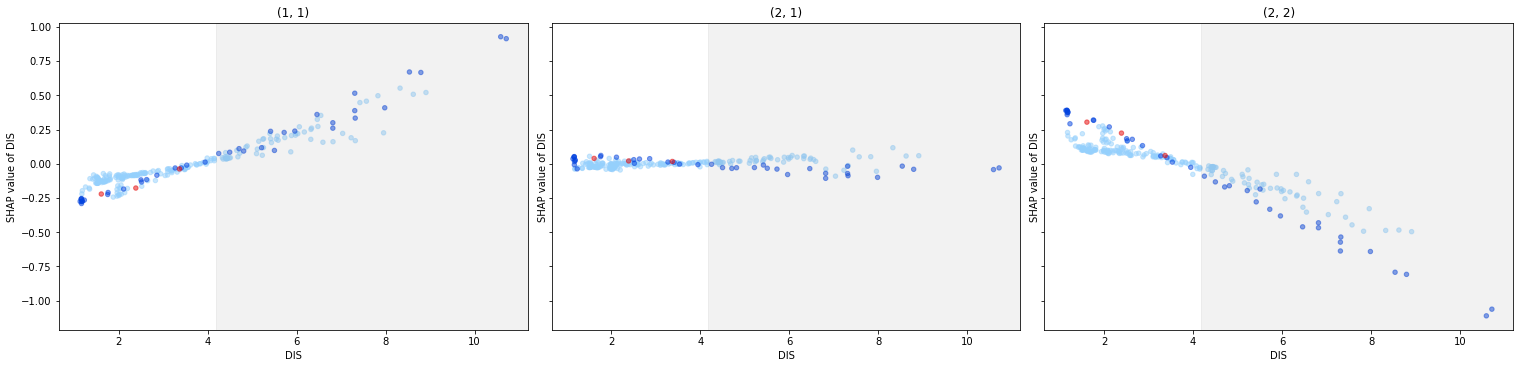

ZN <= 33.0
ZN >= 82.0 --> {'(2, 2)': 3}


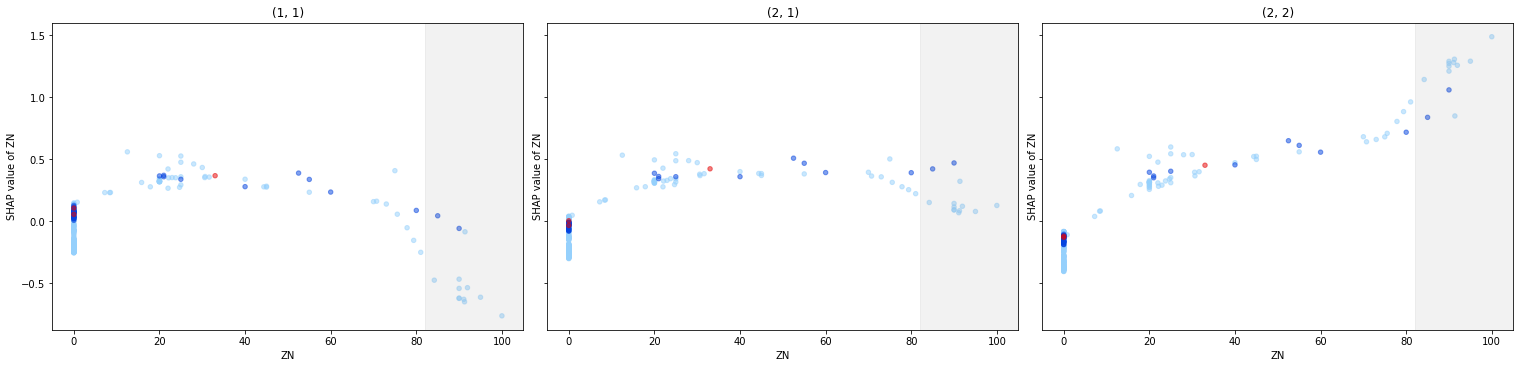

0.05479 <= CRIM <= 4.55587
CRIM >= 13.0 --> {'(2, 2)': 2, '(0, 1)': 1}


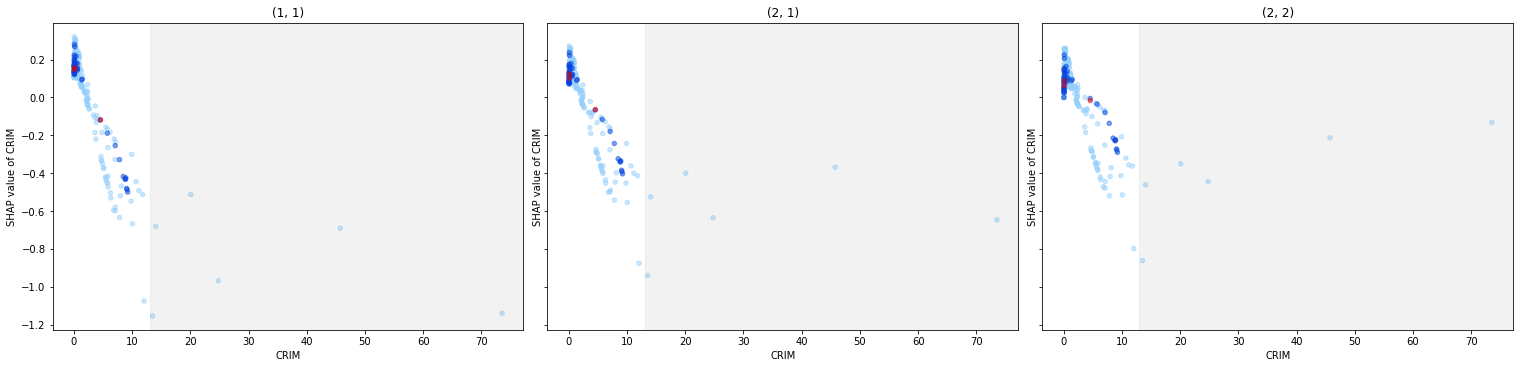

1.0 <= AGE
AGE <= 0.0 --> {'(1, 2)': 3}


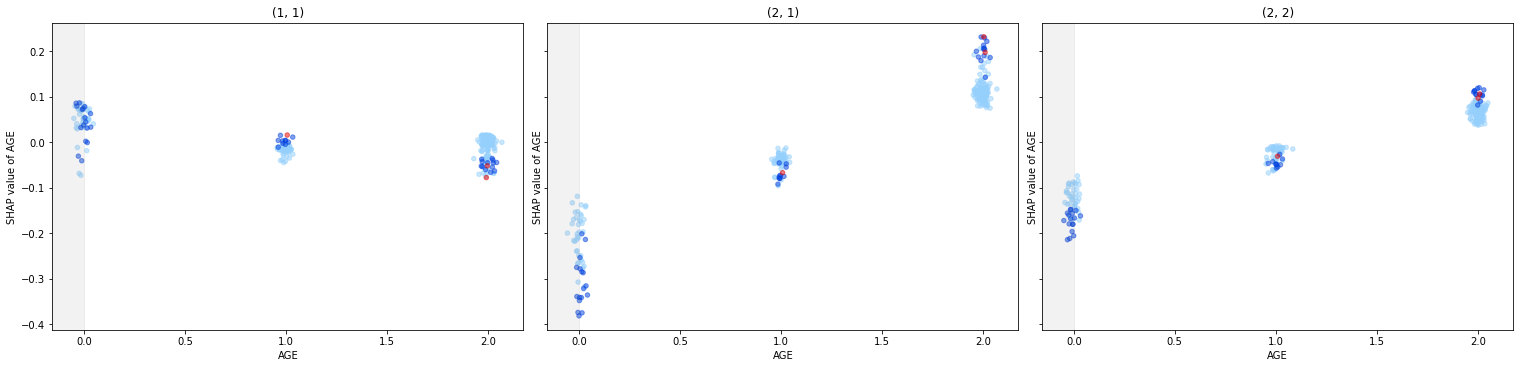

RM <= 6.794
RM >= 7.22 --> {'(2, 2)': 3}


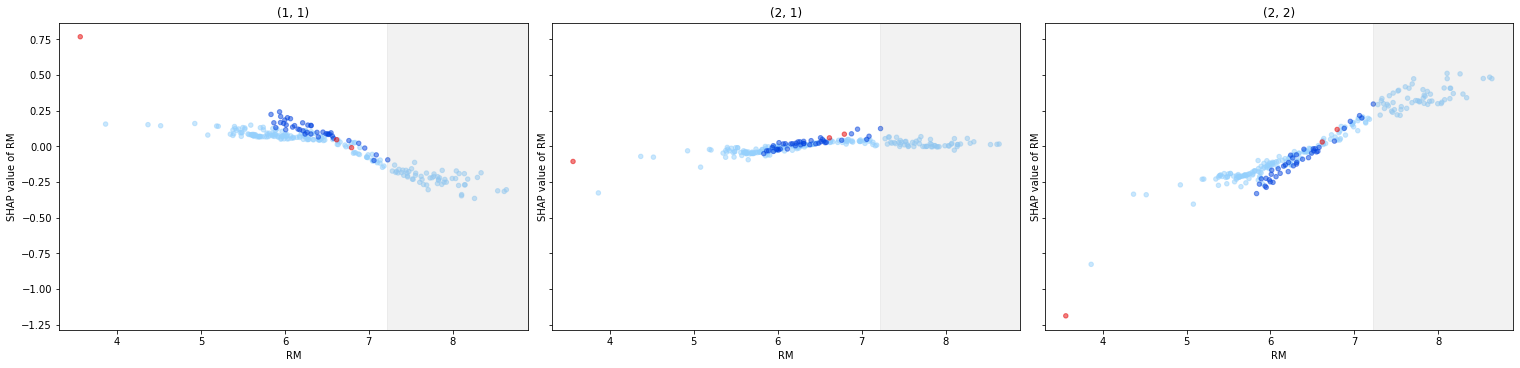

In [14]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

The instances classified differently are local to a specific LSTAT value range. The clustered instances also support that view. The INDUS counterfactual is rather high. For DIS the current cluster has the most extreme linear dependence. This makes me think, that LSTAT might be heavily interacting with it.

Taking a look at the global dependence plots of DIS, colored by LSTAT feature values confirms that:

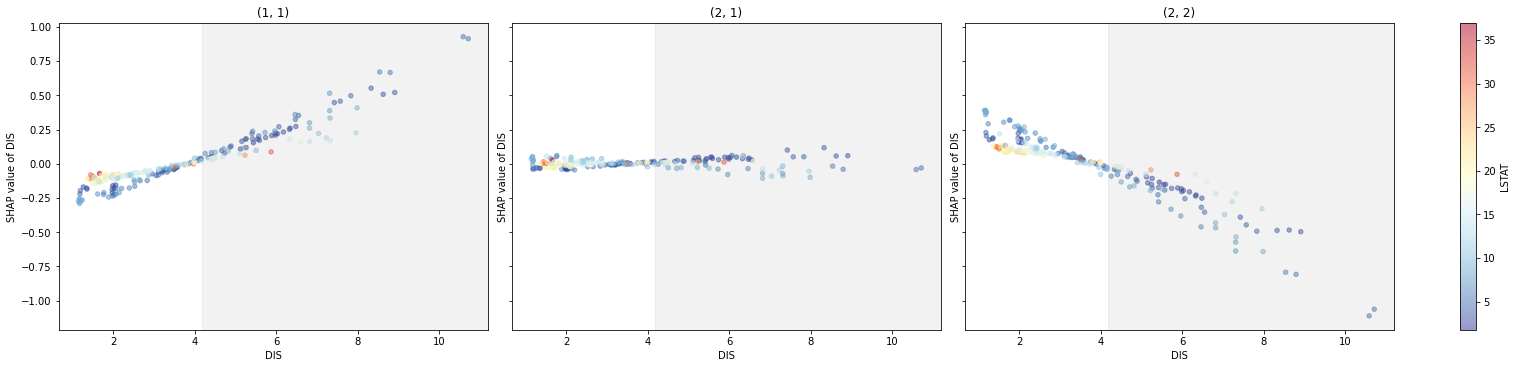

In [15]:
node.root.plot_feature('DIS', alpha=0.5, color='LSTAT')

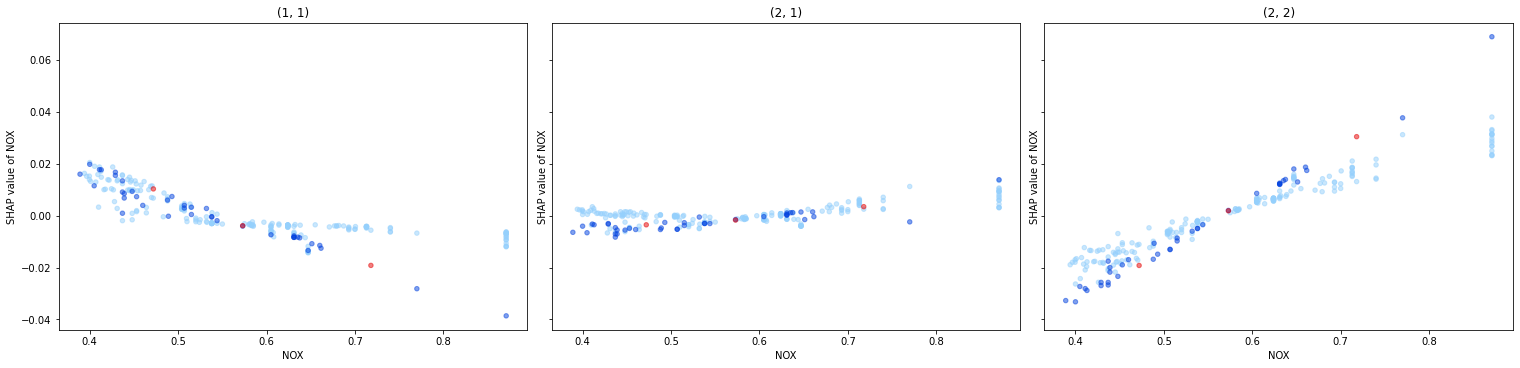

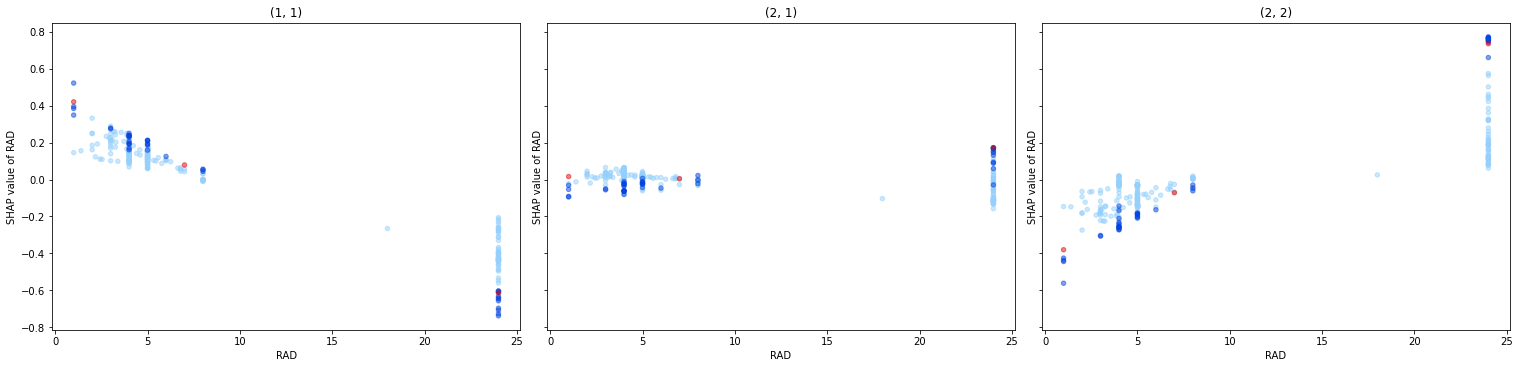

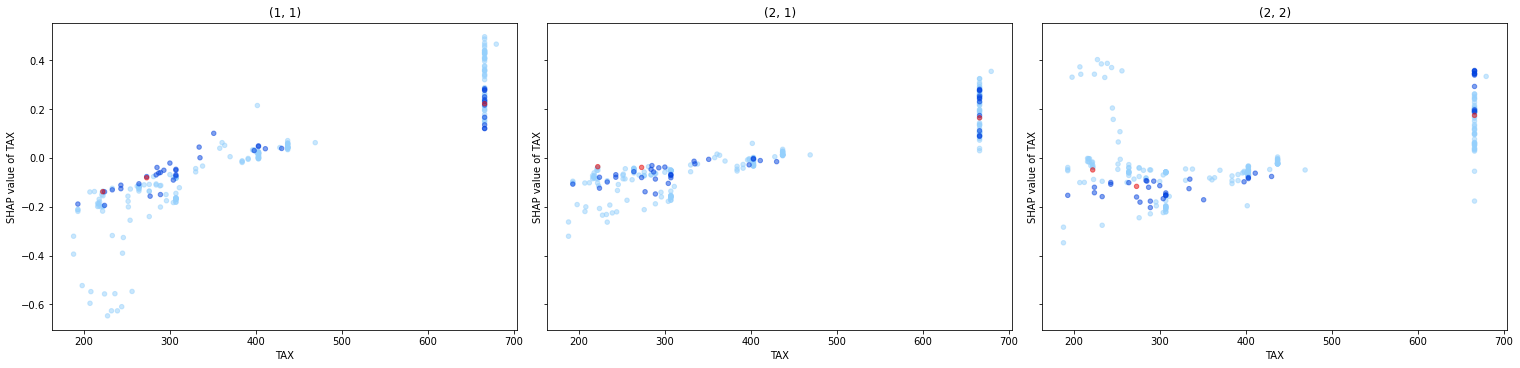

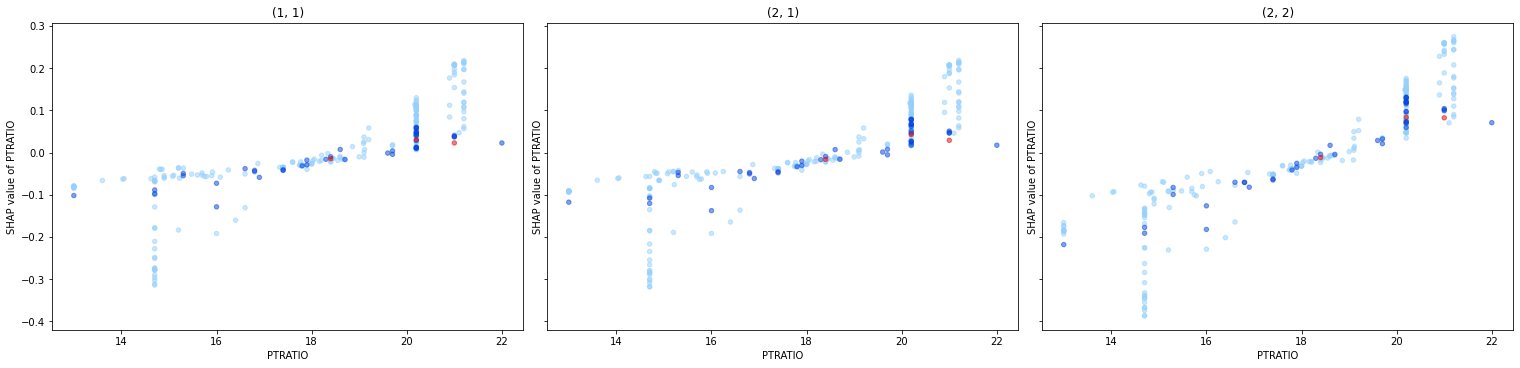

In [16]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature(feature, focus=node, alpha=0.5)

### Node LRL

In [17]:
node = node.get_left()
node.class_counts, node.distance

((2, 2)    11
 (1, 1)     9
 (2, 1)     2
 (1, 2)     1
 dtype: int64,
 7.107928353261454)

In [18]:
node.get_left().class_counts

(2, 2)    11
(2, 1)     1
dtype: int64

The cluster distance is still very high.

LSTAT includes the two lower values of instances classified differently. Compared to the global explanation, INDUS now has a lower counterfactual as well, but still include a large portion of the feature values. The explanations for CRIM and DIS are not more specific than the global ones.

6.48 <= LSTAT <= 7.12
LSTAT <= 5.97 --> {'(2, 2)': 2}
LSTAT >= 7.42 --> {'(1, 1)': 2}


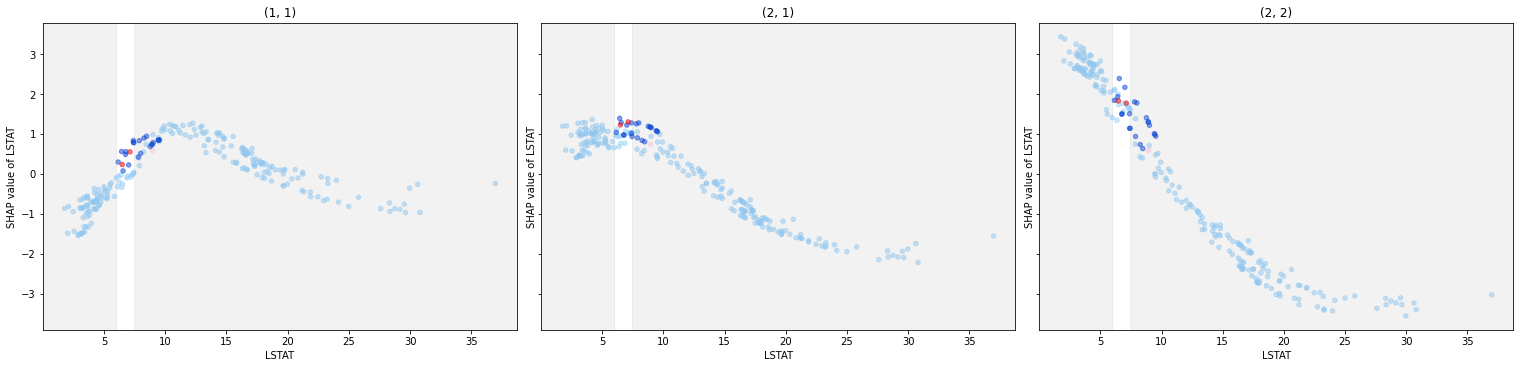

11.93 <= INDUS <= 18.1
INDUS <= 8.77 --> {'(2, 2)': 2}
INDUS >= 19.62 --> {'(1, 1)': 2}


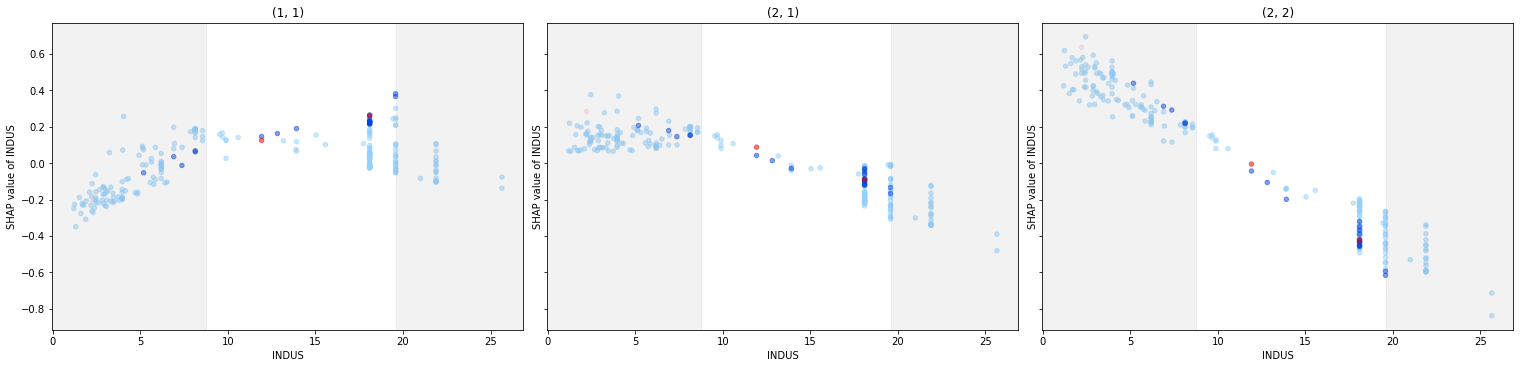

0.10959 <= CRIM <= 4.55587
CRIM >= 13.0 --> {'(0, 1)': 1, '(2, 2)': 1}


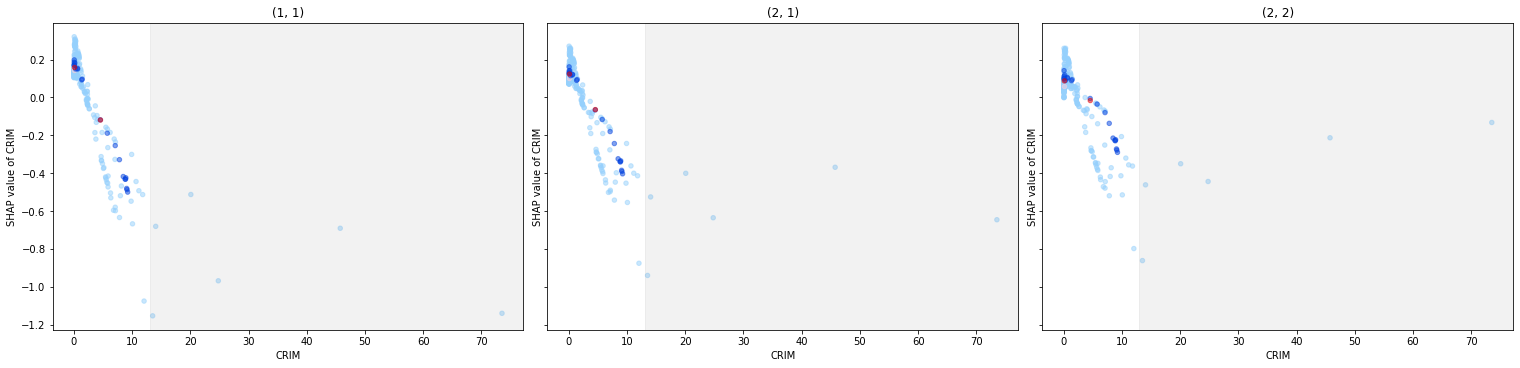

1.6132 <= DIS <= 2.3889
DIS >= 4.18 --> {'(1, 1)': 2}


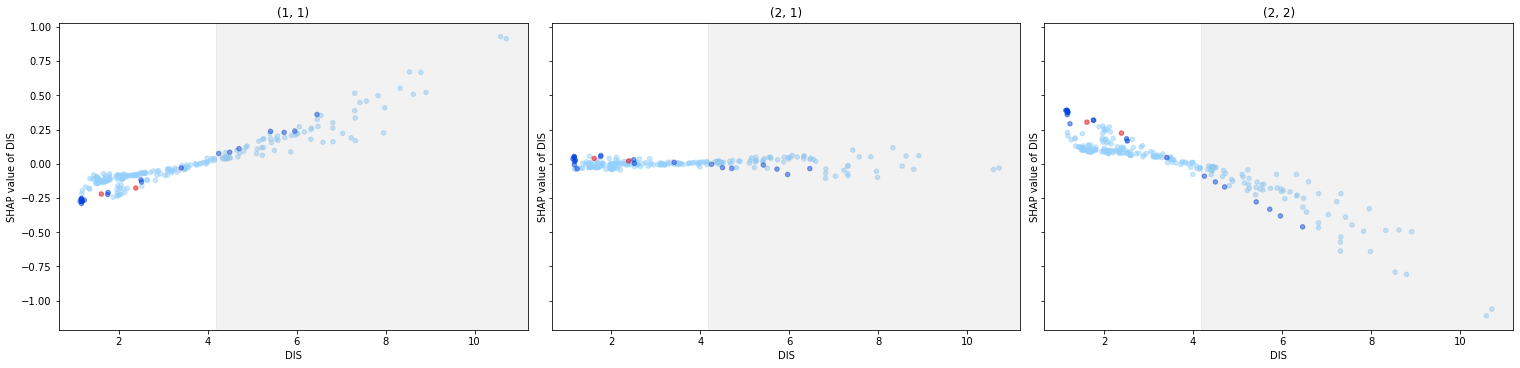

In [19]:
for feature in node.feature_names_relevant[:4]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

### Node LRLLR

In [20]:
node = node.get_left()
node.class_counts, node.distance

((2, 2)    11
 (2, 1)     1
 dtype: int64,
 3.267169098052548)

In [21]:
node = node.get_right()
node.class_counts, node.distance

((2, 2)    7
 (2, 1)    1
 dtype: int64,
 2.8597952621618465)

In [22]:
node.get_left().class_counts

(2, 1)    1
dtype: int64

The LSTAT counterfactuals are closer to the instance now. The second most important feature locally (RAD) has an especially big feature value and great influence in this cluster, compared to the parent cluster. CRIM now also flips at 0, and TAX is very high, including a high lower counterfactual.

LSTAT == 7.12
LSTAT <= 6.18 --> {'(2, 2)': 1}
LSTAT >= 7.42 --> {'(1, 1)': 1}


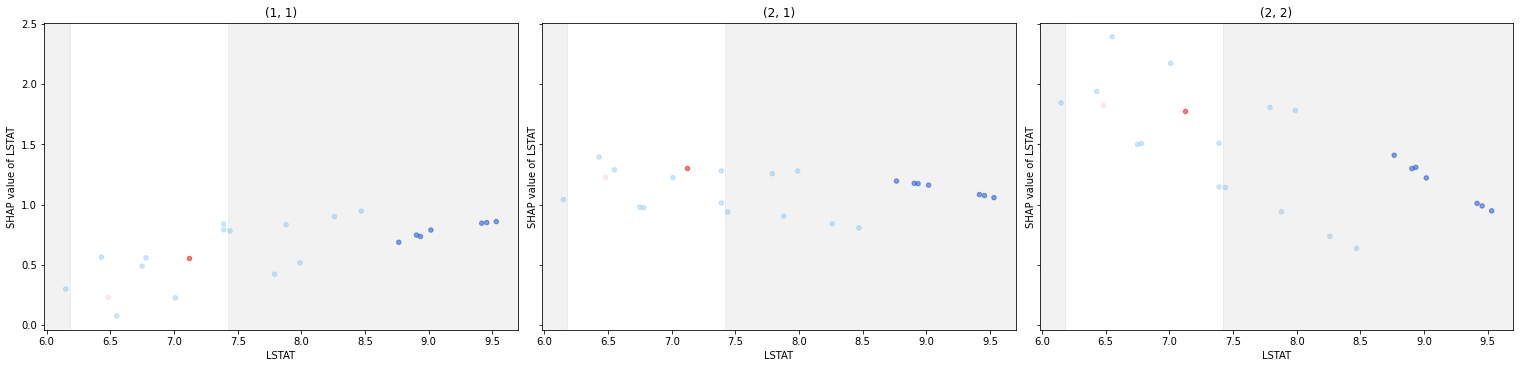

RAD == 24.0
RAD <= 22.57 --> {'(1, 1)': 1}


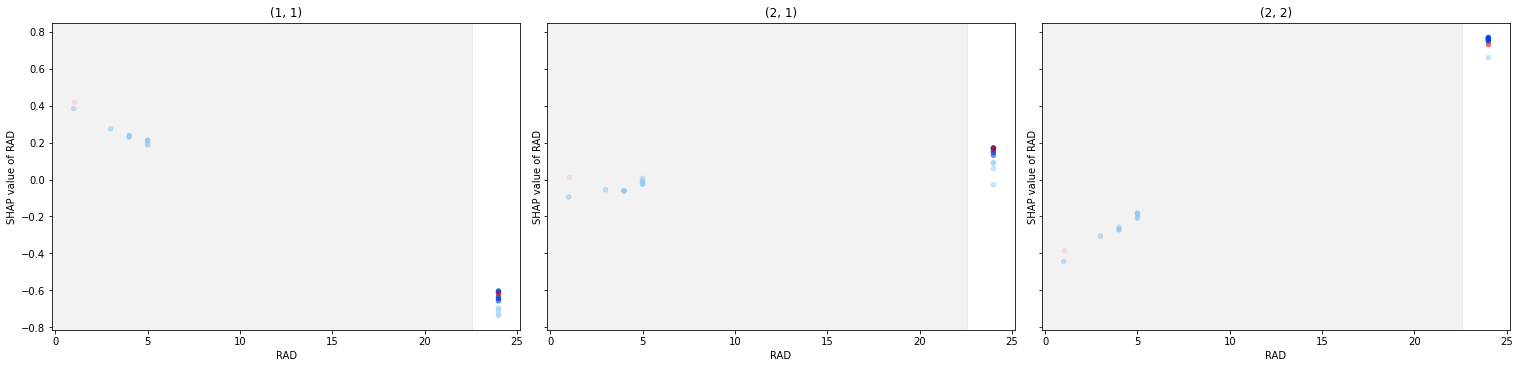

CRIM == 4.55587
CRIM <= 0.0 --> {'(1, 1)': 1}
CRIM >= 13.0 --> {'(0, 1)': 1}


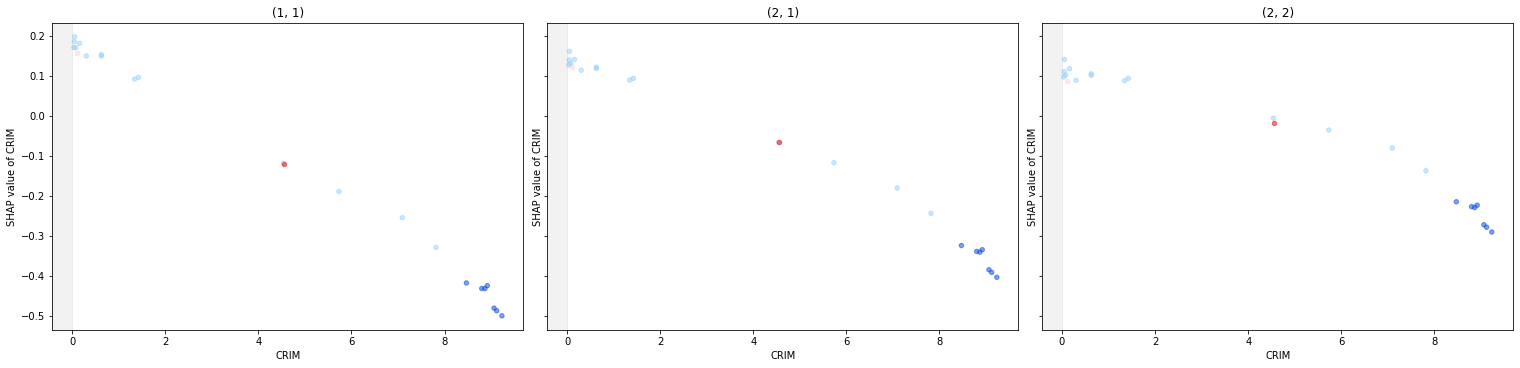

TAX == 666.0
TAX <= 301.0 --> {'(1, 1)': 1}


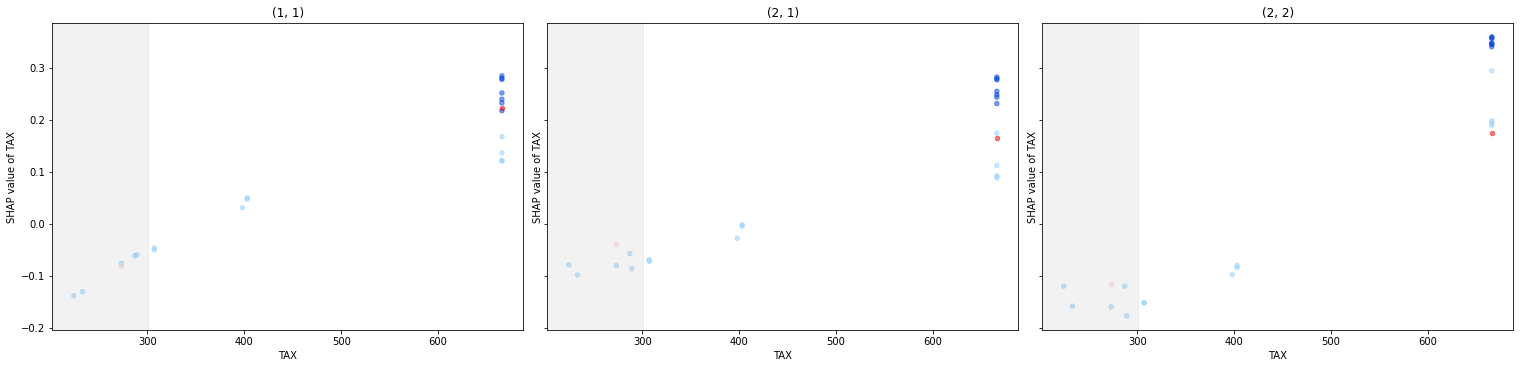

In [23]:
for feature in node.feature_names_relevant[:4]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

### Node LRLRL

In [24]:
node = node.parent.parent.get_right()
node.class_counts, node.distance

((1, 1)    9
 (1, 2)    1
 (2, 1)    1
 dtype: int64,
 3.6272346113505574)

In [25]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    2
 (2, 1)    1
 dtype: int64,
 1.1691954561771805)

In [26]:
node.get_left().class_counts

(2, 1)    1
dtype: int64

The LSTAT explanation is similar to the last cluster. But now INDUS is ranked the second most important feature. According to its counterfactuals, it is a local difference. DIS has an additional lower counterfactual. RAD is very low and also provides an explanation.

LSTAT == 6.48
LSTAT <= 5.97 --> {'(2, 2)': 1}
LSTAT >= 7.32 --> {'(1, 1)': 1}


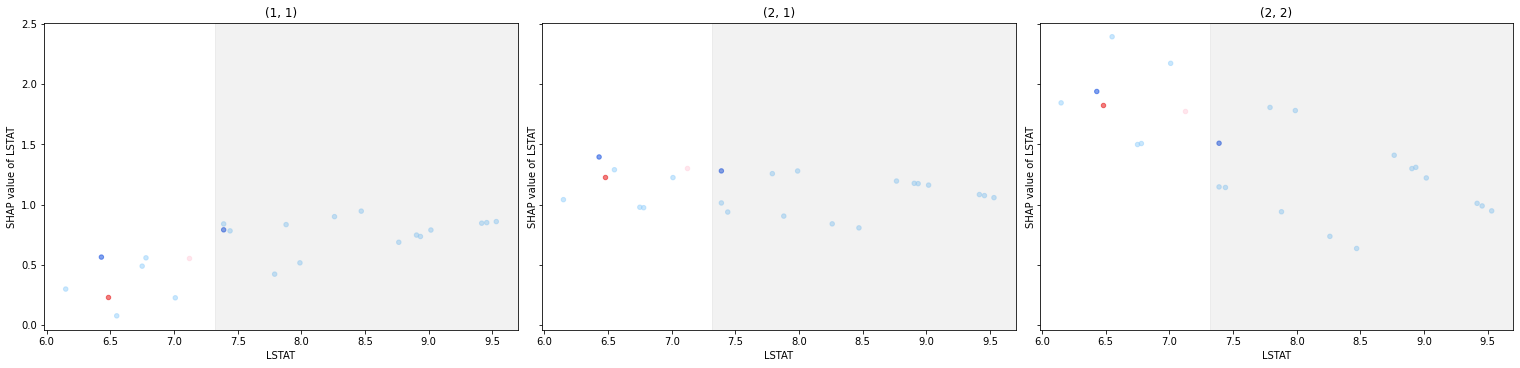

INDUS == 11.93
INDUS <= 8.77 --> {'(2, 2)': 1}
INDUS >= 16.32 --> {'(1, 1)': 1}


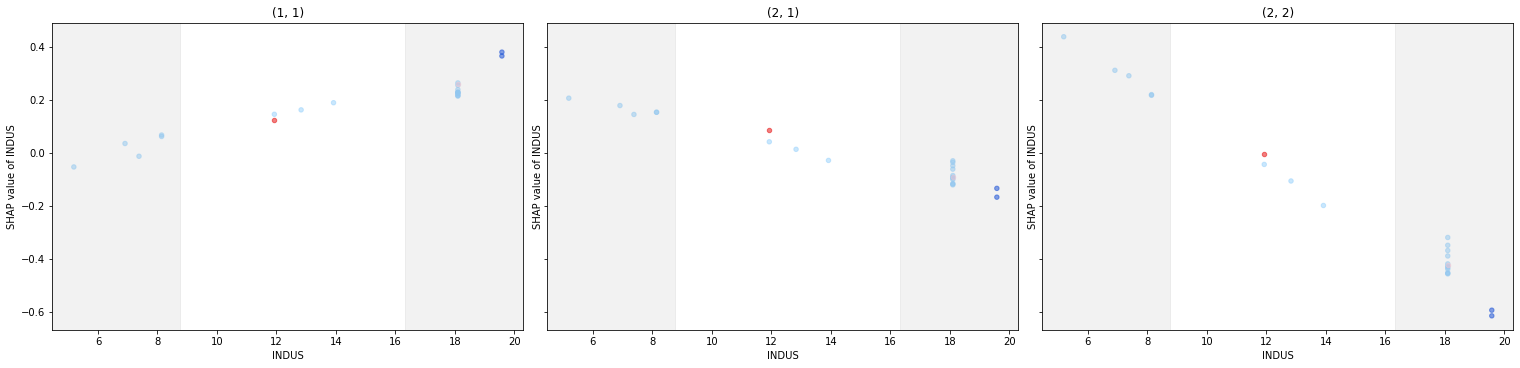

DIS == 2.3889
DIS <= 1.41 --> {'(2, 2)': 1}
DIS >= 4.18 --> {'(1, 1)': 1}


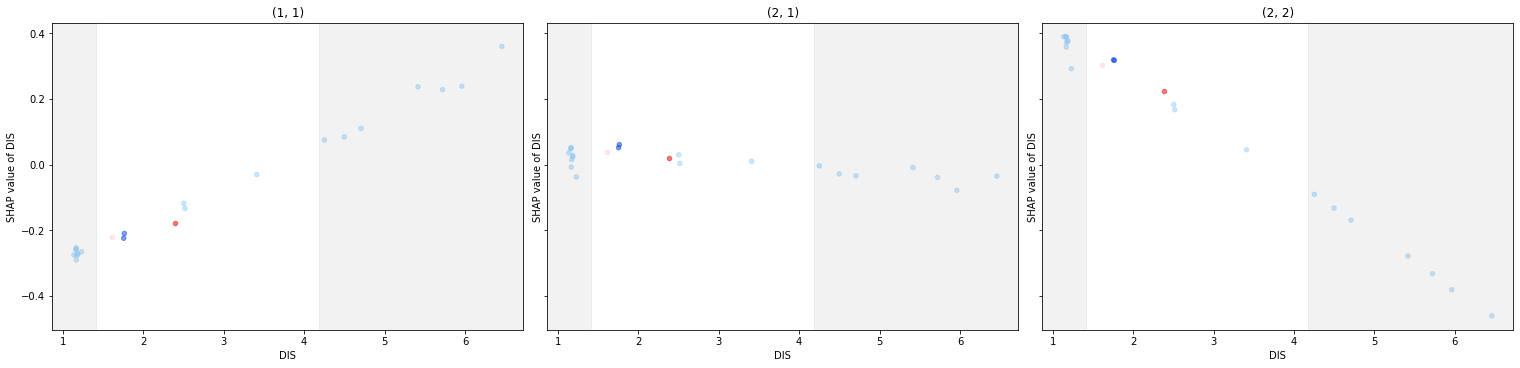

RAD == 1.0
RAD >= 3.9 --> {'(2, 2)': 1}


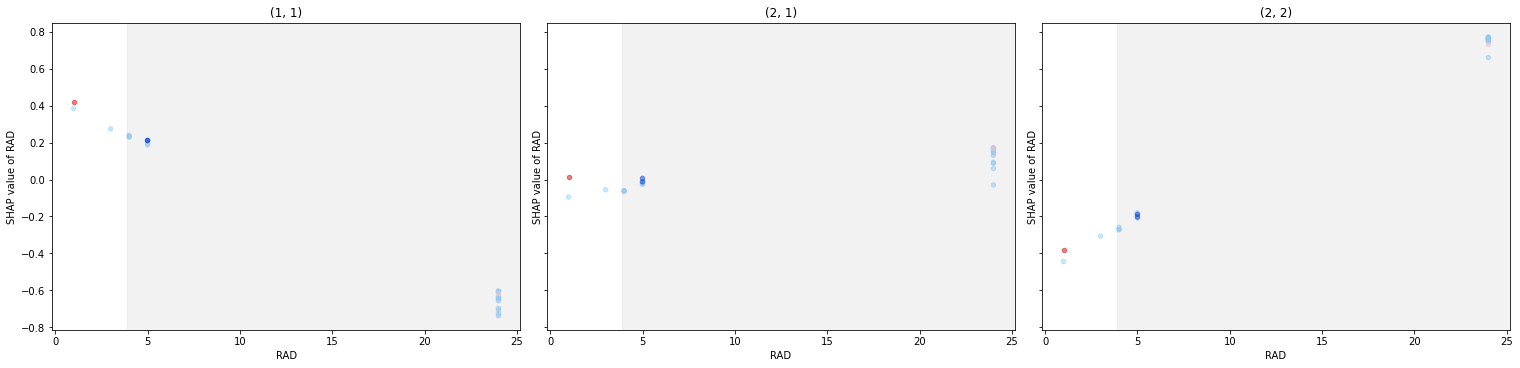

In [29]:
for feature in node.feature_names_relevant[:4]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

### Node LRR

In [36]:
node = node.root.get('LRR')
node.class_counts, node.distance

((1, 1)    19
 (2, 1)     1
 dtype: int64,
 8.993309386933548)

In [37]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    14
 (2, 1)     1
 dtype: int64,
 3.0159701478335106)

In [38]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    9
 (2, 1)    1
 dtype: int64,
 2.790494403697335)

LSTAT of the instance classified differently is the highest. Its counterfactuals are close like in the other explanations. The second most important feature locally is INDUS, which is especially low with a low upper counterfactual. The difference is local to RM and RAD.

LSTAT == 8.93
LSTAT <= 8.55 --> {'(2, 2)': 1}
LSTAT >= 9.06 --> {'(1, 1)': 1}


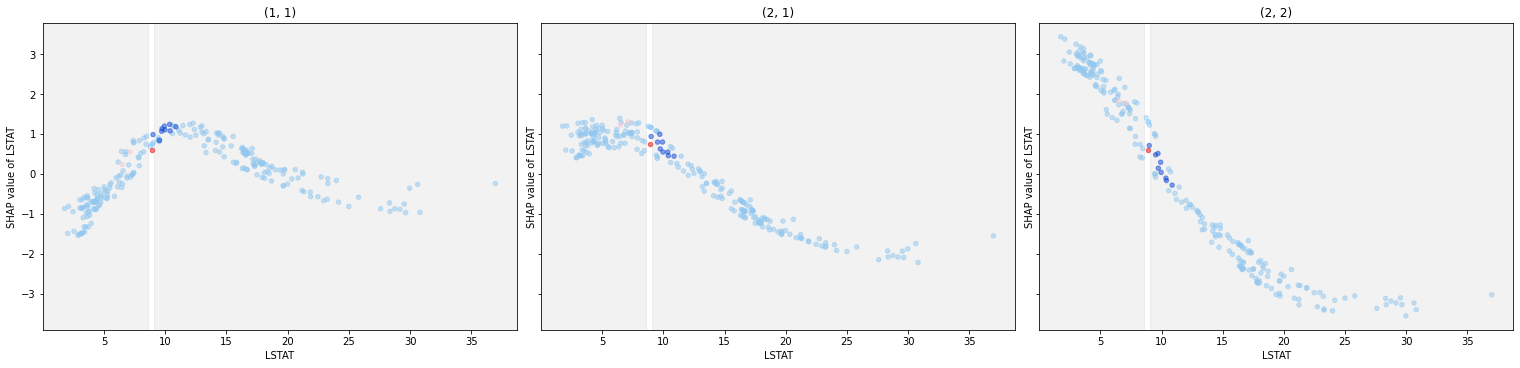

INDUS == 2.18
INDUS >= 2.86 --> {'(1, 1)': 1}


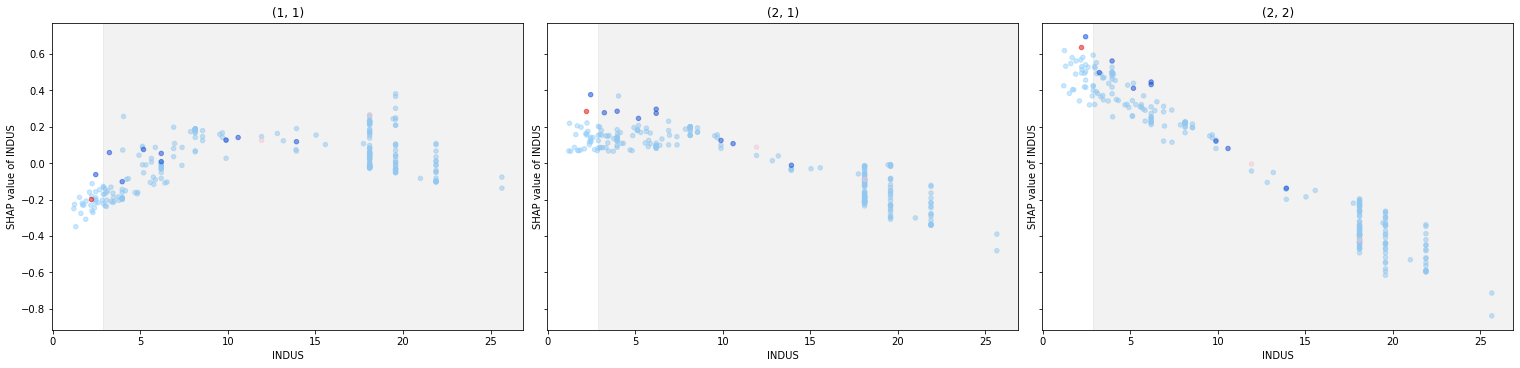

CRIM == 0.05479
CRIM >= 7.0 --> {'(2, 2)': 1}


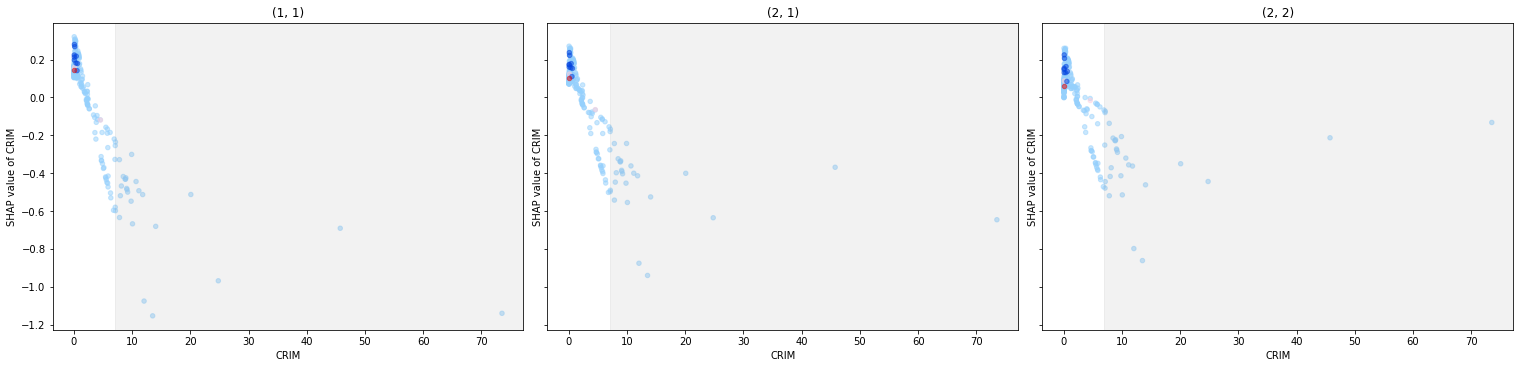

ZN == 33.0
ZN <= 24.0 --> {'(1, 1)': 1}
ZN >= 62.0 --> {'(2, 2)': 1}


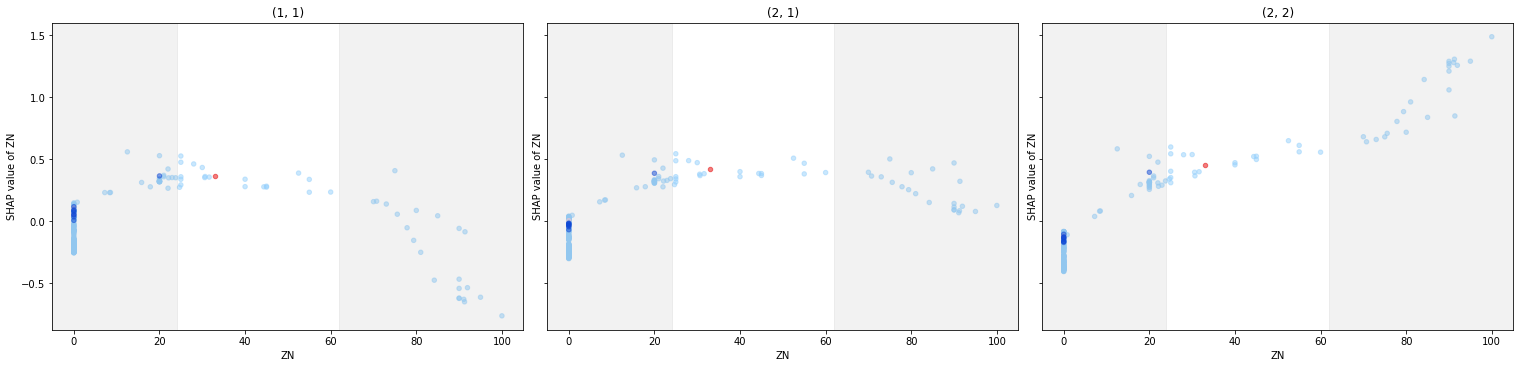

TAX == 222.0
TAX >= 300.0 --> {'(1, 1)': 1}


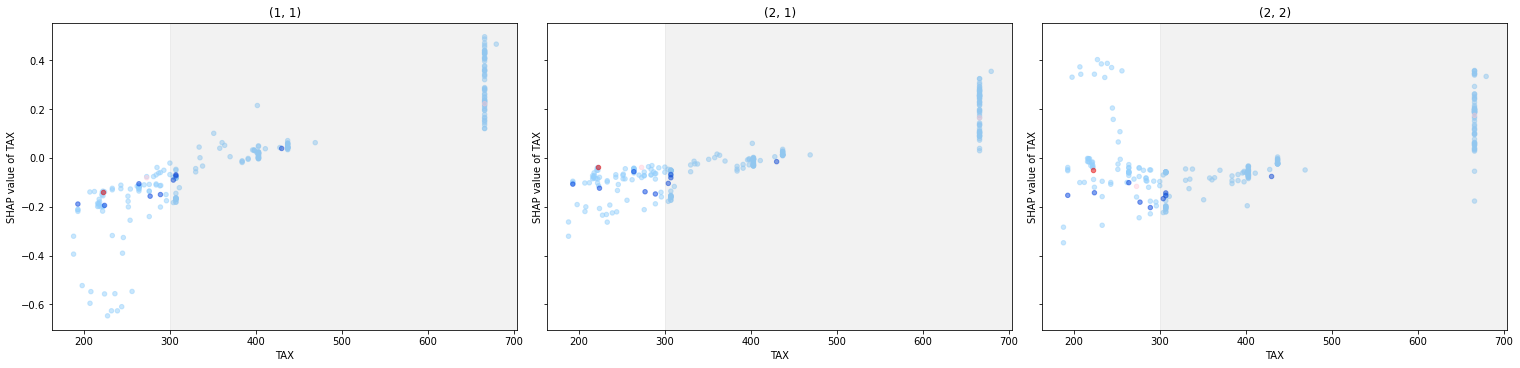

RM == 6.616
RM <= 6.5 --> {'(1, 1)': 1}
RM >= 6.94 --> {'(2, 2)': 1}


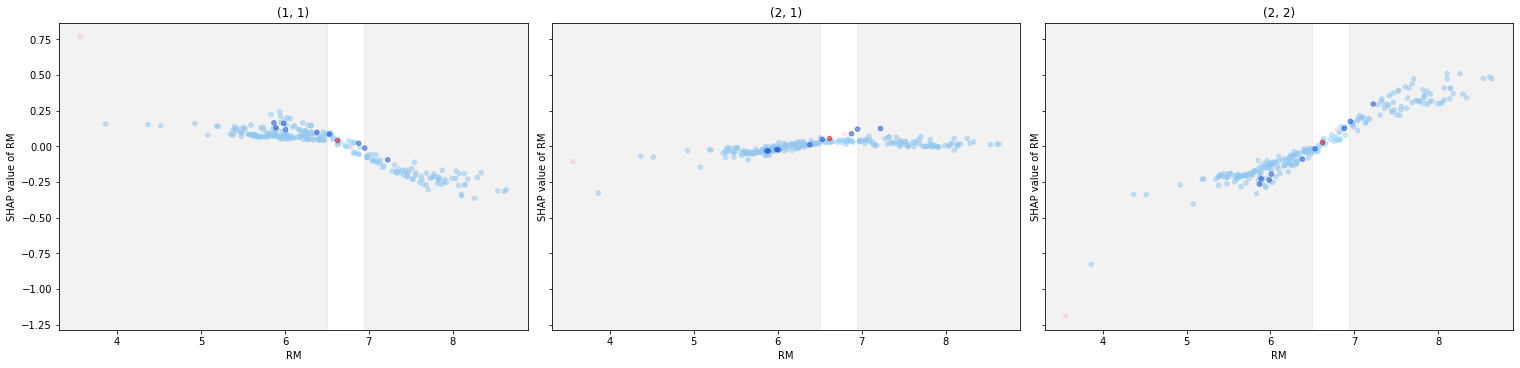

RAD == 7.0
RAD <= 6.39 --> {'(1, 1)': 1}
RAD >= 9.31 --> {'(2, 2)': 1}


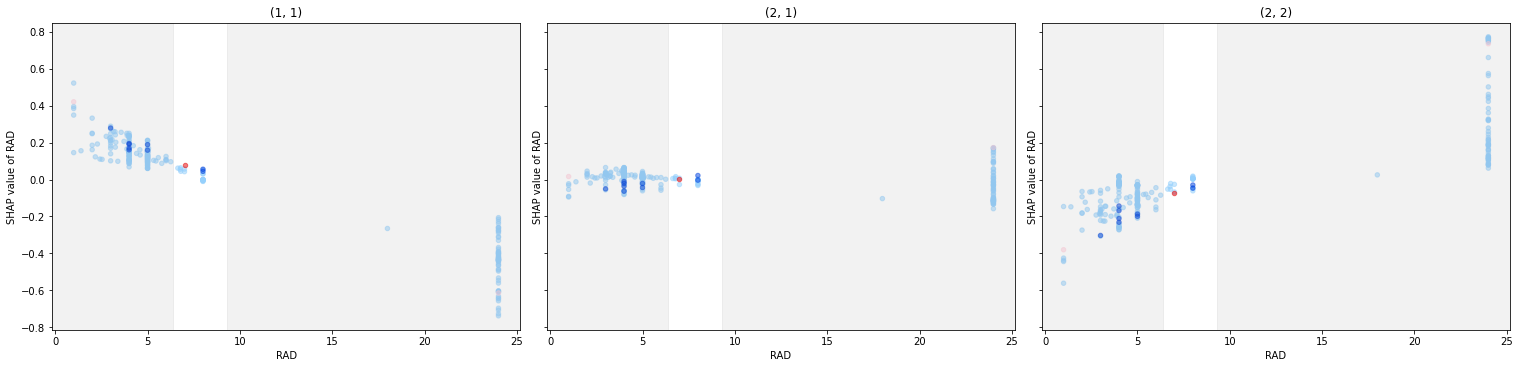

In [42]:
for feature in node.feature_names_relevant[:7]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)